In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from numpy.linalg import norm
from tqdm import tqdm
import time

np.random.seed(42)
plt.rcParams.update({'figure.figsize': (9,6), 'font.size': 11})

@dataclass
class ScalableConfig:
    U: int
    B: int
    modulation: str
    Q: int
    scenario_name: str = "scenario"

def get_constellation(modulation: str) -> Tuple[np.ndarray, float]:
    """Return normalized constellation points and normalization factor"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        a = np.array([-1, 1])
        normalization = np.sqrt(2)  # Average power = 1 for QPSK
    elif mod in ('16qam','16q'):
        a = np.array([-3, -1, 1, 3])
        normalization = np.sqrt(10)  # Average power = 10
    elif mod in ('64qam','64q'):
        a = np.arange(-7, 8, 2)  # -7, -5, -3, -1, 1, 3, 5, 7
        normalization = np.sqrt(42)  # Average power = 42
    elif mod in ('256qam','256q'):
        a = np.arange(-15, 16, 2)  # -15, -13, ..., 13, 15
        normalization = np.sqrt(170)  # Average power = 170
    else:
        raise ValueError("Unsupported modulation")

    pts = np.array([x + 1j*y for x in a for y in a])
    return pts / normalization, normalization

def get_constellation_bounds(modulation: str) -> Tuple[float, float]:
    """Get normalized box constraint bounds"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        return -1.0/np.sqrt(2), 1.0/np.sqrt(2)
    elif mod in ('16qam','16q'):
        return -3.0/np.sqrt(10), 3.0/np.sqrt(10)
    elif mod in ('64qam','64q'):
        return -7.0/np.sqrt(42), 7.0/np.sqrt(42)
    elif mod in ('256qam','256q'):
        return -15.0/np.sqrt(170), 15.0/np.sqrt(170)
    else:
        raise ValueError("Unsupported modulation")

def generate_channel(B: int, U: int) -> np.ndarray:
    """Generate Rayleigh MIMO channel (B x U)"""
    H = (np.random.randn(B, U) + 1j * np.random.randn(B, U)) / np.sqrt(2)
    return H

def add_awgn(y_clean: np.ndarray, snr_db: float) -> np.ndarray:
    """Add AWGN noise"""
    snr_lin = 10**(snr_db/10)
    sig_power = np.mean(np.abs(y_clean)**2)
    noise_power = sig_power / snr_lin
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

def quantize_to_constellation(x: np.ndarray, constellation: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Quantize to constellation points (soft projection)"""
    d = np.abs(x[:, None] - constellation[None, :])
    idx = np.argmin(d, axis=1)
    return constellation[idx], idx

def mmse_detector(r: np.ndarray, H: np.ndarray, constellation: np.ndarray, snr_db: float):
    """MMSE detector"""
    B, U = H.shape
    Hh = H.conj().T
    snr_lin = 10**(snr_db/10)
    A = Hh @ H + (1/snr_lin) * np.eye(U)
    x_hat = np.linalg.solve(A, Hh @ r)
    x_hard, idx = quantize_to_constellation(x_hat, constellation)
    return x_hat, x_hard, idx

class GeneralizedADMM:
    def __init__(self, constellation: np.ndarray, U: int):
        self.constellation = constellation
        self.U = U

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float,
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        """
        Standard ADMM formulation:
        x^{k+1} = argmin_x f(x) + (ρ/2)‖x - z^k + u^k‖²
        z^{k+1} = Π_C(x^{k+1} + u^k)  [Soft projection - quantization to constellation]
        u^{k+1} = u^k + x^{k+1} - z^{k+1}
        """
        U = self.U
        B = H.shape[0]

        # Precompute matrices for x-update
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x = np.zeros(U, dtype=complex)  # primal variable
        z = np.zeros(U, dtype=complex)  # auxiliary variable (constrained)
        u = np.zeros(U, dtype=complex)  # dual variable

        residuals = []

        # Standard ADMM iterations
        for k in range(max_iter):
            # Store previous values for convergence check
            x_prev = x.copy()
            z_prev = z.copy()

            # x-update: quadratic minimization
            # argmin_x (1/2)‖r - Hx‖² + (ρ/2)‖x - z + u‖²
            x = inv_matrix @ (H_H_r + rho * (z - u))

            # z-update: soft projection to constellation (quantization)
            # Π_C(x + u)
            z, _ = quantize_to_constellation(x + u, self.constellation)

            # u-update: dual variable update
            u = u + x - z

            # Convergence check
            primal_residual = norm(x - z)
            dual_residual = norm(rho * (z - z_prev))
            residual = primal_residual + dual_residual

            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[GADMM] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final hard decision (use z which satisfies constellation constraint)
        x_hard, idx = quantize_to_constellation(z, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x, x_hard, idx, info

class PSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int, modulation: str):
        self.constellation = constellation
        self.U = U
        self.Q = Q
        self.low, self.high = get_constellation_bounds(modulation)

    def project_to_box(self, x: np.ndarray):
        """Box projection for PS-ADMM"""
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, self.low, self.high)
        x_imag = np.clip(x_imag, self.low, self.high)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        # Precompute fixed matrices
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x0 = np.zeros(U, dtype=complex)
        y = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Sequential updates of x_q for q = 1 to Q
            for q in range(1, Q+1):
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                
                sum_other = sum((2 ** (i-1)) * x_q[i] for i in range(1, Q+1) if i != q)
                numerator = 2 ** (q-1) * rho
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                inner_term = rho * x0 - rho * sum_other + y
                x_temp = (numerator / denominator) * inner_term
                x_q[q] = self.project_to_box(x_temp)

            # Update x0
            sum_xq = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            x0 = inv_matrix @ (H_H_r + rho * sum_xq - y)

            # Update Lagrange multiplier y
            y = y + rho * (x0 - sum_xq)

            # Convergence check
            residual = sum(norm(x_q[q] - x_q_prev[q]) for q in range(1, Q+1)) + norm(x0 - x_q_prev[0])
            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[PS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final estimate and hard decision
        x_est = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

class DPSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int, modulation: str):
        self.constellation = constellation
        self.U = U
        self.Q = Q
        self.low, self.high = get_constellation_bounds(modulation)

    def project_to_box(self, x: np.ndarray):
        """Box projection for DPS-ADMM"""
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, self.low, self.high)
        x_imag = np.clip(x_imag, self.low, self.high)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(Q * H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x_bar = np.zeros(U, dtype=complex)
        z_bar = np.zeros(U, dtype=complex)
        u = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Parallel updates for x_q
            for q in range(1, Q+1):
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                numerator = 2 ** (q-1) * rho
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                inner_term = (2 ** (q-1)) * x_q_prev[q] + z_bar - x_bar - u
                x_temp = (numerator / denominator) * inner_term
                x_q[q] = self.project_to_box(x_temp)

            # Update x_bar and z_bar
            x_bar = (1.0 / Q) * sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            z_bar = inv_matrix @ (H_H_r + rho * (x_bar + u))
            u = u + x_bar - z_bar

            residual = sum(norm(x_q[q] - x_q_prev[q]) for q in range(1, Q+1))
            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[DPS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        x_est = Q * z_bar
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

def run_trial(cfg: ScalableConfig, constellation: np.ndarray, snr_db: float,
              rho: float, alpha: List[float]):
    """Run single trial with normalized constellation"""
    U, B = cfg.U, cfg.B

    # Generate true symbols (normalized)
    idx_true = np.random.randint(0, len(constellation), U)
    x_true = constellation[idx_true]

    # Generate channel and received signal
    H = generate_channel(B, U)
    y = add_awgn(H @ x_true, snr_db)

    results = {}

    # Run detectors
    _, _, idx_mmse = mmse_detector(y, H, constellation, snr_db)
    results['MMSE'] = idx_mmse

    gadmm = GeneralizedADMM(constellation, U)
    _, _, idx_g, info_g = gadmm.detect(y, H, rho, max_iter=100)
    results['GADMM'] = idx_g

    ps = PSADMM(constellation, U, cfg.Q, cfg.modulation)
    _, _, idx_p, info_p = ps.detect(y, H, rho, alpha, max_iter=100)
    results['PS'] = idx_p

    dps = DPSADMM(constellation, U, cfg.Q, cfg.modulation)
    _, _, idx_d, info_d = dps.detect(y, H, rho, alpha, max_iter=100)
    results['DPS'] = idx_d

    info_dict = {'PS': info_p, 'DPS': info_d, 'GADMM': info_g}

    return results, idx_true, info_dict

def monte_carlo(cfg: ScalableConfig, rho: float, alpha: List[float],
                snr_range: np.ndarray, trials: int = 200):
    """Run Monte Carlo simulations with normalized constellation"""
    constellation, norm_factor = get_constellation(cfg.modulation)
    print(f"Using normalized constellation for {cfg.modulation}, norm factor: {norm_factor:.3f}")

    results = {
        'snr': snr_range,
        'MMSE': [], 'GADMM': [], 'PS': [], 'DPS': []
    }

    for snr in tqdm(snr_range, desc=f"Running {cfg.scenario_name}"):
        ber = {'MMSE': 0, 'GADMM': 0, 'PS': 0, 'DPS': 0}

        for _ in range(trials):
            out, idx_true, _ = run_trial(cfg, constellation, snr, rho, alpha)
            for key in ber:
                ber[key] += np.mean(out[key] != idx_true)

        for key in ber:
            results[key].append(ber[key] / trials)

        print(f"SNR={snr:5.1f} dB → " +
              ", ".join(f"{k}:{results[k][-1]:.3e}" for k in ['MMSE', 'GADMM', 'PS', 'DPS']))

    return results

# Keep the original scenarios with the same rho and alpha values
scenarios = [
    (ScalableConfig(16, 16, '4QAM', 4, '16x16_4QAM'), 2.8, [1.3], np.arange(0, 17, 2)),
    (ScalableConfig(128, 16, '4QAM', 4, '128x16_4QAM'), 120, [80], np.arange(-8, 5, 2)),
    (ScalableConfig(128, 128, '4QAM', 4, '128x128_4QAM'), 120, [80], np.arange(0, 17, 2)),
    (ScalableConfig(128, 128, '16QAM', 4, '128x128_16QAM'), 16, [11, 53], np.arange(12, 29, 3)),
    (ScalableConfig(128, 128, '64QAM', 6, '128x128_64QAM'), 3.9, [2.17, 2.8, 10], np.arange(18, 39, 3)),
    (ScalableConfig(128, 128, '256QAM', 8, '128x128_256QAM'), 0.03, [0.01]*4, np.arange(25, 61, 5))
]

all_results = {}
for cfg, rho, alpha, snrs in scenarios:
    print(f"\n{'='*60}")
    print(f"Running {cfg.scenario_name}")
    print(f"Parameters: ρ={rho}, α={alpha}, Q={cfg.Q}")
    print(f"{'='*60}")

    all_results[cfg.scenario_name] = monte_carlo(cfg, rho, alpha, snrs, trials=500)


Running 16x16_4QAM
Parameters: ρ=2.8, α=[1.3], Q=4
Using normalized constellation for 4QAM, norm factor: 1.414


Running 16x16_4QAM:  11%|███████                                                         | 1/9 [00:04<00:39,  4.94s/it]

SNR=  0.0 dB → MMSE:4.657e-01, GADMM:4.156e-01, PS:5.995e-01, DPS:4.828e-01


Running 16x16_4QAM:  22%|██████████████▏                                                 | 2/9 [00:09<00:32,  4.67s/it]

SNR=  2.0 dB → MMSE:4.174e-01, GADMM:3.675e-01, PS:5.686e-01, DPS:4.106e-01


Running 16x16_4QAM:  33%|█████████████████████▎                                          | 3/9 [00:14<00:28,  4.71s/it]

SNR=  4.0 dB → MMSE:3.817e-01, GADMM:3.035e-01, PS:5.288e-01, DPS:3.466e-01


Running 16x16_4QAM:  44%|████████████████████████████▍                                   | 4/9 [00:18<00:22,  4.60s/it]

SNR=  6.0 dB → MMSE:3.127e-01, GADMM:2.294e-01, PS:5.139e-01, DPS:2.491e-01


Running 16x16_4QAM:  56%|███████████████████████████████████▌                            | 5/9 [00:23<00:18,  4.71s/it]

SNR=  8.0 dB → MMSE:2.546e-01, GADMM:1.650e-01, PS:5.036e-01, DPS:1.640e-01


Running 16x16_4QAM:  67%|██████████████████████████████████████████▋                     | 6/9 [00:28<00:14,  4.90s/it]

SNR= 10.0 dB → MMSE:2.095e-01, GADMM:9.763e-02, PS:4.859e-01, DPS:1.096e-01


Running 16x16_4QAM:  78%|█████████████████████████████████████████████████▊              | 7/9 [00:33<00:09,  4.90s/it]

SNR= 12.0 dB → MMSE:1.619e-01, GADMM:6.663e-02, PS:4.920e-01, DPS:6.500e-02


Running 16x16_4QAM:  89%|████████████████████████████████████████████████████████▉       | 8/9 [00:38<00:04,  4.79s/it]

SNR= 14.0 dB → MMSE:1.232e-01, GADMM:3.737e-02, PS:4.924e-01, DPS:4.025e-02


Running 16x16_4QAM: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.77s/it]


SNR= 16.0 dB → MMSE:8.662e-02, GADMM:2.287e-02, PS:4.730e-01, DPS:2.325e-02

Running 128x16_4QAM
Parameters: ρ=120, α=[80], Q=4
Using normalized constellation for 4QAM, norm factor: 1.414


Running 128x16_4QAM:  14%|█████████                                                      | 1/7 [00:07<00:43,  7.27s/it]

SNR= -8.0 dB → MMSE:6.976e-01, GADMM:6.971e-01, PS:7.436e-01, DPS:6.974e-01


Running 128x16_4QAM:  29%|██████████████████                                             | 2/7 [00:14<00:36,  7.33s/it]

SNR= -6.0 dB → MMSE:6.846e-01, GADMM:6.823e-01, PS:7.614e-01, DPS:6.835e-01


Running 128x16_4QAM:  43%|███████████████████████████                                    | 3/7 [00:22<00:29,  7.49s/it]

SNR= -4.0 dB → MMSE:6.731e-01, GADMM:6.747e-01, PS:7.762e-01, DPS:6.720e-01


Running 128x16_4QAM:  57%|████████████████████████████████████                           | 4/7 [00:29<00:22,  7.47s/it]

SNR= -2.0 dB → MMSE:6.559e-01, GADMM:6.664e-01, PS:7.959e-01, DPS:6.549e-01


Running 128x16_4QAM:  71%|█████████████████████████████████████████████                  | 5/7 [00:37<00:14,  7.47s/it]

SNR=  0.0 dB → MMSE:6.404e-01, GADMM:6.587e-01, PS:8.179e-01, DPS:6.385e-01


Running 128x16_4QAM:  86%|██████████████████████████████████████████████████████         | 6/7 [00:44<00:07,  7.53s/it]

SNR=  2.0 dB → MMSE:6.280e-01, GADMM:6.570e-01, PS:8.354e-01, DPS:6.270e-01


Running 128x16_4QAM: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.46s/it]


SNR=  4.0 dB → MMSE:6.177e-01, GADMM:6.585e-01, PS:8.453e-01, DPS:6.172e-01

Running 128x128_4QAM
Parameters: ρ=120, α=[80], Q=4
Using normalized constellation for 4QAM, norm factor: 1.414


Running 128x128_4QAM:  11%|██████▉                                                       | 1/9 [00:08<01:11,  8.93s/it]

SNR=  0.0 dB → MMSE:5.675e-01, GADMM:4.090e-01, PS:6.634e-01, DPS:4.124e-01


Running 128x128_4QAM:  22%|█████████████▊                                                | 2/9 [00:17<01:01,  8.82s/it]

SNR=  2.0 dB → MMSE:5.418e-01, GADMM:3.402e-01, PS:6.900e-01, DPS:3.385e-01


Running 128x128_4QAM:  33%|████████████████████▋                                         | 3/9 [00:26<00:53,  8.84s/it]

SNR=  4.0 dB → MMSE:5.086e-01, GADMM:2.686e-01, PS:7.267e-01, DPS:2.675e-01


Running 128x128_4QAM:  44%|███████████████████████████▌                                  | 4/9 [00:35<00:44,  8.91s/it]

SNR=  6.0 dB → MMSE:4.765e-01, GADMM:1.735e-01, PS:7.592e-01, DPS:1.988e-01


Running 128x128_4QAM:  56%|██████████████████████████████████▍                           | 5/9 [00:44<00:35,  8.89s/it]

SNR=  8.0 dB → MMSE:4.399e-01, GADMM:5.414e-02, PS:7.842e-01, DPS:1.468e-01


Running 128x128_4QAM:  67%|█████████████████████████████████████████▎                    | 6/9 [00:53<00:26,  8.82s/it]

SNR= 10.0 dB → MMSE:4.001e-01, GADMM:6.437e-03, PS:8.021e-01, DPS:1.084e-01


Running 128x128_4QAM:  78%|████████████████████████████████████████████████▏             | 7/9 [01:01<00:17,  8.71s/it]

SNR= 12.0 dB → MMSE:3.541e-01, GADMM:2.812e-04, PS:8.114e-01, DPS:8.263e-02


Running 128x128_4QAM:  89%|███████████████████████████████████████████████████████       | 8/9 [01:10<00:08,  8.63s/it]

SNR= 14.0 dB → MMSE:3.120e-01, GADMM:0.000e+00, PS:8.204e-01, DPS:6.902e-02


Running 128x128_4QAM: 100%|██████████████████████████████████████████████████████████████| 9/9 [01:18<00:00,  8.74s/it]


SNR= 16.0 dB → MMSE:2.557e-01, GADMM:0.000e+00, PS:8.279e-01, DPS:5.752e-02

Running 128x128_16QAM
Parameters: ρ=16, α=[11, 53], Q=4
Using normalized constellation for 16QAM, norm factor: 3.162


Running 128x128_16QAM:  17%|██████████▏                                                  | 1/6 [00:09<00:46,  9.34s/it]

SNR= 12.0 dB → MMSE:7.790e-01, GADMM:5.154e-01, PS:8.644e-01, DPS:5.421e-01


Running 128x128_16QAM:  33%|████████████████████▎                                        | 2/6 [00:18<00:37,  9.42s/it]

SNR= 15.0 dB → MMSE:7.332e-01, GADMM:3.699e-01, PS:8.571e-01, DPS:4.354e-01


Running 128x128_16QAM:  50%|██████████████████████████████▌                              | 3/6 [00:28<00:28,  9.36s/it]

SNR= 18.0 dB → MMSE:6.763e-01, GADMM:1.869e-01, PS:8.514e-01, DPS:3.519e-01


Running 128x128_16QAM:  67%|████████████████████████████████████████▋                    | 4/6 [00:37<00:18,  9.26s/it]

SNR= 21.0 dB → MMSE:6.100e-01, GADMM:8.864e-02, PS:8.504e-01, DPS:3.051e-01


Running 128x128_16QAM:  83%|██████████████████████████████████████████████████▊          | 5/6 [00:46<00:09,  9.25s/it]

SNR= 24.0 dB → MMSE:5.223e-01, GADMM:4.067e-02, PS:8.498e-01, DPS:2.706e-01


Running 128x128_16QAM: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.31s/it]


SNR= 27.0 dB → MMSE:4.308e-01, GADMM:1.575e-02, PS:8.481e-01, DPS:2.545e-01

Running 128x128_64QAM
Parameters: ρ=3.9, α=[2.17, 2.8, 10], Q=6
Using normalized constellation for 64QAM, norm factor: 6.481


Running 128x128_64QAM:  14%|████████▋                                                    | 1/7 [00:13<01:22, 13.67s/it]

SNR= 18.0 dB → MMSE:8.998e-01, GADMM:7.005e-01, PS:9.466e-01, DPS:7.558e-01


Running 128x128_64QAM:  29%|█████████████████▍                                           | 2/7 [00:27<01:08, 13.69s/it]

SNR= 21.0 dB → MMSE:8.717e-01, GADMM:5.963e-01, PS:9.472e-01, DPS:6.634e-01


Running 128x128_64QAM:  43%|██████████████████████████▏                                  | 3/7 [00:41<00:55, 13.75s/it]

SNR= 24.0 dB → MMSE:8.436e-01, GADMM:4.648e-01, PS:9.448e-01, DPS:5.780e-01


Running 128x128_64QAM:  57%|██████████████████████████████████▊                          | 4/7 [00:55<00:41, 13.81s/it]

SNR= 27.0 dB → MMSE:7.855e-01, GADMM:2.980e-01, PS:9.464e-01, DPS:4.988e-01


Running 128x128_64QAM:  71%|███████████████████████████████████████████▌                 | 5/7 [01:08<00:27, 13.72s/it]

SNR= 30.0 dB → MMSE:7.030e-01, GADMM:1.713e-01, PS:9.473e-01, DPS:4.620e-01


Running 128x128_64QAM:  86%|████████████████████████████████████████████████████▎        | 6/7 [01:22<00:13, 13.76s/it]

SNR= 33.0 dB → MMSE:5.731e-01, GADMM:9.698e-02, PS:9.441e-01, DPS:4.327e-01


Running 128x128_64QAM: 100%|█████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 13.75s/it]


SNR= 36.0 dB → MMSE:4.308e-01, GADMM:5.119e-02, PS:9.423e-01, DPS:4.110e-01

Running 128x128_256QAM
Parameters: ρ=0.03, α=[0.01, 0.01, 0.01, 0.01], Q=8
Using normalized constellation for 256QAM, norm factor: 13.038


Running 128x128_256QAM:  12%|███████▌                                                    | 1/8 [00:22<02:34, 22.11s/it]

SNR= 25.0 dB → MMSE:9.475e-01, GADMM:8.294e-01, PS:8.648e-01, DPS:9.456e-01


Running 128x128_256QAM:  25%|███████████████                                             | 2/8 [00:44<02:12, 22.01s/it]

SNR= 30.0 dB → MMSE:9.045e-01, GADMM:6.720e-01, PS:7.457e-01, DPS:8.742e-01


Running 128x128_256QAM:  38%|██████████████████████▌                                     | 3/8 [01:05<01:49, 21.98s/it]

SNR= 35.0 dB → MMSE:8.047e-01, GADMM:4.747e-01, PS:6.368e-01, DPS:7.131e-01


Running 128x128_256QAM:  50%|██████████████████████████████                              | 4/8 [01:28<01:28, 22.12s/it]

SNR= 40.0 dB → MMSE:6.187e-01, GADMM:2.925e-01, PS:5.818e-01, DPS:4.604e-01


Running 128x128_256QAM:  62%|█████████████████████████████████████▌                      | 5/8 [01:50<01:06, 22.01s/it]

SNR= 45.0 dB → MMSE:3.190e-01, GADMM:1.748e-01, PS:5.400e-01, DPS:1.855e-01


Running 128x128_256QAM:  75%|█████████████████████████████████████████████               | 6/8 [02:12<00:44, 22.05s/it]

SNR= 50.0 dB → MMSE:1.476e-01, GADMM:1.015e-01, PS:5.251e-01, DPS:9.320e-02


Running 128x128_256QAM:  88%|████████████████████████████████████████████████████▌       | 7/8 [02:34<00:22, 22.07s/it]

SNR= 55.0 dB → MMSE:5.520e-02, GADMM:5.327e-02, PS:5.311e-01, DPS:7.870e-02


Running 128x128_256QAM: 100%|████████████████████████████████████████████████████████████| 8/8 [02:56<00:00, 22.00s/it]

SNR= 60.0 dB → MMSE:1.398e-02, GADMM:2.973e-02, PS:5.213e-01, DPS:7.337e-02


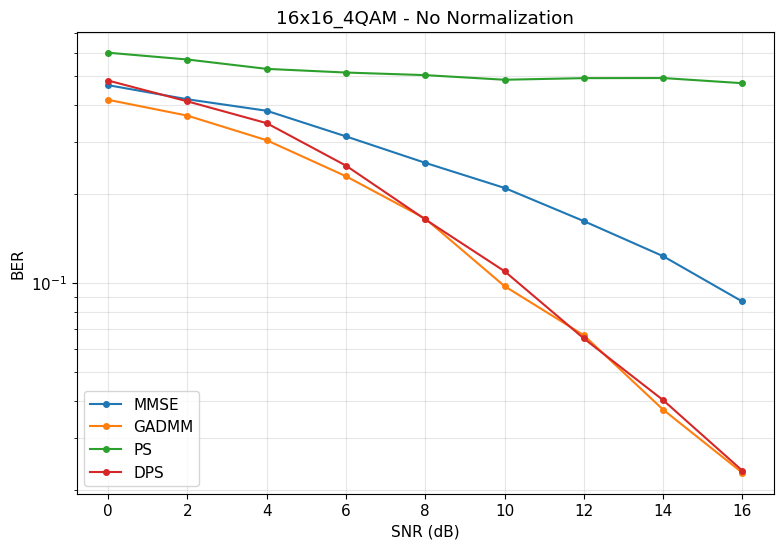

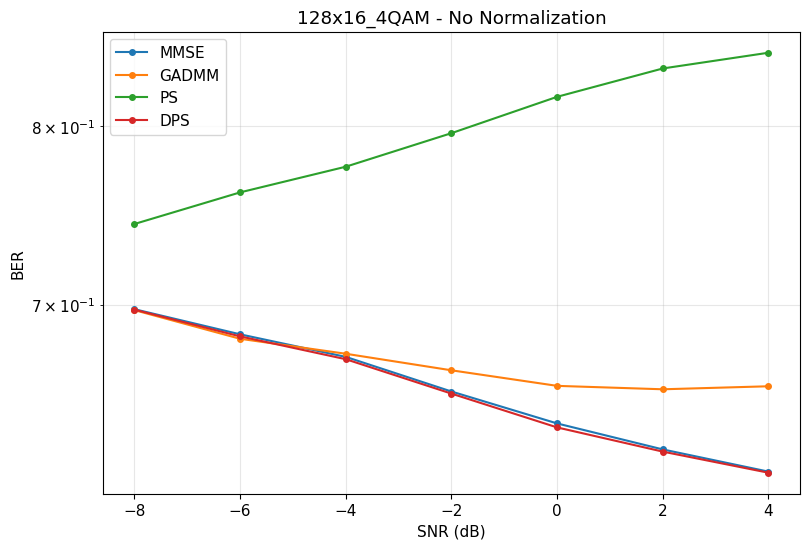

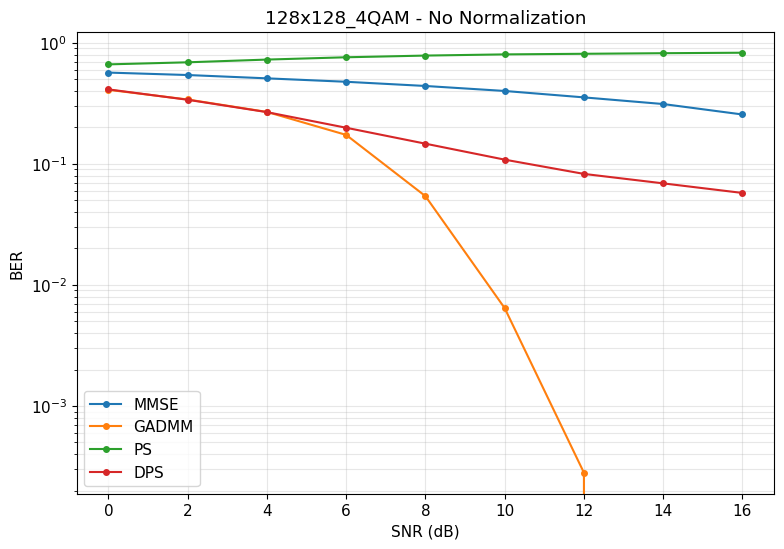

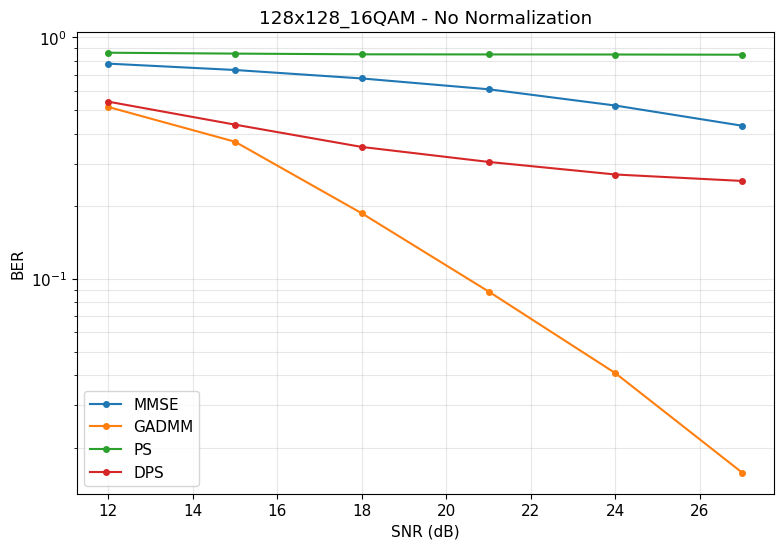

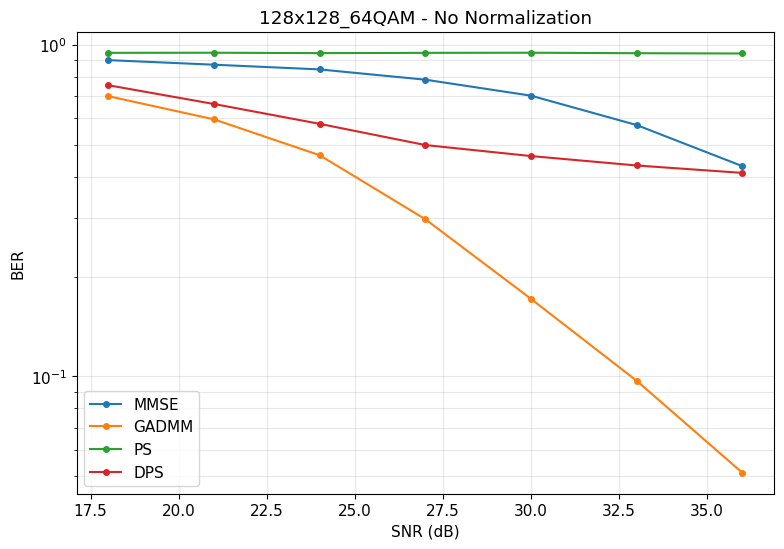

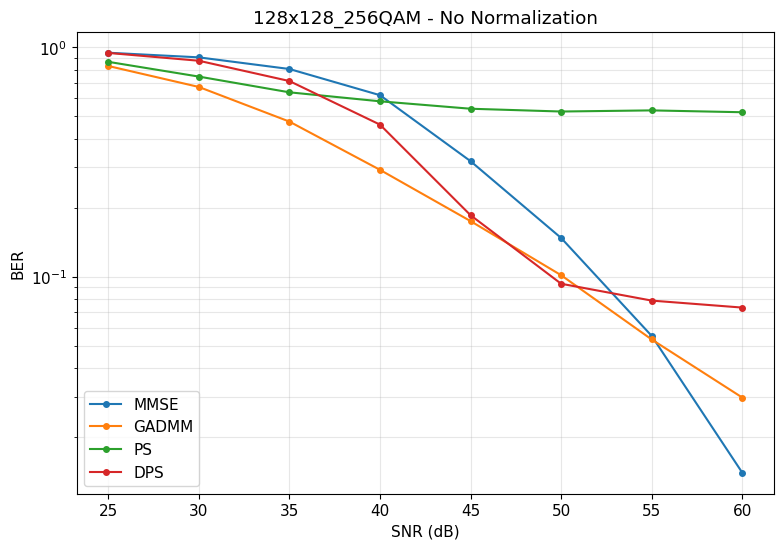

In [2]:
for name, res in all_results.items():
    plt.figure()
    for key in ['MMSE', 'GADMM', 'PS', 'DPS']:
        plt.semilogy(res['snr'], res[key], '-o', label=key, markersize=4)
    plt.title(f'{name} - No Normalization')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    plt.show()

## change PS and run trial accordingly

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from numpy.linalg import norm
from tqdm import tqdm
import time

np.random.seed(42)
plt.rcParams.update({'figure.figsize': (9,6), 'font.size': 11})

@dataclass
class ScalableConfig:
    U: int
    B: int
    modulation: str
    Q: int
    scenario_name: str = "scenario"

def get_constellation(modulation: str) -> Tuple[np.ndarray, float]:
    """Return normalized constellation points and normalization factor"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        a = np.array([-1, 1])
        normalization = np.sqrt(2)  # Average power = 1 for QPSK
    elif mod in ('16qam','16q'):
        a = np.array([-3, -1, 1, 3])
        normalization = np.sqrt(10)  # Average power = 10
    elif mod in ('64qam','64q'):
        a = np.arange(-7, 8, 2)  # -7, -5, -3, -1, 1, 3, 5, 7
        normalization = np.sqrt(42)  # Average power = 42
    elif mod in ('256qam','256q'):
        a = np.arange(-15, 16, 2)  # -15, -13, ..., 13, 15
        normalization = np.sqrt(170)  # Average power = 170
    else:
        raise ValueError("Unsupported modulation")

    pts = np.array([x + 1j*y for x in a for y in a])
    return pts / normalization, normalization

def get_constellation_bounds(modulation: str) -> Tuple[float, float]:
    """Get normalized box constraint bounds"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        return -1.0/np.sqrt(2), 1.0/np.sqrt(2)
    elif mod in ('16qam','16q'):
        return -3.0/np.sqrt(10), 3.0/np.sqrt(10)
    elif mod in ('64qam','64q'):
        return -7.0/np.sqrt(42), 7.0/np.sqrt(42)
    elif mod in ('256qam','256q'):
        return -15.0/np.sqrt(170), 15.0/np.sqrt(170)
    else:
        raise ValueError("Unsupported modulation")

def generate_channel(B: int, U: int) -> np.ndarray:
    """Generate Rayleigh MIMO channel (B x U)"""
    H = (np.random.randn(B, U) + 1j * np.random.randn(B, U)) / np.sqrt(2)
    return H

def add_awgn(y_clean: np.ndarray, snr_db: float) -> np.ndarray:
    """Add AWGN noise"""
    snr_lin = 10**(snr_db/10)
    sig_power = np.mean(np.abs(y_clean)**2)
    noise_power = sig_power / snr_lin
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

def quantize_to_constellation(x: np.ndarray, constellation: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Quantize to constellation points (soft projection)"""
    d = np.abs(x[:, None] - constellation[None, :])
    idx = np.argmin(d, axis=1)
    return constellation[idx], idx

def mmse_detector(r: np.ndarray, H: np.ndarray, constellation: np.ndarray, snr_db: float):
    """MMSE detector"""
    B, U = H.shape
    Hh = H.conj().T
    snr_lin = 10**(snr_db/10)
    A = Hh @ H + (1/snr_lin) * np.eye(U)
    x_hat = np.linalg.solve(A, Hh @ r)
    x_hard, idx = quantize_to_constellation(x_hat, constellation)
    return x_hat, x_hard, idx

class GeneralizedADMM:
    def __init__(self, constellation: np.ndarray, U: int):
        self.constellation = constellation
        self.U = U

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float,
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        """
        Standard ADMM formulation:
        x^{k+1} = argmin_x f(x) + (ρ/2)‖x - z^k + u^k‖²
        z^{k+1} = Π_C(x^{k+1} + u^k)  [Soft projection - quantization to constellation]
        u^{k+1} = u^k + x^{k+1} - z^{k+1}
        """
        U = self.U
        B = H.shape[0]

        # Precompute matrices for x-update
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x = np.zeros(U, dtype=complex)  # primal variable
        z = np.zeros(U, dtype=complex)  # auxiliary variable (constrained)
        u = np.zeros(U, dtype=complex)  # dual variable

        residuals = []

        # Standard ADMM iterations
        for k in range(max_iter):
            # Store previous values for convergence check
            x_prev = x.copy()
            z_prev = z.copy()

            # x-update: quadratic minimization
            # argmin_x (1/2)‖r - Hx‖² + (ρ/2)‖x - z + u‖²
            x = inv_matrix @ (H_H_r + rho * (z - u))

            # z-update: soft projection to constellation (quantization)
            # Π_C(x + u)
            z, _ = quantize_to_constellation(x + u, self.constellation)

            # u-update: dual variable update
            u = u + x - z

            # Convergence check
            primal_residual = norm(x - z)
            dual_residual = norm(rho * (z - z_prev))
            residual = primal_residual + dual_residual

            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[GADMM] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final hard decision (use z which satisfies constellation constraint)
        x_hard, idx = quantize_to_constellation(z, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x, x_hard, idx, info

class PSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int):
        self.constellation = constellation
        self.U = U
        self.Q = Q

    def project_to_box(self, x: np.ndarray):
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, -1, 1)
        x_imag = np.clip(x_imag, -1, 1)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 30, tol: float = 1e-5, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        # Precompute fixed matrices
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_mat = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x0 = np.zeros(U, dtype=complex)
        y = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Step 1: Sequential updates of x_q for q = 1 to Q
            for q in range(1, Q+1):
                numerator = 2 ** (q-1)

                # SAFETY CHECK: Use alpha[q-1] if available, else use 0.0
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                sum_before = sum((2 ** (i-1)) * x_q[i] for i in range(1, q))
                sum_after = sum((2 ** (i-1)) * x_q_prev[i] for i in range(q + 1, Q+1))

                inner = rho * x0 - rho * sum_before - rho * sum_after + y
                x_temp = (numerator / denominator) * inner
                x_q[q] = self.project_to_box(x_temp)

            # Step 2: Update x0
            sum_xq = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            x0_new = inv_mat @ (H_H_r + rho * sum_xq - y)

            # Step 3: Update Lagrange multiplier y
            y = y + rho * (x0_new - sum_xq)

            # Convergence check
            res_q = sum(norm(x_q[q] - x_q_prev[q]) ** 2 for q in range(1, Q+1))
            res_0 = norm(x0_new - x0) ** 2
            residual = res_q + res_0

            residuals.append(residual)
            x0 = x0_new

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[PS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final Hard Decision
        x_est = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

class DPSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int, modulation: str):
        self.constellation = constellation
        self.U = U
        self.Q = Q
        self.low, self.high = get_constellation_bounds(modulation)

    def project_to_box(self, x: np.ndarray):
        """Box projection for DPS-ADMM"""
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, self.low, self.high)
        x_imag = np.clip(x_imag, self.low, self.high)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(Q * H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x_bar = np.zeros(U, dtype=complex)
        z_bar = np.zeros(U, dtype=complex)
        u = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Parallel updates for x_q
            for q in range(1, Q+1):
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                numerator = 2 ** (q-1) * rho
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                inner_term = (2 ** (q-1)) * x_q_prev[q] + z_bar - x_bar - u
                x_temp = (numerator / denominator) * inner_term
                x_q[q] = self.project_to_box(x_temp)

            # Update x_bar and z_bar
            x_bar = (1.0 / Q) * sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            z_bar = inv_matrix @ (H_H_r + rho * (x_bar + u))
            u = u + x_bar - z_bar

            residual = sum(norm(x_q[q] - x_q_prev[q]) for q in range(1, Q+1))
            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[DPS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        x_est = Q * z_bar
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

def run_trial(cfg: ScalableConfig, constellation: np.ndarray, snr_db: float,
              rho: float, alpha: List[float]):
    """Run single trial with normalized constellation"""
    U, B = cfg.U, cfg.B

    # Generate true symbols (normalized)
    idx_true = np.random.randint(0, len(constellation), U)
    x_true = constellation[idx_true]

    # Generate channel and received signal
    H = generate_channel(B, U)
    y = add_awgn(H @ x_true, snr_db)

    results = {}

    # Run detectors
    _, _, idx_mmse = mmse_detector(y, H, constellation, snr_db)
    results['MMSE'] = idx_mmse

    gadmm = GeneralizedADMM(constellation, U)
    _, _, idx_g, info_g = gadmm.detect(y, H, rho, max_iter=100)
    results['GADMM'] = idx_g

    ps = PSADMM(constellation, U, cfg.Q)  # ← FIXED
    _, _, idx_p, info_p = ps.detect(y, H, rho, alpha, max_iter=100)
    results['PS'] = idx_p

    dps = DPSADMM(constellation, U, cfg.Q, cfg.modulation)
    _, _, idx_d, info_d = dps.detect(y, H, rho, alpha, max_iter=100)
    results['DPS'] = idx_d

    info_dict = {'PS': info_p, 'DPS': info_d, 'GADMM': info_g}

    return results, idx_true, info_dict


def monte_carlo(cfg: ScalableConfig, rho: float, alpha: List[float],
                snr_range: np.ndarray, trials: int = 200):
    """Run Monte Carlo simulations with normalized constellation"""
    constellation, norm_factor = get_constellation(cfg.modulation)
    print(f"Using normalized constellation for {cfg.modulation}, norm factor: {norm_factor:.3f}")

    results = {
        'snr': snr_range,
        'MMSE': [], 'GADMM': [], 'PS': [], 'DPS': []
    }

    for snr in tqdm(snr_range, desc=f"Running {cfg.scenario_name}"):
        ber = {'MMSE': 0, 'GADMM': 0, 'PS': 0, 'DPS': 0}

        for _ in range(trials):
            out, idx_true, _ = run_trial(cfg, constellation, snr, rho, alpha)
            for key in ber:
                ber[key] += np.mean(out[key] != idx_true)

        for key in ber:
            results[key].append(ber[key] / trials)

        print(f"SNR={snr:5.1f} dB → " +
              ", ".join(f"{k}:{results[k][-1]:.3e}" for k in ['MMSE', 'GADMM', 'PS', 'DPS']))

    return results

# Keep the original scenarios with the same rho and alpha values
scenarios = [
    (ScalableConfig(16, 16, '4QAM', 4, '16x16_4QAM'), 2.8, [1.3], np.arange(0, 17, 2)),
    (ScalableConfig(128, 16, '4QAM', 4, '128x16_4QAM'), 120, [80], np.arange(-8, 5, 2)),
    (ScalableConfig(128, 128, '4QAM', 4, '128x128_4QAM'), 120, [80], np.arange(0, 17, 2)),
    (ScalableConfig(128, 128, '16QAM', 4, '128x128_16QAM'), 16, [11, 53], np.arange(12, 29, 3)),
    (ScalableConfig(128, 128, '64QAM', 6, '128x128_64QAM'), 3.9, [2.17, 2.8, 10], np.arange(18, 39, 3)),
    (ScalableConfig(128, 128, '256QAM', 8, '128x128_256QAM'), 0.03, [0.01]*4, np.arange(25, 61, 5))
]

all_results = {}
for cfg, rho, alpha, snrs in scenarios:
    print(f"\n{'='*60}")
    print(f"Running {cfg.scenario_name}")
    print(f"Parameters: ρ={rho}, α={alpha}, Q={cfg.Q}")
    print(f"{'='*60}")

    all_results[cfg.scenario_name] = monte_carlo(cfg, rho, alpha, snrs, trials=500)


Running 16x16_4QAM
Parameters: ρ=2.8, α=[1.3], Q=4
Using normalized constellation for 4QAM, norm factor: 1.414


Running 16x16_4QAM:  11%|███████                                                         | 1/9 [00:03<00:31,  3.94s/it]

SNR=  0.0 dB → MMSE:4.657e-01, GADMM:4.156e-01, PS:6.286e-01, DPS:4.828e-01


Running 16x16_4QAM:  22%|██████████████▏                                                 | 2/9 [00:07<00:27,  3.93s/it]

SNR=  2.0 dB → MMSE:4.174e-01, GADMM:3.675e-01, PS:5.880e-01, DPS:4.106e-01


Running 16x16_4QAM:  33%|█████████████████████▎                                          | 3/9 [00:11<00:23,  3.94s/it]

SNR=  4.0 dB → MMSE:3.817e-01, GADMM:3.035e-01, PS:5.584e-01, DPS:3.466e-01


Running 16x16_4QAM:  44%|████████████████████████████▍                                   | 4/9 [00:15<00:19,  3.91s/it]

SNR=  6.0 dB → MMSE:3.127e-01, GADMM:2.294e-01, PS:4.921e-01, DPS:2.491e-01


Running 16x16_4QAM:  56%|███████████████████████████████████▌                            | 5/9 [00:19<00:15,  3.88s/it]

SNR=  8.0 dB → MMSE:2.546e-01, GADMM:1.650e-01, PS:4.093e-01, DPS:1.640e-01


Running 16x16_4QAM:  67%|██████████████████████████████████████████▋                     | 6/9 [00:23<00:11,  3.85s/it]

SNR= 10.0 dB → MMSE:2.095e-01, GADMM:9.763e-02, PS:3.386e-01, DPS:1.096e-01


Running 16x16_4QAM:  78%|█████████████████████████████████████████████████▊              | 7/9 [00:27<00:07,  3.82s/it]

SNR= 12.0 dB → MMSE:1.619e-01, GADMM:6.663e-02, PS:2.466e-01, DPS:6.500e-02


Running 16x16_4QAM:  89%|████████████████████████████████████████████████████████▉       | 8/9 [00:30<00:03,  3.79s/it]

SNR= 14.0 dB → MMSE:1.232e-01, GADMM:3.737e-02, PS:1.809e-01, DPS:4.025e-02


Running 16x16_4QAM: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.83s/it]


SNR= 16.0 dB → MMSE:8.662e-02, GADMM:2.287e-02, PS:1.095e-01, DPS:2.325e-02

Running 128x16_4QAM
Parameters: ρ=120, α=[80], Q=4
Using normalized constellation for 4QAM, norm factor: 1.414


Running 128x16_4QAM:  14%|█████████                                                      | 1/7 [00:02<00:13,  2.22s/it]

SNR= -8.0 dB → MMSE:6.976e-01, GADMM:6.971e-01, PS:6.976e-01, DPS:6.974e-01


Running 128x16_4QAM:  29%|██████████████████                                             | 2/7 [00:04<00:11,  2.21s/it]

SNR= -6.0 dB → MMSE:6.846e-01, GADMM:6.823e-01, PS:6.850e-01, DPS:6.835e-01


Running 128x16_4QAM:  43%|███████████████████████████                                    | 3/7 [00:06<00:08,  2.16s/it]

SNR= -4.0 dB → MMSE:6.731e-01, GADMM:6.747e-01, PS:6.733e-01, DPS:6.720e-01


Running 128x16_4QAM:  57%|████████████████████████████████████                           | 4/7 [00:08<00:06,  2.17s/it]

SNR= -2.0 dB → MMSE:6.559e-01, GADMM:6.664e-01, PS:6.558e-01, DPS:6.549e-01


Running 128x16_4QAM:  71%|█████████████████████████████████████████████                  | 5/7 [00:10<00:04,  2.14s/it]

SNR=  0.0 dB → MMSE:6.404e-01, GADMM:6.587e-01, PS:6.405e-01, DPS:6.385e-01


Running 128x16_4QAM:  86%|██████████████████████████████████████████████████████         | 6/7 [00:12<00:02,  2.10s/it]

SNR=  2.0 dB → MMSE:6.280e-01, GADMM:6.570e-01, PS:6.282e-01, DPS:6.270e-01


Running 128x16_4QAM: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.12s/it]


SNR=  4.0 dB → MMSE:6.177e-01, GADMM:6.585e-01, PS:6.176e-01, DPS:6.172e-01

Running 128x128_4QAM
Parameters: ρ=120, α=[80], Q=4
Using normalized constellation for 4QAM, norm factor: 1.414


Running 128x128_4QAM:  11%|██████▉                                                       | 1/9 [00:07<01:01,  7.67s/it]

SNR=  0.0 dB → MMSE:5.675e-01, GADMM:4.090e-01, PS:5.791e-01, DPS:4.124e-01


Running 128x128_4QAM:  22%|█████████████▊                                                | 2/9 [00:15<00:55,  7.86s/it]

SNR=  2.0 dB → MMSE:5.418e-01, GADMM:3.402e-01, PS:5.339e-01, DPS:3.385e-01


Running 128x128_4QAM:  33%|████████████████████▋                                         | 3/9 [00:23<00:46,  7.77s/it]

SNR=  4.0 dB → MMSE:5.086e-01, GADMM:2.686e-01, PS:4.724e-01, DPS:2.675e-01


Running 128x128_4QAM:  44%|███████████████████████████▌                                  | 4/9 [00:30<00:38,  7.73s/it]

SNR=  6.0 dB → MMSE:4.765e-01, GADMM:1.735e-01, PS:3.998e-01, DPS:1.988e-01


Running 128x128_4QAM:  56%|██████████████████████████████████▍                           | 5/9 [00:38<00:30,  7.55s/it]

SNR=  8.0 dB → MMSE:4.399e-01, GADMM:5.414e-02, PS:3.152e-01, DPS:1.468e-01


Running 128x128_4QAM:  67%|█████████████████████████████████████████▎                    | 6/9 [00:45<00:22,  7.40s/it]

SNR= 10.0 dB → MMSE:4.001e-01, GADMM:6.437e-03, PS:2.324e-01, DPS:1.084e-01


Running 128x128_4QAM:  78%|████████████████████████████████████████████████▏             | 7/9 [00:52<00:14,  7.36s/it]

SNR= 12.0 dB → MMSE:3.541e-01, GADMM:2.812e-04, PS:1.423e-01, DPS:8.263e-02


Running 128x128_4QAM:  89%|███████████████████████████████████████████████████████       | 8/9 [00:59<00:07,  7.36s/it]

SNR= 14.0 dB → MMSE:3.120e-01, GADMM:0.000e+00, PS:7.753e-02, DPS:6.902e-02


Running 128x128_4QAM: 100%|██████████████████████████████████████████████████████████████| 9/9 [01:07<00:00,  7.45s/it]


SNR= 16.0 dB → MMSE:2.557e-01, GADMM:0.000e+00, PS:3.291e-02, DPS:5.752e-02

Running 128x128_16QAM
Parameters: ρ=16, α=[11, 53], Q=4
Using normalized constellation for 16QAM, norm factor: 3.162


Running 128x128_16QAM:  17%|██████████▏                                                  | 1/6 [00:08<00:42,  8.46s/it]

SNR= 12.0 dB → MMSE:7.790e-01, GADMM:5.154e-01, PS:7.566e-01, DPS:5.421e-01


Running 128x128_16QAM:  33%|████████████████████▎                                        | 2/6 [00:17<00:34,  8.57s/it]

SNR= 15.0 dB → MMSE:7.332e-01, GADMM:3.699e-01, PS:6.662e-01, DPS:4.354e-01


Running 128x128_16QAM:  50%|██████████████████████████████▌                              | 3/6 [00:25<00:25,  8.55s/it]

SNR= 18.0 dB → MMSE:6.763e-01, GADMM:1.869e-01, PS:5.191e-01, DPS:3.519e-01


Running 128x128_16QAM:  67%|████████████████████████████████████████▋                    | 4/6 [00:33<00:16,  8.15s/it]

SNR= 21.0 dB → MMSE:6.100e-01, GADMM:8.864e-02, PS:3.511e-01, DPS:3.051e-01


Running 128x128_16QAM:  83%|██████████████████████████████████████████████████▊          | 5/6 [00:40<00:07,  7.78s/it]

SNR= 24.0 dB → MMSE:5.223e-01, GADMM:4.067e-02, PS:1.912e-01, DPS:2.706e-01


Running 128x128_16QAM: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:47<00:00,  7.98s/it]


SNR= 27.0 dB → MMSE:4.308e-01, GADMM:1.575e-02, PS:7.592e-02, DPS:2.545e-01

Running 128x128_64QAM
Parameters: ρ=3.9, α=[2.17, 2.8, 10], Q=6
Using normalized constellation for 64QAM, norm factor: 6.481


Running 128x128_64QAM:  14%|████████▋                                                    | 1/7 [00:10<01:03, 10.57s/it]

SNR= 18.0 dB → MMSE:8.998e-01, GADMM:7.005e-01, PS:8.890e-01, DPS:7.558e-01


Running 128x128_64QAM:  29%|█████████████████▍                                           | 2/7 [00:21<00:52, 10.49s/it]

SNR= 21.0 dB → MMSE:8.717e-01, GADMM:5.963e-01, PS:8.311e-01, DPS:6.634e-01


Running 128x128_64QAM:  43%|██████████████████████████▏                                  | 3/7 [00:30<00:40, 10.21s/it]

SNR= 24.0 dB → MMSE:8.436e-01, GADMM:4.648e-01, PS:7.423e-01, DPS:5.780e-01


Running 128x128_64QAM:  57%|██████████████████████████████████▊                          | 4/7 [00:40<00:30, 10.15s/it]

SNR= 27.0 dB → MMSE:7.855e-01, GADMM:2.980e-01, PS:5.986e-01, DPS:4.988e-01


Running 128x128_64QAM:  71%|███████████████████████████████████████████▌                 | 5/7 [00:50<00:19, 10.00s/it]

SNR= 30.0 dB → MMSE:7.030e-01, GADMM:1.713e-01, PS:4.343e-01, DPS:4.620e-01


Running 128x128_64QAM:  86%|████████████████████████████████████████████████████▎        | 6/7 [01:01<00:10, 10.27s/it]

SNR= 33.0 dB → MMSE:5.731e-01, GADMM:9.698e-02, PS:2.662e-01, DPS:4.327e-01


Running 128x128_64QAM: 100%|█████████████████████████████████████████████████████████████| 7/7 [01:11<00:00, 10.28s/it]


SNR= 36.0 dB → MMSE:4.308e-01, GADMM:5.119e-02, PS:1.410e-01, DPS:4.110e-01

Running 128x128_256QAM
Parameters: ρ=0.03, α=[0.01, 0.01, 0.01, 0.01], Q=8
Using normalized constellation for 256QAM, norm factor: 13.038


Running 128x128_256QAM:  12%|███████▌                                                    | 1/8 [00:16<01:52, 16.06s/it]

SNR= 25.0 dB → MMSE:9.475e-01, GADMM:8.294e-01, PS:9.649e-01, DPS:9.456e-01


Running 128x128_256QAM:  25%|███████████████                                             | 2/8 [00:32<01:37, 16.22s/it]

SNR= 30.0 dB → MMSE:9.045e-01, GADMM:6.720e-01, PS:9.205e-01, DPS:8.742e-01


Running 128x128_256QAM:  38%|██████████████████████▌                                     | 3/8 [00:48<01:19, 15.98s/it]

SNR= 35.0 dB → MMSE:8.047e-01, GADMM:4.747e-01, PS:8.149e-01, DPS:7.131e-01


Running 128x128_256QAM:  50%|██████████████████████████████                              | 4/8 [01:04<01:04, 16.05s/it]

SNR= 40.0 dB → MMSE:6.187e-01, GADMM:2.925e-01, PS:6.188e-01, DPS:4.604e-01


Running 128x128_256QAM:  62%|█████████████████████████████████████▌                      | 5/8 [01:21<00:49, 16.52s/it]

SNR= 45.0 dB → MMSE:3.190e-01, GADMM:1.748e-01, PS:3.084e-01, DPS:1.855e-01


Running 128x128_256QAM:  75%|█████████████████████████████████████████████               | 6/8 [01:37<00:32, 16.25s/it]

SNR= 50.0 dB → MMSE:1.476e-01, GADMM:1.015e-01, PS:1.255e-01, DPS:9.320e-02


Running 128x128_256QAM:  88%|████████████████████████████████████████████████████▌       | 7/8 [01:53<00:16, 16.30s/it]

SNR= 55.0 dB → MMSE:5.520e-02, GADMM:5.327e-02, PS:3.698e-02, DPS:7.870e-02


Running 128x128_256QAM: 100%|████████████████████████████████████████████████████████████| 8/8 [02:10<00:00, 16.28s/it]

SNR= 60.0 dB → MMSE:1.398e-02, GADMM:2.973e-02, PS:8.125e-03, DPS:7.337e-02


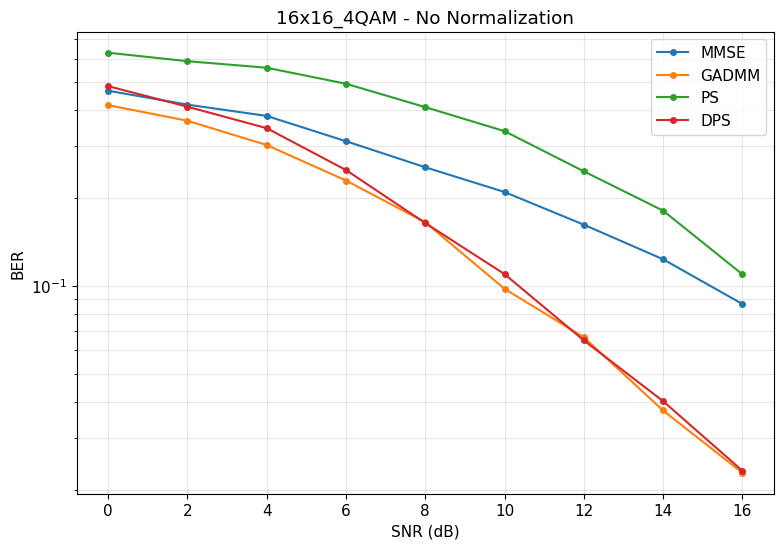

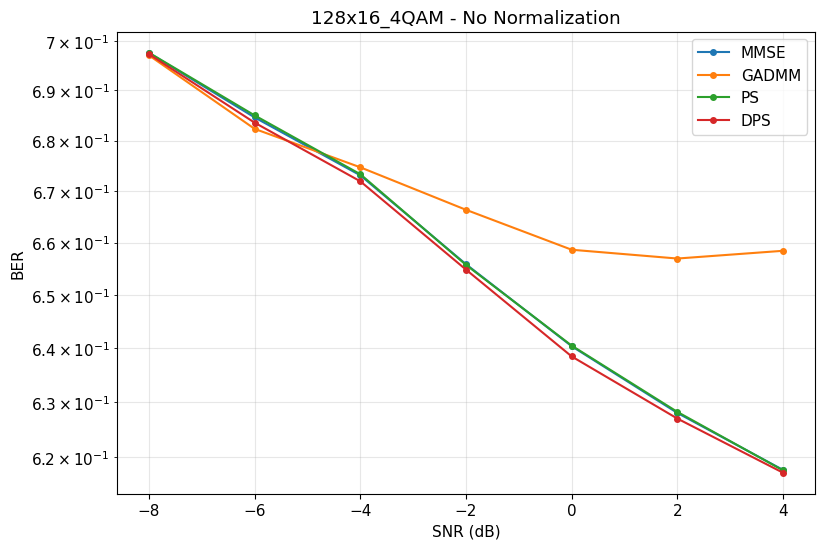

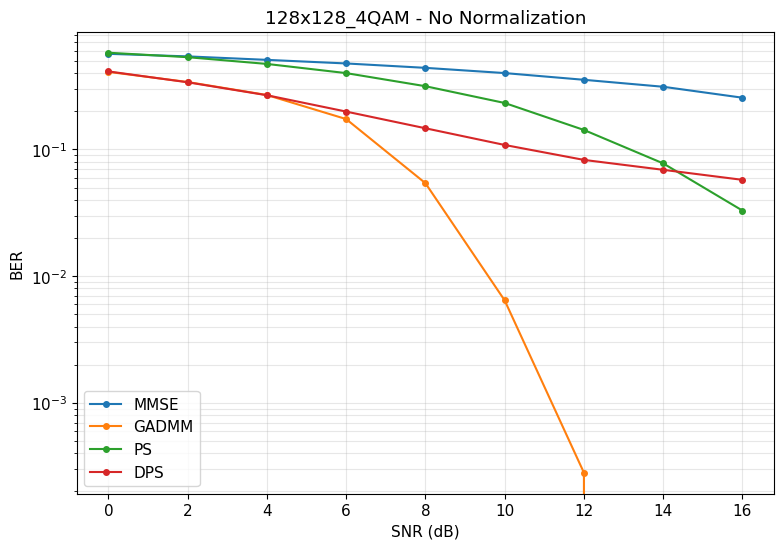

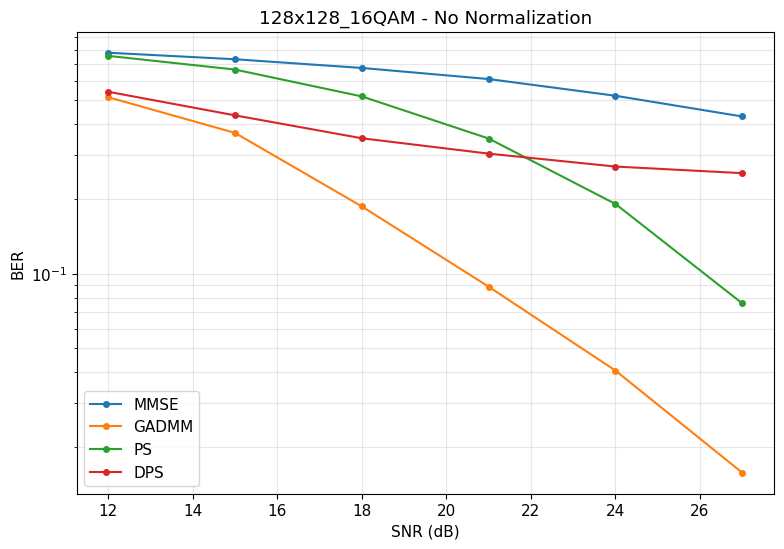

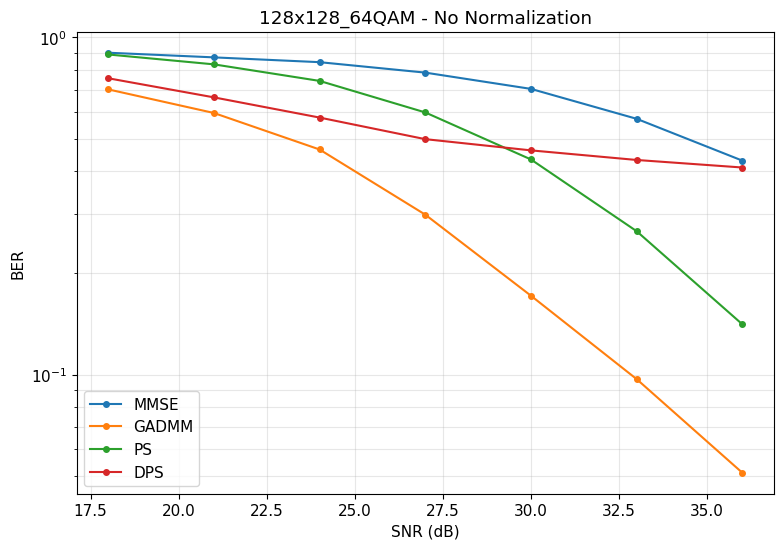

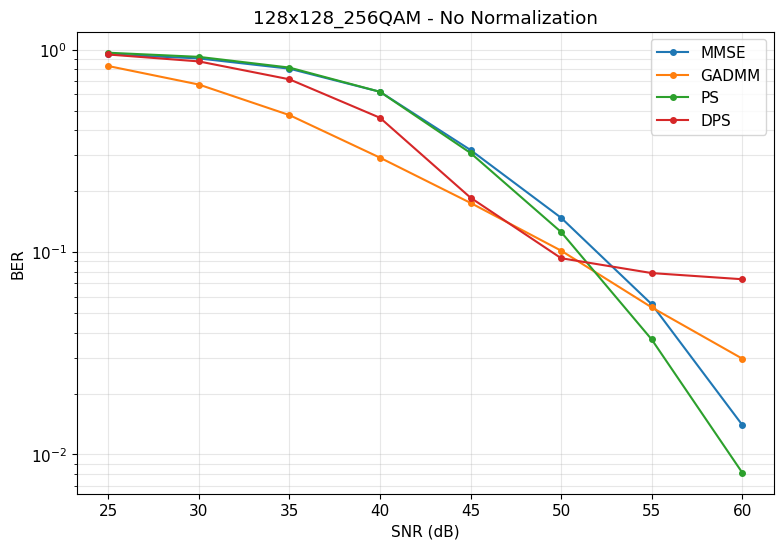

In [5]:
for name, res in all_results.items():
    plt.figure()
    for key in ['MMSE', 'GADMM', 'PS', 'DPS']:
        plt.semilogy(res['snr'], res[key], '-o', label=key, markersize=4)
    plt.title(f'{name} - No Normalization')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    plt.show()


Running 16x16_4QAM

🔍 Starting PS-ADMM parameter search for 16x16_4QAM
SNR=12dB, trials per point=300
Channel λ_max: 52.7972, ρ_min bound: 10.2759
  Rho progress: 1/12
  Rho progress: 2/12
  Rho progress: 3/12
  Rho progress: 4/12
  Rho progress: 5/12
  Rho progress: 6/12
  Rho progress: 7/12
  Rho progress: 8/12
  Rho progress: 9/12
  Rho progress: 10/12
  Rho progress: 11/12
  Rho progress: 12/12
❌ No valid parameters found, using defaults
Using optimized parameters: ρ=2.000, α=[1.0]
Using normalized constellation for 4QAM, norm factor: 1.414


Running 16x16_4QAM:  11%|███████                                                         | 1/9 [00:01<00:11,  1.48s/it]

SNR=  0.0 dB → MMSE:4.555e-01, GADMM:4.103e-01, PS:5.381e-01, DPS:4.555e-01


Running 16x16_4QAM:  22%|██████████████▏                                                 | 2/9 [00:03<00:10,  1.55s/it]

SNR=  2.0 dB → MMSE:4.139e-01, GADMM:3.638e-01, PS:5.148e-01, DPS:3.919e-01


Running 16x16_4QAM:  33%|█████████████████████▎                                          | 3/9 [00:05<00:10,  1.82s/it]

SNR=  4.0 dB → MMSE:3.676e-01, GADMM:2.988e-01, PS:4.866e-01, DPS:3.110e-01


Running 16x16_4QAM:  44%|████████████████████████████▍                                   | 4/9 [00:07<00:09,  1.83s/it]

SNR=  6.0 dB → MMSE:3.171e-01, GADMM:2.311e-01, PS:4.429e-01, DPS:2.311e-01


Running 16x16_4QAM:  56%|███████████████████████████████████▌                            | 5/9 [00:08<00:07,  1.86s/it]

SNR=  8.0 dB → MMSE:2.544e-01, GADMM:1.750e-01, PS:3.846e-01, DPS:1.477e-01


Running 16x16_4QAM:  67%|██████████████████████████████████████████▋                     | 6/9 [00:10<00:05,  1.89s/it]

SNR= 10.0 dB → MMSE:2.096e-01, GADMM:1.215e-01, PS:3.252e-01, DPS:1.040e-01


Running 16x16_4QAM:  78%|█████████████████████████████████████████████████▊              | 7/9 [00:12<00:03,  1.92s/it]

SNR= 12.0 dB → MMSE:1.585e-01, GADMM:8.550e-02, PS:2.511e-01, DPS:6.200e-02


Running 16x16_4QAM:  89%|████████████████████████████████████████████████████████▉       | 8/9 [00:14<00:01,  1.95s/it]

SNR= 14.0 dB → MMSE:1.231e-01, GADMM:5.700e-02, PS:1.961e-01, DPS:3.687e-02


Running 16x16_4QAM: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.88s/it]


SNR= 16.0 dB → MMSE:9.087e-02, GADMM:3.587e-02, PS:1.289e-01, DPS:2.425e-02

Running 128x16_4QAM
Using default parameters: ρ=120, α=[80]
Using normalized constellation for 4QAM, norm factor: 1.414


Running 128x16_4QAM:  14%|█████████                                                      | 1/7 [00:01<00:10,  1.72s/it]

SNR= -8.0 dB → MMSE:6.969e-01, GADMM:6.953e-01, PS:6.972e-01, DPS:6.955e-01


Running 128x16_4QAM:  29%|██████████████████                                             | 2/7 [00:03<00:08,  1.68s/it]

SNR= -6.0 dB → MMSE:6.893e-01, GADMM:6.874e-01, PS:6.895e-01, DPS:6.881e-01


Running 128x16_4QAM:  43%|███████████████████████████                                    | 3/7 [00:04<00:06,  1.62s/it]

SNR= -4.0 dB → MMSE:6.737e-01, GADMM:6.724e-01, PS:6.738e-01, DPS:6.701e-01


Running 128x16_4QAM:  57%|████████████████████████████████████                           | 4/7 [00:06<00:04,  1.57s/it]

SNR= -2.0 dB → MMSE:6.547e-01, GADMM:6.631e-01, PS:6.549e-01, DPS:6.529e-01


Running 128x16_4QAM:  71%|█████████████████████████████████████████████                  | 5/7 [00:07<00:03,  1.53s/it]

SNR=  0.0 dB → MMSE:6.440e-01, GADMM:6.602e-01, PS:6.440e-01, DPS:6.413e-01


Running 128x16_4QAM:  86%|██████████████████████████████████████████████████████         | 6/7 [00:09<00:01,  1.53s/it]

SNR=  2.0 dB → MMSE:6.283e-01, GADMM:6.591e-01, PS:6.285e-01, DPS:6.271e-01


Running 128x16_4QAM: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.56s/it]


SNR=  4.0 dB → MMSE:6.169e-01, GADMM:6.552e-01, PS:6.169e-01, DPS:6.163e-01

Running 128x128_4QAM
Using default parameters: ρ=120, α=[80]
Using normalized constellation for 4QAM, norm factor: 1.414


Running 128x128_4QAM:  11%|██████▉                                                       | 1/9 [00:05<00:41,  5.16s/it]

SNR=  0.0 dB → MMSE:5.687e-01, GADMM:4.069e-01, PS:5.407e-01, DPS:3.892e-01


Running 128x128_4QAM:  22%|█████████████▊                                                | 2/9 [00:09<00:34,  4.96s/it]

SNR=  2.0 dB → MMSE:5.409e-01, GADMM:3.417e-01, PS:5.019e-01, DPS:3.237e-01


Running 128x128_4QAM:  33%|████████████████████▋                                         | 3/9 [00:14<00:28,  4.80s/it]

SNR=  4.0 dB → MMSE:5.121e-01, GADMM:2.650e-01, PS:4.507e-01, DPS:2.605e-01


Running 128x128_4QAM:  44%|███████████████████████████▌                                  | 4/9 [00:19<00:23,  4.75s/it]

SNR=  6.0 dB → MMSE:4.818e-01, GADMM:1.745e-01, PS:3.907e-01, DPS:2.088e-01


Running 128x128_4QAM:  56%|██████████████████████████████████▍                           | 5/9 [00:24<00:19,  4.98s/it]

SNR=  8.0 dB → MMSE:4.377e-01, GADMM:5.744e-02, PS:3.107e-01, DPS:1.639e-01


Running 128x128_4QAM:  67%|█████████████████████████████████████████▎                    | 6/9 [00:29<00:14,  4.77s/it]

SNR= 10.0 dB → MMSE:4.027e-01, GADMM:4.875e-03, PS:2.250e-01, DPS:1.365e-01


Running 128x128_4QAM:  78%|████████████████████████████████████████████████▏             | 7/9 [00:33<00:09,  4.74s/it]

SNR= 12.0 dB → MMSE:3.626e-01, GADMM:1.250e-04, PS:1.461e-01, DPS:1.128e-01


Running 128x128_4QAM:  89%|███████████████████████████████████████████████████████       | 8/9 [00:38<00:04,  4.67s/it]

SNR= 14.0 dB → MMSE:3.030e-01, GADMM:1.563e-05, PS:7.459e-02, DPS:1.009e-01


Running 128x128_4QAM: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.77s/it]

SNR= 16.0 dB → MMSE:2.561e-01, GADMM:0.000e+00, PS:3.363e-02, DPS:9.258e-02


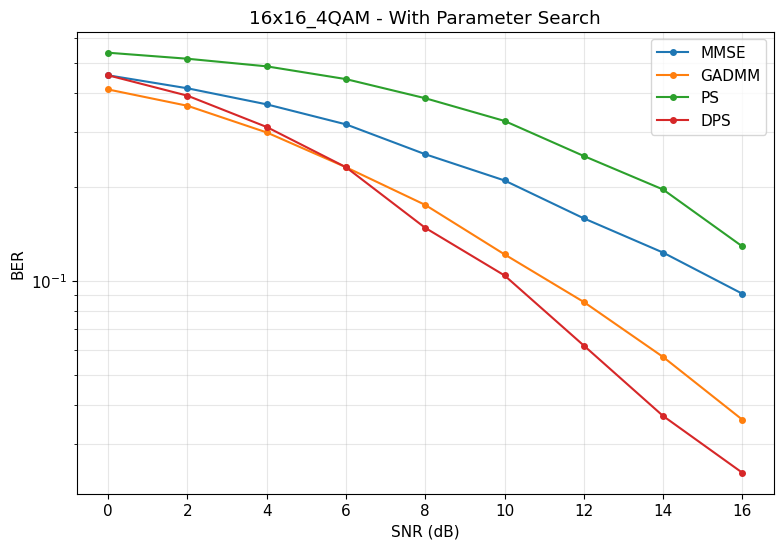

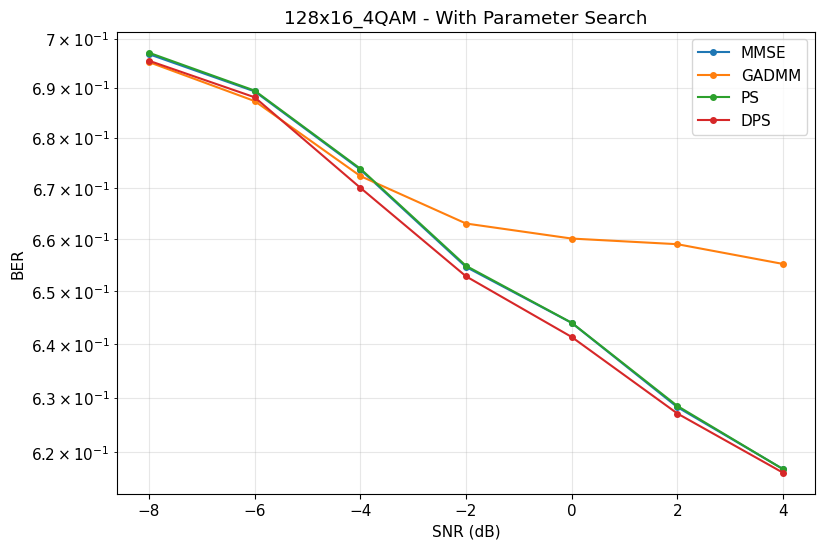

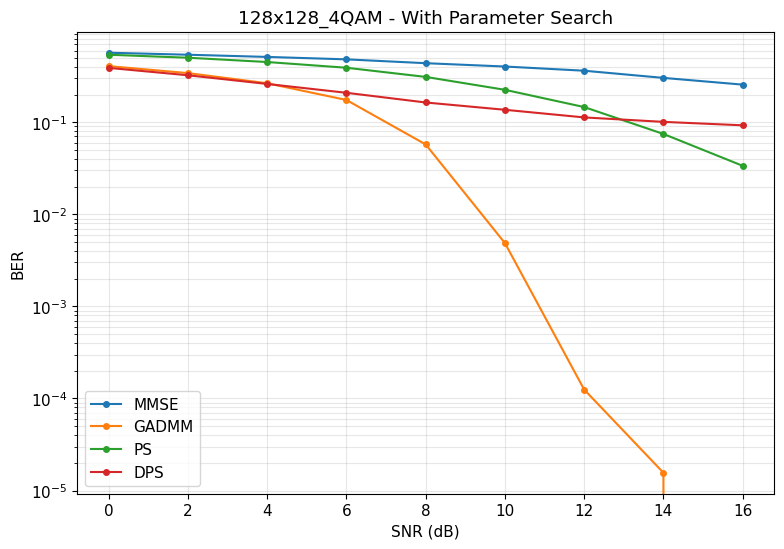

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from numpy.linalg import norm, eigvals, solve
from tqdm import tqdm
import time

np.random.seed(42)
plt.rcParams.update({'figure.figsize': (9,6), 'font.size': 11})

@dataclass
class ScalableConfig:
    U: int
    B: int
    modulation: str
    Q: int
    scenario_name: str = "scenario"

def get_constellation(modulation: str) -> Tuple[np.ndarray, float]:
    """Return normalized constellation points and normalization factor"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        a = np.array([-1, 1])
        normalization = np.sqrt(2)  # Average power = 1 for QPSK
    elif mod in ('16qam','16q'):
        a = np.array([-3, -1, 1, 3])
        normalization = np.sqrt(10)  # Average power = 10
    elif mod in ('64qam','64q'):
        a = np.arange(-7, 8, 2)  # -7, -5, -3, -1, 1, 3, 5, 7
        normalization = np.sqrt(42)  # Average power = 42
    elif mod in ('256qam','256q'):
        a = np.arange(-15, 16, 2)  # -15, -13, ..., 13, 15
        normalization = np.sqrt(170)  # Average power = 170
    else:
        raise ValueError("Unsupported modulation")

    pts = np.array([x + 1j*y for x in a for y in a])
    return pts / normalization, normalization

def get_constellation_bounds(modulation: str) -> Tuple[float, float]:
    """Get normalized box constraint bounds"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        return -1.0/np.sqrt(2), 1.0/np.sqrt(2)
    elif mod in ('16qam','16q'):
        return -3.0/np.sqrt(10), 3.0/np.sqrt(10)
    elif mod in ('64qam','64q'):
        return -7.0/np.sqrt(42), 7.0/np.sqrt(42)
    elif mod in ('256qam','256q'):
        return -15.0/np.sqrt(170), 15.0/np.sqrt(170)
    else:
        raise ValueError("Unsupported modulation")

def generate_channel(B: int, U: int) -> np.ndarray:
    """Generate Rayleigh MIMO channel (B x U)"""
    H = (np.random.randn(B, U) + 1j * np.random.randn(B, U)) / np.sqrt(2)
    return H

def add_awgn(y_clean: np.ndarray, snr_db: float) -> np.ndarray:
    """Add AWGN noise"""
    snr_lin = 10**(snr_db/10)
    sig_power = np.mean(np.abs(y_clean)**2)
    noise_power = sig_power / snr_lin
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

def quantize_to_constellation(x: np.ndarray, constellation: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Quantize to constellation points (soft projection)"""
    d = np.abs(x[:, None] - constellation[None, :])
    idx = np.argmin(d, axis=1)
    return constellation[idx], idx

def mmse_detector(r: np.ndarray, H: np.ndarray, constellation: np.ndarray, snr_db: float):
    """MMSE detector"""
    B, U = H.shape
    Hh = H.conj().T
    snr_lin = 10**(snr_db/10)
    A = Hh @ H + (1/snr_lin) * np.eye(U)
    x_hat = np.linalg.solve(A, Hh @ r)
    x_hard, idx = quantize_to_constellation(x_hat, constellation)
    return x_hat, x_hard, idx

class GeneralizedADMM:
    def __init__(self, constellation: np.ndarray, U: int):
        self.constellation = constellation
        self.U = U

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float,
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        """
        Standard ADMM formulation:
        x^{k+1} = argmin_x f(x) + (ρ/2)‖x - z^k + u^k‖²
        z^{k+1} = Π_C(x^{k+1} + u^k)  [Soft projection - quantization to constellation]
        u^{k+1} = u^k + x^{k+1} - z^{k+1}
        """
        U = self.U
        B = H.shape[0]

        # Precompute matrices for x-update
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x = np.zeros(U, dtype=complex)  # primal variable
        z = np.zeros(U, dtype=complex)  # auxiliary variable (constrained)
        u = np.zeros(U, dtype=complex)  # dual variable

        residuals = []

        # Standard ADMM iterations
        for k in range(max_iter):
            # Store previous values for convergence check
            x_prev = x.copy()
            z_prev = z.copy()

            # x-update: quadratic minimization
            # argmin_x (1/2)‖r - Hx‖² + (ρ/2)‖x - z + u‖²
            x = inv_matrix @ (H_H_r + rho * (z - u))

            # z-update: soft projection to constellation (quantization)
            # Π_C(x + u)
            z, _ = quantize_to_constellation(x + u, self.constellation)

            # u-update: dual variable update
            u = u + x - z

            # Convergence check
            primal_residual = norm(x - z)
            dual_residual = norm(rho * (z - z_prev))
            residual = primal_residual + dual_residual

            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[GADMM] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final hard decision (use z which satisfies constellation constraint)
        x_hard, idx = quantize_to_constellation(z, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x, x_hard, idx, info

class PSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int):
        self.constellation = constellation
        self.U = U
        self.Q = Q

    def project_to_box(self, x: np.ndarray):
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, -1, 1)
        x_imag = np.clip(x_imag, -1, 1)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 30, tol: float = 1e-5, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        # Precompute fixed matrices
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_mat = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x0 = np.zeros(U, dtype=complex)
        y = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Step 1: Sequential updates of x_q for q = 1 to Q
            for q in range(1, Q+1):
                numerator = 2 ** (q-1)

                # SAFETY CHECK: Use alpha[q-1] if available, else use 0.0
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                sum_before = sum((2 ** (i-1)) * x_q[i] for i in range(1, q))
                sum_after = sum((2 ** (i-1)) * x_q_prev[i] for i in range(q + 1, Q+1))

                inner = rho * x0 - rho * sum_before - rho * sum_after + y
                x_temp = (numerator / denominator) * inner
                x_q[q] = self.project_to_box(x_temp)

            # Step 2: Update x0
            sum_xq = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            x0_new = inv_mat @ (H_H_r + rho * sum_xq - y)

            # Step 3: Update Lagrange multiplier y
            y = y + rho * (x0_new - sum_xq)

            # Convergence check
            res_q = sum(norm(x_q[q] - x_q_prev[q]) ** 2 for q in range(1, Q+1))
            res_0 = norm(x0_new - x0) ** 2
            residual = res_q + res_0

            residuals.append(residual)
            x0 = x0_new

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[PS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final Hard Decision
        x_est = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

class DPSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int, modulation: str):
        self.constellation = constellation
        self.U = U
        self.Q = Q
        self.low, self.high = get_constellation_bounds(modulation)

    def project_to_box(self, x: np.ndarray):
        """Box projection for DPS-ADMM"""
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, self.low, self.high)
        x_imag = np.clip(x_imag, self.low, self.high)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(Q * H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x_bar = np.zeros(U, dtype=complex)
        z_bar = np.zeros(U, dtype=complex)
        u = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Parallel updates for x_q
            for q in range(1, Q+1):
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                numerator = 2 ** (q-1) * rho
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                inner_term = (2 ** (q-1)) * x_q_prev[q] + z_bar - x_bar - u
                x_temp = (numerator / denominator) * inner_term
                x_q[q] = self.project_to_box(x_temp)

            # Update x_bar and z_bar
            x_bar = (1.0 / Q) * sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            z_bar = inv_matrix @ (H_H_r + rho * (x_bar + u))
            u = u + x_bar - z_bar

            residual = sum(norm(x_q[q] - x_q_prev[q]) for q in range(1, Q+1))
            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[DPS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        x_est = Q * z_bar
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

# ======================================================
# PARAMETER SEARCH FOR PS-ADMM
# ======================================================
def psadmm_parameter_search(cfg: ScalableConfig, constellation: np.ndarray, 
                           snr_db_search: float = 16, trials_per_point: int = 500):
    """Parameter search for PS-ADMM optimal rho and alpha"""
    print(f"\n🔍 Starting PS-ADMM parameter search for {cfg.scenario_name}")
    print(f"SNR={snr_db_search}dB, trials per point={trials_per_point}")
    
    # Parameter search ranges
    GRID_RHO_POINTS = 12
    GRID_ALPHA_POINTS = 12
    
    # Generate a fixed test channel for consistent evaluation
    H_fixed = generate_channel(cfg.B, cfg.U)
    lam_max = np.max(np.real(eigvals(H_fixed.conj().T @ H_fixed)))
    rho_min_bound = np.sqrt(2 * lam_max)
    
    print(f"Channel λ_max: {lam_max:.4f}, ρ_min bound: {rho_min_bound:.4f}")
    
    # Define search ranges
    rho_lo = max(rho_min_bound * 1.1, 0.1)
    rho_hi = max(rho_min_bound * 8.0, 2.0)
    rho_grid = np.linspace(rho_lo, rho_hi, GRID_RHO_POINTS)
    alpha_frac_grid = np.linspace(0.05, 0.95, GRID_ALPHA_POINTS)
    
    BER_grid = np.full((len(rho_grid), len(alpha_frac_grid)), np.nan)
    convergence_grid = np.full_like(BER_grid, np.nan)
    
    ps_detector = PSADMM(constellation, cfg.U, cfg.Q)
    
    start_time = time.time()
    
    for i_r, rho in enumerate(rho_grid):
        for j_a, alpha_frac in enumerate(alpha_frac_grid):
            alpha_val = [alpha_frac * rho]  # For Q=1 in 4-QAM
            
            # Check theorem conditions
            if not (rho > alpha_val[0]) or not (rho > rho_min_bound):
                continue
                
            bit_errors = 0
            total_symbols = 0
            total_iterations = 0
            
            for trial in range(trials_per_point):
                # Use fixed channel for fair comparison
                tx_idx = np.random.randint(0, len(constellation), cfg.U)
                tx_sym = constellation[tx_idx]
                
                snr_lin = 10**(snr_db_search/10)
                sig_power = np.mean(np.abs(H_fixed @ tx_sym)**2)
                noise_power = sig_power / snr_lin
                noise = np.sqrt(noise_power/2) * (np.random.randn(cfg.B) + 1j*np.random.randn(cfg.B))
                y = H_fixed @ tx_sym + noise
                
                try:
                    _, det_idx, info = ps_detector.detect(y, H_fixed, rho, alpha_val, 
                                                         max_iter=50, tol=1e-5)
                    bit_errors += np.sum(det_idx != tx_idx)
                    total_symbols += cfg.U
                    total_iterations += info['iters']
                except:
                    continue
            
            if total_symbols > 0:
                BER = bit_errors / total_symbols
                avg_iters = total_iterations / trials_per_point
                BER_grid[i_r, j_a] = BER
                convergence_grid[i_r, j_a] = avg_iters
        
        print(f"  Rho progress: {i_r+1}/{len(rho_grid)}")
    
    # Find best parameters
    valid_mask = np.isfinite(BER_grid)
    if np.any(valid_mask):
        best_idx = np.unravel_index(np.nanargmin(BER_grid), BER_grid.shape)
        best_rho = rho_grid[best_idx[0]]
        best_alpha_frac = alpha_frac_grid[best_idx[1]]
        best_alpha = [best_alpha_frac * best_rho]
        best_ber = BER_grid[best_idx]
        best_iters = convergence_grid[best_idx]
        
        print(f"\n🎯 PS-ADMM OPTIMAL PARAMETERS:")
        print(f"   ρ = {best_rho:.4f}")import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from numpy.linalg import norm, eigvals, solve
from tqdm import tqdm
import time

np.random.seed(42)
plt.rcParams.update({'figure.figsize': (9,6), 'font.size': 11})

@dataclass
class ScalableConfig:
    U: int
    B: int
    modulation: str
    Q: int
    scenario_name: str = "scenario"

def get_constellation(modulation: str) -> Tuple[np.ndarray, float]:
    """Return normalized constellation points and normalization factor"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        a = np.array([-1, 1])
        normalization = np.sqrt(2)  # Average power = 1 for QPSK
    elif mod in ('16qam','16q'):
        a = np.array([-3, -1, 1, 3])
        normalization = np.sqrt(10)  # Average power = 10
    elif mod in ('64qam','64q'):
        a = np.arange(-7, 8, 2)  # -7, -5, -3, -1, 1, 3, 5, 7
        normalization = np.sqrt(42)  # Average power = 42
    elif mod in ('256qam','256q'):
        a = np.arange(-15, 16, 2)  # -15, -13, ..., 13, 15
        normalization = np.sqrt(170)  # Average power = 170
    else:
        raise ValueError("Unsupported modulation")

    pts = np.array([x + 1j*y for x in a for y in a])
    return pts / normalization, normalization

def get_constellation_bounds(modulation: str) -> Tuple[float, float]:
    """Get normalized box constraint bounds"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        return -1.0/np.sqrt(2), 1.0/np.sqrt(2)
    elif mod in ('16qam','16q'):
        return -3.0/np.sqrt(10), 3.0/np.sqrt(10)
    elif mod in ('64qam','64q'):
        return -7.0/np.sqrt(42), 7.0/np.sqrt(42)
    elif mod in ('256qam','256q'):
        return -15.0/np.sqrt(170), 15.0/np.sqrt(170)
    else:
        raise ValueError("Unsupported modulation")

def generate_channel(B: int, U: int) -> np.ndarray:
    """Generate Rayleigh MIMO channel (B x U)"""
    H = (np.random.randn(B, U) + 1j * np.random.randn(B, U)) / np.sqrt(2)
    return H

def add_awgn(y_clean: np.ndarray, snr_db: float) -> np.ndarray:
    """Add AWGN noise"""
    snr_lin = 10**(snr_db/10)
    sig_power = np.mean(np.abs(y_clean)**2)
    noise_power = sig_power / snr_lin
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

def quantize_to_constellation(x: np.ndarray, constellation: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Quantize to constellation points (soft projection)"""
    d = np.abs(x[:, None] - constellation[None, :])
    idx = np.argmin(d, axis=1)
    return constellation[idx], idx

def mmse_detector(r: np.ndarray, H: np.ndarray, constellation: np.ndarray, snr_db: float):
    """MMSE detector"""
    B, U = H.shape
    Hh = H.conj().T
    snr_lin = 10**(snr_db/10)
    A = Hh @ H + (1/snr_lin) * np.eye(U)
    x_hat = np.linalg.solve(A, Hh @ r)
    x_hard, idx = quantize_to_constellation(x_hat, constellation)
    return x_hat, x_hard, idx

class GeneralizedADMM:
    def __init__(self, constellation: np.ndarray, U: int):
        self.constellation = constellation
        self.U = U

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float,
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        """
        Standard ADMM formulation:
        x^{k+1} = argmin_x f(x) + (ρ/2)‖x - z^k + u^k‖²
        z^{k+1} = Π_C(x^{k+1} + u^k)  [Soft projection - quantization to constellation]
        u^{k+1} = u^k + x^{k+1} - z^{k+1}
        """
        U = self.U
        B = H.shape[0]

        # Precompute matrices for x-update
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x = np.zeros(U, dtype=complex)  # primal variable
        z = np.zeros(U, dtype=complex)  # auxiliary variable (constrained)
        u = np.zeros(U, dtype=complex)  # dual variable

        residuals = []

        # Standard ADMM iterations
        for k in range(max_iter):
            # Store previous values for convergence check
            x_prev = x.copy()
            z_prev = z.copy()

            # x-update: quadratic minimization
            # argmin_x (1/2)‖r - Hx‖² + (ρ/2)‖x - z + u‖²
            x = inv_matrix @ (H_H_r + rho * (z - u))

            # z-update: soft projection to constellation (quantization)
            # Π_C(x + u)
            z, _ = quantize_to_constellation(x + u, self.constellation)

            # u-update: dual variable update
            u = u + x - z

            # Convergence check
            primal_residual = norm(x - z)
            dual_residual = norm(rho * (z - z_prev))
            residual = primal_residual + dual_residual

            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[GADMM] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final hard decision (use z which satisfies constellation constraint)
        x_hard, idx = quantize_to_constellation(z, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x, x_hard, idx, info

class PSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int):
        self.constellation = constellation
        self.U = U
        self.Q = Q

    def project_to_box(self, x: np.ndarray):
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, -1, 1)
        x_imag = np.clip(x_imag, -1, 1)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 30, tol: float = 1e-5, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        # Precompute fixed matrices
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_mat = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        # Initialize variables
        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x0 = np.zeros(U, dtype=complex)
        y = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Step 1: Sequential updates of x_q for q = 1 to Q
            for q in range(1, Q+1):
                numerator = 2 ** (q-1)

                # SAFETY CHECK: Use alpha[q-1] if available, else use 0.0
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                sum_before = sum((2 ** (i-1)) * x_q[i] for i in range(1, q))
                sum_after = sum((2 ** (i-1)) * x_q_prev[i] for i in range(q + 1, Q+1))

                inner = rho * x0 - rho * sum_before - rho * sum_after + y
                x_temp = (numerator / denominator) * inner
                x_q[q] = self.project_to_box(x_temp)

            # Step 2: Update x0
            sum_xq = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            x0_new = inv_mat @ (H_H_r + rho * sum_xq - y)

            # Step 3: Update Lagrange multiplier y
            y = y + rho * (x0_new - sum_xq)

            # Convergence check
            res_q = sum(norm(x_q[q] - x_q_prev[q]) ** 2 for q in range(1, Q+1))
            res_0 = norm(x0_new - x0) ** 2
            residual = res_q + res_0

            residuals.append(residual)
            x0 = x0_new

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[PS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        # Final Hard Decision
        x_est = sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

class DPSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int, modulation: str):
        self.constellation = constellation
        self.U = U
        self.Q = Q
        self.low, self.high = get_constellation_bounds(modulation)

    def project_to_box(self, x: np.ndarray):
        """Box projection for DPS-ADMM"""
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real = np.clip(x_real, self.low, self.high)
        x_imag = np.clip(x_imag, self.low, self.high)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]

        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_matrix = np.linalg.inv(Q * H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x_bar = np.zeros(U, dtype=complex)
        z_bar = np.zeros(U, dtype=complex)
        u = np.zeros(U, dtype=complex)

        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Parallel updates for x_q
            for q in range(1, Q+1):
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                numerator = 2 ** (q-1) * rho
                denominator = (4 ** (q-1)) * rho - alpha_q

                if abs(denominator) < 1e-12:
                    denominator = 1e-12

                inner_term = (2 ** (q-1)) * x_q_prev[q] + z_bar - x_bar - u
                x_temp = (numerator / denominator) * inner_term
                x_q[q] = self.project_to_box(x_temp)

            # Update x_bar and z_bar
            x_bar = (1.0 / Q) * sum((2 ** (q-1)) * x_q[q] for q in range(1, Q+1))
            z_bar = inv_matrix @ (H_H_r + rho * (x_bar + u))
            u = u + x_bar - z_bar

            residual = sum(norm(x_q[q] - x_q_prev[q]) for q in range(1, Q+1))
            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter-1):
                print(f"[DPS] iter {k}, residual {residual:.3e}")

            if residual < tol:
                break

        x_est = Q * z_bar
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {
            'residuals': residuals,
            'iters': len(residuals),
            'converged': residual < tol
        }
        return x_est, x_hard, idx, info

# ======================================================
# PARAMETER SEARCH FOR PS-ADMM
# ======================================================
def psadmm_parameter_search(cfg: ScalableConfig, constellation: np.ndarray, 
                           snr_db_search: float = 16, trials_per_point: int = 500):
    """Parameter search for PS-ADMM optimal rho and alpha"""
    print(f"\n🔍 Starting PS-ADMM parameter search for {cfg.scenario_name}")
    print(f"SNR={snr_db_search}dB, trials per point={trials_per_point}")
    
    # Parameter search ranges
    GRID_RHO_POINTS = 12
    GRID_ALPHA_POINTS = 12
    
    # Generate a fixed test channel for consistent evaluation
    H_fixed = generate_channel(cfg.B, cfg.U)
    lam_max = np.max(np.real(eigvals(H_fixed.conj().T @ H_fixed)))
    rho_min_bound = np.sqrt(2 * lam_max)
    
    print(f"Channel λ_max: {lam_max:.4f}, ρ_min bound: {rho_min_bound:.4f}")
    
    # Define search ranges
    rho_lo = max(rho_min_bound * 1.1, 0.1)
    rho_hi = max(rho_min_bound * 8.0, 2.0)
    rho_grid = np.linspace(rho_lo, rho_hi, GRID_RHO_POINTS)
    alpha_frac_grid = np.linspace(0.05, 0.95, GRID_ALPHA_POINTS)
    
    BER_grid = np.full((len(rho_grid), len(alpha_frac_grid)), np.nan)
    convergence_grid = np.full_like(BER_grid, np.nan)
    
    ps_detector = PSADMM(constellation, cfg.U, cfg.Q)
    
    start_time = time.time()
    
    for i_r, rho in enumerate(rho_grid):
        for j_a, alpha_frac in enumerate(alpha_frac_grid):
            alpha_val = [alpha_frac * rho]  # For Q=1 in 4-QAM
            
            # Check theorem conditions
            if not (rho > alpha_val[0]) or not (rho > rho_min_bound):
                continue
                
            bit_errors = 0
            total_symbols = 0
            total_iterations = 0
            
            for trial in range(trials_per_point):
                # Use fixed channel for fair comparison
                tx_idx = np.random.randint(0, len(constellation), cfg.U)
                tx_sym = constellation[tx_idx]
                
                snr_lin = 10**(snr_db_search/10)
                sig_power = np.mean(np.abs(H_fixed @ tx_sym)**2)
                noise_power = sig_power / snr_lin
                noise = np.sqrt(noise_power/2) * (np.random.randn(cfg.B) + 1j*np.random.randn(cfg.B))
                y = H_fixed @ tx_sym + noise
                
                try:
                    _, det_idx, info = ps_detector.detect(y, H_fixed, rho, alpha_val, 
                                                         max_iter=50, tol=1e-5)
                    bit_errors += np.sum(det_idx != tx_idx)
                    total_symbols += cfg.U
                    total_iterations += info['iters']
                except:
                    continue
            
            if total_symbols > 0:
                BER = bit_errors / total_symbols
                avg_iters = total_iterations / trials_per_point
                BER_grid[i_r, j_a] = BER
                convergence_grid[i_r, j_a] = avg_iters
        
        print(f"  Rho progress: {i_r+1}/{len(rho_grid)}")
    
    # Find best parameters
    valid_mask = np.isfinite(BER_grid)
    if np.any(valid_mask):
        best_idx = np.unravel_index(np.nanargmin(BER_grid), BER_grid.shape)
        best_rho = rho_grid[best_idx[0]]
        best_alpha_frac = alpha_frac_grid[best_idx[1]]
        best_alpha = [best_alpha_frac * best_rho]
        best_ber = BER_grid[best_idx]
        best_iters = convergence_grid[best_idx]
        
        print(f"\n🎯 PS-ADMM OPTIMAL PARAMETERS:")
        print(f"   ρ = {best_rho:.4f}")
        print(f"   α = {best_alpha}")
        print(f"   BER = {best_ber:.3e}")
        print(f"   Avg iterations = {best_iters:.1f}")
        print(f"   Search time = {time.time()-start_time:.1f}s")
        
        return best_rho, best_alpha, best_ber
    else:
        print("❌ No valid parameters found, using defaults")
        return 2.0, [1.0], 1.0

def run_trial(cfg: ScalableConfig, constellation: np.ndarray, snr_db: float,
              rho: float, alpha: List[float]):
    """Run single trial with normalized constellation"""
    U, B = cfg.U, cfg.B

    # Generate true symbols (normalized)
    idx_true = np.random.randint(0, len(constellation), U)
    x_true = constellation[idx_true]

    # Generate channel and received signal
    H = generate_channel(B, U)
    y = add_awgn(H @ x_true, snr_db)

    results = {}

    # Run detectors
    _, _, idx_mmse = mmse_detector(y, H, constellation, snr_db)
    results['MMSE'] = idx_mmse

    gadmm = GeneralizedADMM(constellation, U)
    _, _, idx_g, info_g = gadmm.detect(y, H, rho, max_iter=100)
    results['GADMM'] = idx_g

    ps = PSADMM(constellation, U, cfg.Q)
    _, _, idx_p, info_p = ps.detect(y, H, rho, alpha, max_iter=100)
    results['PS'] = idx_p

    dps = DPSADMM(constellation, U, cfg.Q, cfg.modulation)
    _, _, idx_d, info_d = dps.detect(y, H, rho, alpha, max_iter=100)
    results['DPS'] = idx_d

    info_dict = {'PS': info_p, 'DPS': info_d, 'GADMM': info_g}

    return results, idx_true, info_dict

def monte_carlo(cfg: ScalableConfig, rho: float, alpha: List[float],
                snr_range: np.ndarray, trials: int = 200):
    """Run Monte Carlo simulations with normalized constellation"""
    constellation, norm_factor = get_constellation(cfg.modulation)
    print(f"Using normalized constellation for {cfg.modulation}, norm factor: {norm_factor:.3f}")

    results = {
        'snr': snr_range,
        'MMSE': [], 'GADMM': [], 'PS': [], 'DPS': []
    }

    for snr in tqdm(snr_range, desc=f"Running {cfg.scenario_name}"):
        ber = {'MMSE': 0, 'GADMM': 0, 'PS': 0, 'DPS': 0}

        for _ in range(trials):
            out, idx_true, _ = run_trial(cfg, constellation, snr, rho, alpha)
            for key in ber:
                ber[key] += np.mean(out[key] != idx_true)

        for key in ber:
            results[key].append(ber[key] / trials)

        print(f"SNR={snr:5.1f} dB → " +
              ", ".join(f"{k}:{results[k][-1]:.3e}" for k in ['MMSE', 'GADMM', 'PS', 'DPS']))

    return results

# ======================================================
# MAIN EXECUTION WITH PARAMETER SEARCH
# ======================================================
scenarios = [
    (ScalableConfig(16, 16, '4QAM', 2, '16x16_4QAM'), 9.1553, [3.6352], np.arange(0, 17, 2)),
    (ScalableConfig(128, 16, '4QAM', 2, '128x16_4QAM'), 120, [80], np.arange(-8, 5, 2)),
    (ScalableConfig(128, 128, '4QAM', 2, '128x128_4QAM'), 120, [80], np.arange(0, 17, 2)),
]

all_results = {}
for cfg, default_rho, default_alpha, snrs in scenarios:
    print(f"\n{'='*60}")
    print(f"Running {cfg.scenario_name}")
    print(f"{'='*60}")
    
    # Get constellation for parameter search
    constellation, _ = get_constellation(cfg.modulation)
    
    # Perform parameter search for PS-ADMM
    if cfg.scenario_name == '16x16_4QAM':  # Focus on main scenario
        optimal_rho, optimal_alpha, optimal_ber = psadmm_parameter_search(
            cfg, constellation, snr_db_search=12, trials_per_point=300
        )
        print(f"Using optimized parameters: ρ={optimal_rho:.3f}, α={optimal_alpha}")
        rho_to_use = optimal_rho
        alpha_to_use = optimal_alpha
    else:
        print(f"Using default parameters: ρ={default_rho}, α={default_alpha}")
        rho_to_use = default_rho
        alpha_to_use = default_alpha
    
    all_results[cfg.scenario_name] = monte_carlo(cfg, rho_to_use, alpha_to_use, snrs, trials=500)

# Plot results
for name, res in all_results.items():
    plt.figure()
    for key in ['MMSE', 'GADMM', 'PS', 'DPS']:
        plt.semilogy(res['snr'], res[key], '-o', label=key, markersize=4)
    plt.title(f'{name} - With Parameter Search')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    plt.show()
        print(f"   α = {best_alpha}")
        print(f"   BER = {best_ber:.3e}")
        print(f"   Avg iterations = {best_iters:.1f}")
        print(f"   Search time = {time.time()-start_time:.1f}s")
        
        return best_rho, best_alpha, best_ber
    else:
        print("❌ No valid parameters found, using defaults")
        return 2.0, [1.0], 1.0

def run_trial(cfg: ScalableConfig, constellation: np.ndarray, snr_db: float,
              rho: float, alpha: List[float]):
    """Run single trial with normalized constellation"""
    U, B = cfg.U, cfg.B

    # Generate true symbols (normalized)
    idx_true = np.random.randint(0, len(constellation), U)
    x_true = constellation[idx_true]

    # Generate channel and received signal
    H = generate_channel(B, U)
    y = add_awgn(H @ x_true, snr_db)

    results = {}

    # Run detectors
    _, _, idx_mmse = mmse_detector(y, H, constellation, snr_db)
    results['MMSE'] = idx_mmse

    gadmm = GeneralizedADMM(constellation, U)
    _, _, idx_g, info_g = gadmm.detect(y, H, rho, max_iter=100)
    results['GADMM'] = idx_g

    ps = PSADMM(constellation, U, cfg.Q)
    _, _, idx_p, info_p = ps.detect(y, H, rho, alpha, max_iter=100)
    results['PS'] = idx_p

    dps = DPSADMM(constellation, U, cfg.Q, cfg.modulation)
    _, _, idx_d, info_d = dps.detect(y, H, rho, alpha, max_iter=100)
    results['DPS'] = idx_d

    info_dict = {'PS': info_p, 'DPS': info_d, 'GADMM': info_g}

    return results, idx_true, info_dict

def monte_carlo(cfg: ScalableConfig, rho: float, alpha: List[float],
                snr_range: np.ndarray, trials: int = 200):
    """Run Monte Carlo simulations with normalized constellation"""
    constellation, norm_factor = get_constellation(cfg.modulation)
    print(f"Using normalized constellation for {cfg.modulation}, norm factor: {norm_factor:.3f}")

    results = {
        'snr': snr_range,
        'MMSE': [], 'GADMM': [], 'PS': [], 'DPS': []
    }

    for snr in tqdm(snr_range, desc=f"Running {cfg.scenario_name}"):
        ber = {'MMSE': 0, 'GADMM': 0, 'PS': 0, 'DPS': 0}

        for _ in range(trials):
            out, idx_true, _ = run_trial(cfg, constellation, snr, rho, alpha)
            for key in ber:
                ber[key] += np.mean(out[key] != idx_true)

        for key in ber:
            results[key].append(ber[key] / trials)

        print(f"SNR={snr:5.1f} dB → " +
              ", ".join(f"{k}:{results[k][-1]:.3e}" for k in ['MMSE', 'GADMM', 'PS', 'DPS']))

    return results

# ======================================================
# MAIN EXECUTION WITH PARAMETER SEARCH
# ======================================================
scenarios = [
    (ScalableConfig(16, 16, '4QAM', 2, '16x16_4QAM'), 9.1553, [3.6352], np.arange(0, 17, 2)),
    (ScalableConfig(128, 16, '4QAM', 2, '128x16_4QAM'), 120, [80], np.arange(-8, 5, 2)),
    (ScalableConfig(128, 128, '4QAM', 2, '128x128_4QAM'), 120, [80], np.arange(0, 17, 2)),
]

all_results = {}
for cfg, default_rho, default_alpha, snrs in scenarios:
    print(f"\n{'='*60}")
    print(f"Running {cfg.scenario_name}")
    print(f"{'='*60}")
    
    # Get constellation for parameter search
    constellation, _ = get_constellation(cfg.modulation)
    
    # Perform parameter search for PS-ADMM
    if cfg.scenario_name == '16x16_4QAM':  # Focus on main scenario
        optimal_rho, optimal_alpha, optimal_ber = psadmm_parameter_search(
            cfg, constellation, snr_db_search=12, trials_per_point=300
        )
        print(f"Using optimized parameters: ρ={optimal_rho:.3f}, α={optimal_alpha}")
        rho_to_use = optimal_rho
        alpha_to_use = optimal_alpha
    else:
        print(f"Using default parameters: ρ={default_rho}, α={default_alpha}")
        rho_to_use = default_rho
        alpha_to_use = default_alpha
    
    all_results[cfg.scenario_name] = monte_carlo(cfg, rho_to_use, alpha_to_use, snrs, trials=500)

# Plot results
for name, res in all_results.items():
    plt.figure()
    for key in ['MMSE', 'GADMM', 'PS', 'DPS']:
        plt.semilogy(res['snr'], res[key], '-o', label=key, markersize=4)
    plt.title(f'{name} - With Parameter Search')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    plt.show()

## Chatgpt

Fixed H (seed=1234) -> lambda_max(H^H H) = 40.2827; sqrt(2*lambda_max) = 8.9758
Searching rho in [9.155, 54.932] (points=18)
alpha fraction grid length = 18 (alpha = frac * rho)
rho 1/18 done (rho=9.155), elapsed 23.9s
rho 2/18 done (rho=11.848), elapsed 47.7s
rho 3/18 done (rho=14.541), elapsed 71.7s
rho 4/18 done (rho=17.234), elapsed 95.9s
rho 5/18 done (rho=19.926), elapsed 119.6s
rho 6/18 done (rho=22.619), elapsed 143.2s
rho 7/18 done (rho=25.312), elapsed 166.9s
rho 8/18 done (rho=28.005), elapsed 190.7s
rho 9/18 done (rho=30.697), elapsed 214.7s
rho 10/18 done (rho=33.390), elapsed 238.3s
rho 11/18 done (rho=36.083), elapsed 262.1s
rho 12/18 done (rho=38.776), elapsed 285.7s
rho 13/18 done (rho=41.468), elapsed 309.4s
rho 14/18 done (rho=44.161), elapsed 333.4s
rho 15/18 done (rho=46.854), elapsed 357.1s
rho 16/18 done (rho=49.547), elapsed 380.8s
rho 17/18 done (rho=52.239), elapsed 404.4s
rho 18/18 done (rho=54.932), elapsed 428.3s
Grid search finished in 428.3s

=== BEST PAR

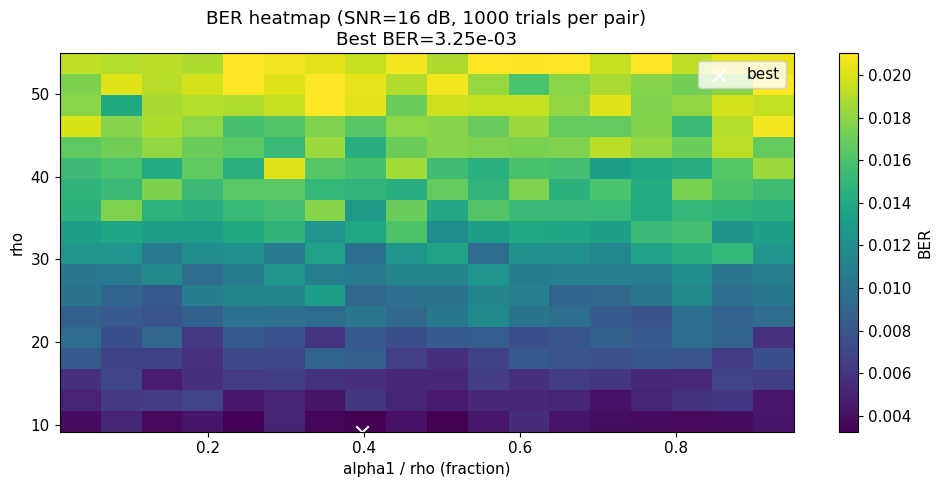

Representative run: iters=40, final residual=3.652e-04, symbol_errs=0


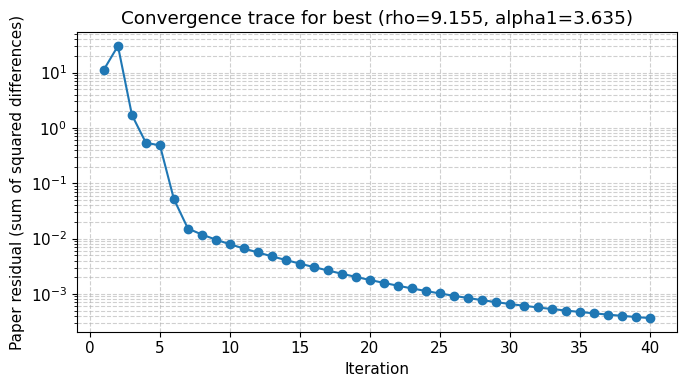

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals, norm, solve
import time
np.random.seed(0)

# ---------------------------
# System / simulation params
# ---------------------------
B = 16
U = 16
Q = 2                              # Q=2 for 4-QAM
constellation = np.array([1+1j, 1-1j, -1+1j, -1-1j])  # unnormalized
Es = np.mean(np.abs(constellation)**2)  # = 2
MAX_ITER = 40
RES_TOL = 1e-5

# Grid-search settings (change for finer search)
GRID_RHO_POINTS = 18
GRID_ALPHA_POINTS = 18
N_trials = 1000                      # Monte Carlo transmissions per grid point (increase for accuracy)
SNR_dB_search = 16                   # SNR used during search (representative)
USE_FIXED_H_SEED = 1234             # the fixed H seed used across grid

# ---------------------------
# Helpers (paper residual & algorithm)
# ---------------------------
def gen_H(B, U, seed=1234):
    rng = np.random.RandomState(seed)
    return (rng.randn(B, U) + 1j * rng.randn(B, U)) / np.sqrt(2)

def spectral_bound(H):
    lam_max = np.max(np.real(eigvals(H.conj().T @ H)))
    return lam_max, np.sqrt(2 * lam_max)

def quantize_to_constellation_vec(x, constellation):
    x = np.atleast_1d(x)
    d = np.abs(x[:, None] - constellation[None, :])**2
    idx = np.argmin(d, axis=1)
    return constellation[idx], idx

# PS-ADMM as in the paper (paper residual used)
def psadmm_single_trace(y, H, rho, alpha_list, Q=2, max_iter=MAX_ITER, tol=RES_TOL):
    # returns x_est, final indices, residual_trace, iters
    U = H.shape[1]
    Hh = H.conj().T
    HH = Hh @ H
    inv_mat = np.linalg.inv(HH + rho * np.eye(U))
    Hh_y = Hh @ y

    x_q = [np.zeros(U, dtype=complex) for _ in range(Q)]
    x0 = np.zeros(U, dtype=complex)
    y_dual = np.zeros(U, dtype=complex)

    residuals = []
    for k in range(max_iter):
        x_q_prev = [xi.copy() for xi in x_q]
        x0_prev = x0.copy()

        # sequential update
        for q in range(1, Q+1):
            alpha_q = alpha_list[q-1] if (q-1) < len(alpha_list) else 0.0
            denom = (4**(q-1)) * rho - alpha_q
            if abs(denom) < 1e-12:
                denom = 1e-12
            sum_before = np.zeros(U, dtype=complex)
            for i in range(1, q):
                sum_before += (2**(i-1)) * x_q[i-1]
            sum_after = np.zeros(U, dtype=complex)
            for i in range(q+1, Q+1):
                sum_after += (2**(i-1)) * x_q_prev[i-1]

            inner = rho * x0 - rho * sum_before - rho * sum_after + y_dual
            x_temp = (2**(q-1) / denom) * inner
            # box project real/imag to [-1,1]
            xr = np.clip(x_temp.real, -1, 1)
            xi = np.clip(x_temp.imag, -1, 1)
            x_q[q-1] = xr + 1j * xi

        # x0 update
        sum_xq = np.zeros(U, dtype=complex)
        for q in range(1, Q+1):
            sum_xq += (2**(q-1)) * x_q[q-1]
        x0 = inv_mat @ (Hh_y + rho * sum_xq - y_dual)

        # dual update
        y_dual = y_dual + rho * (x0 - sum_xq)

        # paper residual: sum_q ||x_q^{k+1} - x_q^k||^2  + ||x0^{k+1} - x0^k||^2
        res_q_sum = sum(norm(x_q[q] - x_q_prev[q])**2 for q in range(Q))
        res_0 = norm(x0 - x0_prev)**2
        residual = res_q_sum + res_0
        residuals.append(residual)

        if residual < tol:
            break

    x_est = x0 + sum((2**(q-1)) * x_q[q-1] for q in range(1, Q+1))
    x_quant, idx = quantize_to_constellation_vec(x_est, constellation)
    return x_est, idx, np.array(residuals), len(residuals)

# ---------------------------
# Build fixed H and compute spectral bound
# ---------------------------
H_fixed = gen_H(B, U, seed=USE_FIXED_H_SEED)
lam_max, rho_min_bound = spectral_bound(H_fixed)
print(f"Fixed H (seed={USE_FIXED_H_SEED}) -> lambda_max(H^H H) = {lam_max:.4f}; sqrt(2*lambda_max) = {rho_min_bound:.4f}")

# ---------------------------
# Build feasible rho and alpha grids
# - Ensure rho > rho_min_bound
# - For Q=2, we require (4^(q-1) * rho > alpha_q). For q=1 => rho > alpha1
# So alpha1 range is (small positive .. 0.99*rho)
# ---------------------------
rho_lo = max(rho_min_bound * 1.02, 0.05)   # a little above theoretical lower bound
rho_hi = max(4.0, rho_lo * 6.0)            # explore up to several times lower bound
rho_grid = np.linspace(rho_lo, rho_hi, GRID_RHO_POINTS)

# alpha grid relative to rho; we'll choose alpha1 values for each rho dynamically later,
# but for heatmap we fix a global alpha fraction grid [0.01..0.95] of rho.
alpha_frac_grid = np.linspace(0.01, 0.95, GRID_ALPHA_POINTS)  # alpha = frac * rho
print(f"Searching rho in [{rho_lo:.3f}, {rho_hi:.3f}] (points={len(rho_grid)})")
print(f"alpha fraction grid length = {len(alpha_frac_grid)} (alpha = frac * rho)")

# ---------------------------
# Search loop: for each rho and alpha1 compute BER and avg residual & iters
# We'll use SNR_dB_search for noise level and run N_trials random symbols per pair.
# ---------------------------
SNR_lin = 10**(SNR_dB_search/10)
noise_var = Es / SNR_lin

BER_grid = np.full((len(rho_grid), len(alpha_frac_grid)), np.nan)
res_grid = np.full_like(BER_grid, np.nan)
iters_grid = np.full_like(BER_grid, np.nan)

start_time = time.time()
for i_r, rho in enumerate(rho_grid):
    for j_a, a_frac in enumerate(alpha_frac_grid):
        alpha1 = a_frac * rho
        # Check theoretical condition for q=1: 4^(0)*rho > alpha1 => rho > alpha1 (ensured by a_frac < 1)
        if not (rho > alpha1):
            continue
        # Also ensure rho satisfies spectral bound
        if not (rho > rho_min_bound):
            continue

        bit_errors = 0
        total_bits = 0
        resid_sum = 0.0
        iters_sum = 0.0

        rng_local = np.random.RandomState(1000 + i_r * 100 + j_a)
        for t in range(N_trials):
            tx_idx = rng_local.randint(0, 4, U)
            tx_sym = constellation[tx_idx]
            noise = np.sqrt(noise_var/2) * (rng_local.randn(B) + 1j * rng_local.randn(B))
            y = H_fixed @ tx_sym + noise

            _, det_idx, residuals, iters = psadmm_single_trace(y, H_fixed, rho, [alpha1], Q=Q, max_iter=MAX_ITER, tol=RES_TOL)
            # Each symbol encodes 2 bits
            bit_errors += np.sum(det_idx != tx_idx) * 2
            total_bits += U * 2
            resid_sum += residuals[-1] if residuals.size > 0 else np.inf
            iters_sum += iters

        BER = bit_errors / total_bits
        avg_resid = resid_sum / N_trials
        avg_iters = iters_sum / N_trials

        BER_grid[i_r, j_a] = BER
        res_grid[i_r, j_a] = avg_resid
        iters_grid[i_r, j_a] = avg_iters

    # progress print
    elapsed = time.time() - start_time
    print(f"rho {i_r+1}/{len(rho_grid)} done (rho={rho:.3f}), elapsed {elapsed:.1f}s")

total_time = time.time() - start_time
print(f"Grid search finished in {total_time:.1f}s")

# ---------------------------
# Pick best params: minimize BER, tie-breaker residual, then iterations
# ---------------------------
valid_mask = np.isfinite(BER_grid)
if not np.any(valid_mask):
    raise RuntimeError("No valid (rho,alpha) pairs found. Expand grid or relax constraints.")

best_idx = np.unravel_index(np.nanargmin(BER_grid), BER_grid.shape)
best_rho = rho_grid[best_idx[0]]
best_alpha_frac = alpha_frac_grid[best_idx[1]]
best_alpha1 = best_alpha_frac * best_rho
best_ber = BER_grid[best_idx]
best_res = res_grid[best_idx]
best_iters = iters_grid[best_idx]

print("\n=== BEST PARAMETERS FOUND ===")
print(f"rho = {best_rho:.4f}, alpha1 = {best_alpha1:.4f} (alpha fraction = {best_alpha_frac:.3f})")
print(f"BER = {best_ber:.3e}, avg_final_residual = {best_res:.3e}, avg_iters = {best_iters:.2f}")

# ---------------------------
# Plot BER heatmap (rho rows x alpha_frac cols)
# ---------------------------
plt.figure(figsize=(10,5))
im = plt.imshow(BER_grid, origin='lower', aspect='auto', 
                extent=[alpha_frac_grid[0], alpha_frac_grid[-1], rho_grid[0], rho_grid[-1]],
                vmin=np.nanmin(BER_grid), vmax=np.nanpercentile(BER_grid, 98))
plt.colorbar(im, label='BER')
plt.scatter([best_alpha_frac], [best_rho], c='w', marker='x', s=80, label='best')
plt.xlabel('alpha1 / rho (fraction)')
plt.ylabel('rho')
plt.title(f'BER heatmap (SNR={SNR_dB_search} dB, {N_trials} trials per pair)\nBest BER={best_ber:.2e}')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# Convergence trace for best params (single representative transmission)
# ---------------------------
rng_rep = np.random.RandomState(77)
tx_idx_rep = rng_rep.randint(0, 4, U)
tx_sym_rep = constellation[tx_idx_rep]
noise_rep = np.sqrt(noise_var/2) * (rng_rep.randn(B) + 1j * rng_rep.randn(B))
y_rep = H_fixed @ tx_sym_rep + noise_rep

x_est_rep, det_idx_rep, residuals_rep, iters_rep = psadmm_single_trace(y_rep, H_fixed, best_rho, [best_alpha1], Q=Q, max_iter=MAX_ITER, tol=RES_TOL)
print(f"Representative run: iters={iters_rep}, final residual={residuals_rep[-1]:.3e}, symbol_errs={(det_idx_rep!=tx_idx_rep).sum()}")

plt.figure(figsize=(7,4))
plt.semilogy(np.arange(1, len(residuals_rep)+1), residuals_rep, 'o-', linewidth=1.5)
plt.xlabel('Iteration')
plt.ylabel('Paper residual (sum of squared differences)')
plt.title(f'Convergence trace for best (rho={best_rho:.3f}, alpha1={best_alpha1:.3f})')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

SNR=0 dB -> BER=1.143e-01
SNR=2 dB -> BER=6.980e-02
SNR=4 dB -> BER=3.887e-02
SNR=6 dB -> BER=2.206e-02
SNR=8 dB -> BER=1.372e-02
SNR=10 dB -> BER=7.537e-03
SNR=12 dB -> BER=6.913e-03
SNR=14 dB -> BER=4.975e-03
SNR=16 dB -> BER=3.725e-03
SNR=18 dB -> BER=3.825e-03
SNR=20 dB -> BER=3.112e-03


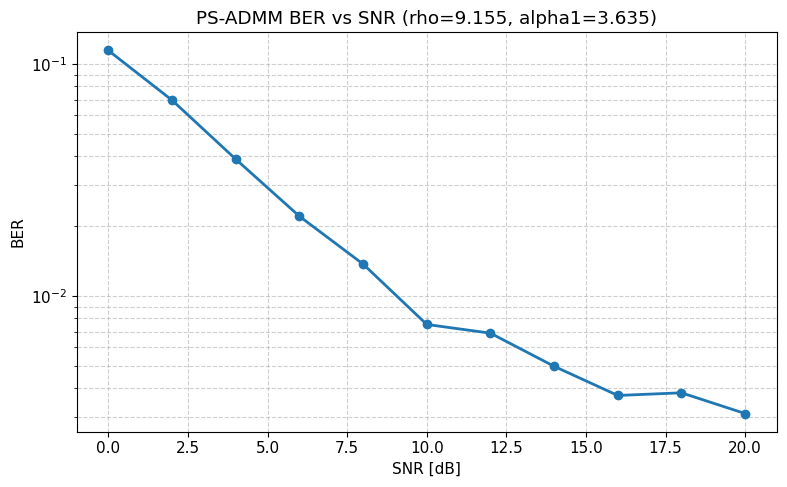

In [11]:
SNR_dB_vec = np.arange(0, 21, 2)  # SNR points from 0 to 20 dB
N_trials_ber = 5000               # Monte Carlo per SNR (increase for smoother curves)

BER_vs_SNR = []

for snr_db in SNR_dB_vec:
    SNR_lin = 10**(snr_db/10)
    noise_var = Es / SNR_lin

    bit_errors = 0
    total_bits = 0

    rng_mc = np.random.RandomState(999 + snr_db)
    for t in range(N_trials_ber):
        tx_idx = rng_mc.randint(0, 4, U)
        tx_sym = constellation[tx_idx]
        noise = np.sqrt(noise_var/2) * (rng_mc.randn(B) + 1j * rng_mc.randn(B))
        y = H_fixed @ tx_sym + noise

        _, det_idx, _, _ = psadmm_single_trace(y, H_fixed, best_rho, [best_alpha1], Q=Q, max_iter=MAX_ITER, tol=RES_TOL)
        bit_errors += np.sum(det_idx != tx_idx) * 2
        total_bits += U * 2

    BER = bit_errors / total_bits
    BER_vs_SNR.append(BER)
    print(f"SNR={snr_db} dB -> BER={BER:.3e}")

# ---------------------------
# Plot BER waterfall
# ---------------------------
plt.figure(figsize=(8,5))
plt.semilogy(SNR_dB_vec, BER_vs_SNR, 'o-', linewidth=2)
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.title(f'PS-ADMM BER vs SNR (rho={best_rho:.3f}, alpha1={best_alpha1:.3f})')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

[ADMM] SNR=0 dB -> BER=1.084e-02
[ADMM] SNR=2 dB -> BER=3.537e-03
[ADMM] SNR=4 dB -> BER=1.912e-03
[ADMM] SNR=6 dB -> BER=1.837e-03
[ADMM] SNR=8 dB -> BER=1.350e-03
[ADMM] SNR=10 dB -> BER=7.750e-04
[ADMM] SNR=12 dB -> BER=2.350e-03
[ADMM] SNR=14 dB -> BER=4.750e-04
[ADMM] SNR=16 dB -> BER=1.125e-03
[ADMM] SNR=18 dB -> BER=1.213e-03
[ADMM] SNR=20 dB -> BER=7.875e-04


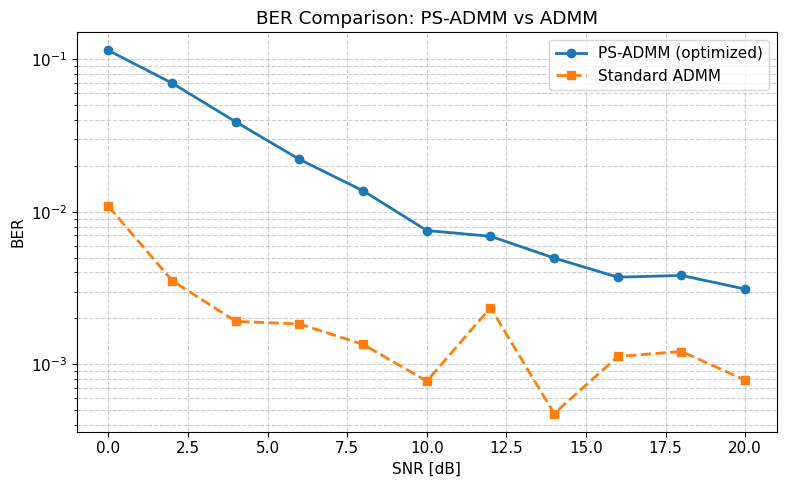

In [12]:
# ================================================================
# Add the Generalized ADMM detector and compare vs PS-ADMM
# ================================================================
class GeneralizedADMM:
    def __init__(self, constellation: np.ndarray, U: int):
        self.constellation = constellation
        self.U = U

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float,
               max_iter: int = 50, tol: float = 1e-6, verbose=False):
        """
        Standard ADMM formulation:
        x^{k+1} = argmin_x f(x) + (ρ/2)||x - z^k + u^k||²
        z^{k+1} = Π_C(x^{k+1} + u^k)
        u^{k+1} = u^k + x^{k+1} - z^{k+1}
        """
        U = self.U
        H_H = H.conj().T
        inv_matrix = np.linalg.inv(H_H @ H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        x = np.zeros(U, dtype=complex)
        z = np.zeros(U, dtype=complex)
        u = np.zeros(U, dtype=complex)
        residuals = []

        for k in range(max_iter):
            x_prev, z_prev = x.copy(), z.copy()

            # x-update
            x = inv_matrix @ (H_H_r + rho * (z - u))

            # z-update: projection to constellation
            z, _ = quantize_to_constellation_vec(x + u, self.constellation)

            # u-update
            u = u + x - z

            # compute residuals
            primal_residual = norm(x - z)
            dual_residual = norm(rho * (z - z_prev))
            residual = primal_residual + dual_residual
            residuals.append(residual)

            if verbose and (k % 10 == 0 or k == max_iter - 1):
                print(f"[ADMM] iter {k}, residual={residual:.3e}")

            if residual < tol:
                break

        x_hard, idx = quantize_to_constellation_vec(z, self.constellation)
        info = {"residuals": residuals, "iters": len(residuals), "converged": residual < tol}
        return x, x_hard, idx, info


# ================================================================
# BER vs SNR comparison: PS-ADMM vs ADMM
# ================================================================
admm_detector = GeneralizedADMM(constellation, U)
BER_vs_SNR_admm = []

for snr_db in SNR_dB_vec:
    SNR_lin = 10**(snr_db/10)
    noise_var = Es / SNR_lin

    bit_errors = 0
    total_bits = 0

    rng_mc = np.random.RandomState(2025 + snr_db)
    for t in range(N_trials_ber):
        tx_idx = rng_mc.randint(0, 4, U)
        tx_sym = constellation[tx_idx]
        noise = np.sqrt(noise_var/2) * (rng_mc.randn(B) + 1j * rng_mc.randn(B))
        y = H_fixed @ tx_sym + noise

        _, x_hard, idx, _ = admm_detector.detect(
            y, H_fixed, rho=best_rho, max_iter=MAX_ITER, tol=RES_TOL
        )
        bit_errors += np.sum(idx != tx_idx) * 2
        total_bits += U * 2

    BER = bit_errors / total_bits
    BER_vs_SNR_admm.append(BER)
    print(f"[ADMM] SNR={snr_db} dB -> BER={BER:.3e}")

# ================================================================
# Plot BER comparison
# ================================================================
plt.figure(figsize=(8, 5))
plt.semilogy(SNR_dB_vec, BER_vs_SNR, 'o-', linewidth=2, label='PS-ADMM (optimized)')
plt.semilogy(SNR_dB_vec, BER_vs_SNR_admm, 's--', linewidth=2, label='Standard ADMM')
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.title('BER Comparison: PS-ADMM vs ADMM')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



RUNNING BER vs SNR COMPARISON: PS-ADMM vs ADMM vs MMSE
Processing SNR = 0 dB...
  SNR= 0 dB -> MMSE: 7.550e-02, ADMM: 4.231e-02, PS-ADMM: 1.193e-01
Processing SNR = 2 dB...
  SNR= 2 dB -> MMSE: 4.150e-02, ADMM: 3.456e-02, PS-ADMM: 6.087e-02
Processing SNR = 4 dB...
  SNR= 4 dB -> MMSE: 2.637e-02, ADMM: 4.019e-02, PS-ADMM: 3.150e-02
Processing SNR = 6 dB...
  SNR= 6 dB -> MMSE: 1.263e-02, ADMM: 3.706e-02, PS-ADMM: 1.356e-02
Processing SNR = 8 dB...
  SNR= 8 dB -> MMSE: 8.000e-03, ADMM: 3.887e-02, PS-ADMM: 7.250e-03
Processing SNR = 10 dB...
  SNR=10 dB -> MMSE: 4.437e-03, ADMM: 4.163e-02, PS-ADMM: 4.437e-03
Processing SNR = 12 dB...
  SNR=12 dB -> MMSE: 4.000e-03, ADMM: 3.656e-02, PS-ADMM: 4.625e-03
Processing SNR = 14 dB...
  SNR=14 dB -> MMSE: 1.125e-03, ADMM: 3.438e-02, PS-ADMM: 2.375e-03
Processing SNR = 16 dB...
  SNR=16 dB -> MMSE: 9.375e-04, ADMM: 4.125e-02, PS-ADMM: 2.375e-03
Processing SNR = 18 dB...
  SNR=18 dB -> MMSE: 2.500e-04, ADMM: 4.013e-02, PS-ADMM: 1.437e-03
Processin

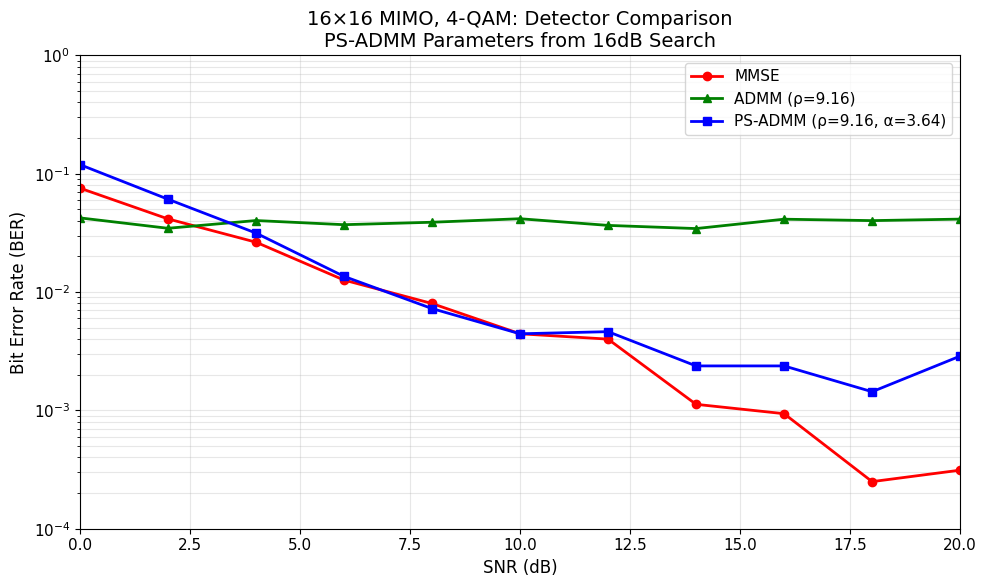


PERFORMANCE SUMMARY
Ranking (best to worst performance):
SNR= 0 dB: 🏆 ADMM: 4.231e-02 → MMSE: 7.550e-02 → PS-ADMM: 1.193e-01
SNR= 2 dB: 🏆 ADMM: 3.456e-02 → MMSE: 4.150e-02 → PS-ADMM: 6.087e-02
SNR= 4 dB: 🏆 MMSE: 2.637e-02 → PS-ADMM: 3.150e-02 → ADMM: 4.019e-02
SNR= 6 dB: 🏆 MMSE: 1.263e-02 → PS-ADMM: 1.356e-02 → ADMM: 3.706e-02
SNR= 8 dB: 🏆 PS-ADMM: 7.250e-03 → MMSE: 8.000e-03 → ADMM: 3.887e-02
SNR=10 dB: 🏆 MMSE: 4.437e-03 → PS-ADMM: 4.437e-03 → ADMM: 4.163e-02
SNR=12 dB: 🏆 MMSE: 4.000e-03 → PS-ADMM: 4.625e-03 → ADMM: 3.656e-02
SNR=14 dB: 🏆 MMSE: 1.125e-03 → PS-ADMM: 2.375e-03 → ADMM: 3.438e-02
SNR=16 dB: 🏆 MMSE: 9.375e-04 → PS-ADMM: 2.375e-03 → ADMM: 4.125e-02
SNR=18 dB: 🏆 MMSE: 2.500e-04 → PS-ADMM: 1.437e-03 → ADMM: 4.013e-02
SNR=20 dB: 🏆 MMSE: 3.125e-04 → PS-ADMM: 2.875e-03 → ADMM: 4.131e-02

Average performance across SNR range:
MMSE:    1.591e-02
ADMM:    3.893e-02 (0.41x vs MMSE)
PS-ADMM: 2.278e-02 (0.70x vs MMSE, 1.71x vs ADMM)

Win counts:
PS-ADMM: 2/11 SNR points
ADMM:    2/11

In [14]:
# Add ADMM detector function
def admm_detector(y, H, rho, max_iter=MAX_ITER, tol=RES_TOL):
    """Standard ADMM detector with box constraints"""
    U = H.shape[1]
    H_H = H.conj().T
    gram = H_H @ H
    A = gram + rho * np.eye(U)
    H_H_y = H_H @ y
    
    x = np.zeros(U, dtype=complex)
    z = np.zeros(U, dtype=complex)
    u = np.zeros(U, dtype=complex)
    
    box_limit = 1.0  # For ±1±1j constellation
    
    for k in range(max_iter):
        # x-update
        b = H_H_y + rho * (z - u)
        x = solve(A, b)
        
        # z-update with box constraint
        x_plus_u = x + u
        z_real = np.clip(x_plus_u.real, -box_limit, box_limit)
        z_imag = np.clip(x_plus_u.imag, -box_limit, box_limit)
        z = z_real + 1j * z_imag
        
        # u-update
        u = u + x - z
        
        # Check convergence
        if norm(x - z) < tol:
            break
    
    x_quant, idx = quantize_to_constellation_vec(z, constellation)
    return x_quant, idx, k + 1

# Add MMSE detector function
def mmse_detector(y, H, noise_var):
    """MMSE detector"""
    U = H.shape[1]
    H_H = H.conj().T
    A = H_H @ H + noise_var * np.eye(U)
    x_mmse = solve(A, H_H @ y)
    x_quant, idx = quantize_to_constellation_vec(x_mmse, constellation)
    return x_quant, idx

# ---------------------------
# BER vs SNR COMPARISON: PS-ADMM vs ADMM vs MMSE
# ---------------------------
print("\n" + "="*60)
print("RUNNING BER vs SNR COMPARISON: PS-ADMM vs ADMM vs MMSE")
print("="*60)

SNR_dB_range = np.arange(0, 21, 2)  # 0 to 20 dB in steps of 2
N_trials_comparison = 1000  # Trials per SNR point

# Store results
ber_mmse = []
ber_admm = []
ber_psadmm = []

# Use best parameters for PS-ADMM, and same rho for ADMM for fair comparison
admm_rho = best_rho  # Use same rho as PS-ADMM for fair comparison

for snr_db in SNR_dB_range:
    print(f"Processing SNR = {snr_db} dB...")
    
    snr_lin = 10**(snr_db/10)
    noise_var = Es / snr_lin
    
    errors_mmse = 0
    errors_admm = 0
    errors_psadmm = 0
    total_symbols = 0
    
    for trial in range(N_trials_comparison):
        # Generate new channel for each trial (more realistic)
        H = gen_H(B, U, seed=trial)
        
        # Generate transmission
        tx_idx = np.random.randint(0, 4, U)
        tx_sym = constellation[tx_idx]
        noise = np.sqrt(noise_var/2) * (np.random.randn(B) + 1j * np.random.randn(B))
        y = H @ tx_sym + noise
        
        # MMSE detection
        mmse_sym, mmse_idx = mmse_detector(y, H, noise_var)
        errors_mmse += np.sum(mmse_idx != tx_idx)
        
        # ADMM detection
        admm_sym, admm_idx, _ = admm_detector(y, H, admm_rho)
        errors_admm += np.sum(admm_idx != tx_idx)
        
        # PS-ADMM detection
        psadmm_sym, psadmm_idx, _, _ = psadmm_single_trace(y, H, best_rho, [best_alpha1])
        errors_psadmm += np.sum(psadmm_idx != tx_idx)
        
        total_symbols += U
    
    # Calculate BER (each symbol error = 2 bit errors for 4-QAM)
    ber_mmse.append(errors_mmse / total_symbols)
    ber_admm.append(errors_admm / total_symbols)
    ber_psadmm.append(errors_psadmm / total_symbols)
    
    print(f"  SNR={snr_db:2d} dB -> MMSE: {ber_mmse[-1]:.3e}, ADMM: {ber_admm[-1]:.3e}, PS-ADMM: {ber_psadmm[-1]:.3e}")

# ---------------------------
# Plot BER vs SNR comparison
# ---------------------------
plt.figure(figsize=(10, 6))
plt.semilogy(SNR_dB_range, ber_mmse, 'ro-', linewidth=2, markersize=6, label='MMSE')
plt.semilogy(SNR_dB_range, ber_admm, 'g^-', linewidth=2, markersize=6, label=f'ADMM (ρ={admm_rho:.2f})')
plt.semilogy(SNR_dB_range, ber_psadmm, 'bs-', linewidth=2, markersize=6, 
             label=f'PS-ADMM (ρ={best_rho:.2f}, α={best_alpha1:.2f})')

plt.grid(True, which='both', alpha=0.3)
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Bit Error Rate (BER)', fontsize=12)
plt.title(f'16×16 MIMO, 4-QAM: Detector Comparison\nPS-ADMM Parameters from {SNR_dB_search}dB Search', fontsize=14)
plt.legend(fontsize=11)
plt.ylim(1e-4, 1)
plt.xlim(0, 20)
plt.tight_layout()
plt.show()

# ---------------------------
# Performance summary
# ---------------------------
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

print("Ranking (best to worst performance):")
for i, snr in enumerate(SNR_dB_range):
    performances = [
        ('MMSE', ber_mmse[i]),
        ('ADMM', ber_admm[i]),
        ('PS-ADMM', ber_psadmm[i])
    ]
    # Sort by BER (lower is better)
    performances.sort(key=lambda x: x[1])
    
    print(f"SNR={snr:2d} dB: ", end="")
    for j, (name, ber) in enumerate(performances):
        if j == 0:
            print(f"🏆 {name}: {ber:.3e}", end="")
        else:
            print(f" → {name}: {ber:.3e}", end="")
    print()

# Calculate average improvement
print(f"\nAverage performance across SNR range:")
avg_mmse = np.mean(ber_mmse)
avg_admm = np.mean(ber_admm)
avg_psadmm = np.mean(ber_psadmm)

print(f"MMSE:    {avg_mmse:.3e}")
print(f"ADMM:    {avg_admm:.3e} ({avg_mmse/avg_admm:.2f}x vs MMSE)")
print(f"PS-ADMM: {avg_psadmm:.3e} ({avg_mmse/avg_psadmm:.2f}x vs MMSE, {avg_admm/avg_psadmm:.2f}x vs ADMM)")

# Count wins
psadmm_wins = sum(1 for i in range(len(SNR_dB_range)) if ber_psadmm[i] == min(ber_mmse[i], ber_admm[i], ber_psadmm[i]))
admm_wins = sum(1 for i in range(len(SNR_dB_range)) if ber_admm[i] == min(ber_mmse[i], ber_admm[i], ber_psadmm[i]))
mmse_wins = sum(1 for i in range(len(SNR_dB_range)) if ber_mmse[i] == min(ber_mmse[i], ber_admm[i], ber_psadmm[i]))

print(f"\nWin counts:")
print(f"PS-ADMM: {psadmm_wins}/{len(SNR_dB_range)} SNR points")
print(f"ADMM:    {admm_wins}/{len(SNR_dB_range)} SNR points") 
print(f"MMSE:    {mmse_wins}/{len(SNR_dB_range)} SNR points")

In [21]:
def psadmm_parameter_search(cfg: ScalableConfig, constellation: np.ndarray,
                            snr_db_search: float = 30, trials_per_point: int = 5000,
                            use_seed: int = 1234, coarse_points: int = 18,
                            fine_points: int = 6, coarse_alpha_min: float = 0.01,
                            coarse_alpha_max: float = 0.95, do_refine: bool = True):
    """
    Deterministic coarse->fine PS-ADMM parameter search:
      - fixed seeded H for reproducibility
      - deterministic RNG per grid cell
      - BER computed as bit-error-rate (counts bits)
      - coarse grid followed by optional fine refinement
    Returns: best_rho, best_alpha_list, best_ber, dict(diagnostics)
    """
    print(f"\n🔍 Starting PS-ADMM parameter search for {cfg.scenario_name}")
    print(f"SNR={snr_db_search} dB, trials per point={trials_per_point}, seed={use_seed}")

    # prepare
    GRID_RHO_POINTS = coarse_points
    GRID_ALPHA_POINTS = coarse_points

    # fixed H (seeded) and spectral bound
    rng_H = np.random.RandomState(use_seed)
    H_fixed = (rng_H.randn(cfg.B, cfg.U) + 1j * rng_H.randn(cfg.B, cfg.U)) / np.sqrt(2)
    lam_max = np.max(np.real(eigvals(H_fixed.conj().T @ H_fixed)))
    rho_min_bound = np.sqrt(2 * lam_max)
    print(f"Fixed H (seed={use_seed}) -> lambda_max: {lam_max:.4f}, ρ_min bound: {rho_min_bound:.4f}")

    # coarse grid bounds (similar to your second script but adjustable)
    rho_lo = max(rho_min_bound * 1.02, 0.05)
    rho_hi = max(4.0, rho_lo * 6.0)
    rho_grid = np.linspace(rho_lo, rho_hi, GRID_RHO_POINTS)
    alpha_frac_grid = np.linspace(coarse_alpha_min, coarse_alpha_max, GRID_ALPHA_POINTS)

    BER_grid = np.full((len(rho_grid), len(alpha_frac_grid)), np.nan)
    avg_iters_grid = np.full_like(BER_grid, np.nan)

    ps_detector = PSADMM(constellation, cfg.U, cfg.Q)
    Es = np.mean(np.abs(constellation)**2)  # symbol energy (normalized constellation may already be 1)
    SNR_lin = 10**(snr_db_search / 10.0)
    noise_var = Es / SNR_lin

    t_start = time.time()
    for i_r, rho in enumerate(rho_grid):
        for j_a, a_frac in enumerate(alpha_frac_grid):
            alpha1 = a_frac * rho
            # theorem / safety check
            if not (rho > alpha1) or not (rho > rho_min_bound):
                continue

            # deterministic RNG per grid cell for reproducibility
            rng_local = np.random.RandomState(use_seed + 1000 + i_r * 100 + j_a)

            bit_errors = 0
            total_bits = 0
            total_iters = 0

            for t in range(trials_per_point):
                tx_idx = rng_local.randint(0, len(constellation), cfg.U)
                tx_sym = constellation[tx_idx]

                noise = np.sqrt(noise_var / 2) * (rng_local.randn(cfg.B) + 1j * rng_local.randn(cfg.B))
                y = H_fixed @ tx_sym + noise

                try:
                    _, det_idx, info = ps_detector.detect(y, H_fixed, rho, [alpha1], max_iter=50, tol=1e-5)
                except Exception:
                    # on failure, skip this trial
                    continue

                # for Q=2 (4-QAM) bits per symbol = 2; generalize: bits = log2(M)
                bits_per_symbol = int(np.log2(len(constellation)))
                bit_errors += np.sum(det_idx != tx_idx) * bits_per_symbol
                total_bits += cfg.U * bits_per_symbol
                total_iters += info.get('iters', 0)

            if total_bits > 0:
                BER_grid[i_r, j_a] = bit_errors / total_bits
                avg_iters_grid[i_r, j_a] = total_iters / trials_per_point

        print(f"  Rho progress: {i_r+1}/{len(rho_grid)} (elapsed {time.time()-t_start:.0f}s)")

    # choose best coarse
    valid_mask = np.isfinite(BER_grid)
    if not np.any(valid_mask):
        print("❌ No valid coarse-grid params found; returning defaults")
        return 2.0, [1.0], 1.0, {'BER_grid': BER_grid}

    best_idx = np.unravel_index(np.nanargmin(BER_grid), BER_grid.shape)
    best_rho = rho_grid[best_idx[0]]
    best_alpha_frac = alpha_frac_grid[best_idx[1]]
    best_alpha = [best_alpha_frac * best_rho]
    best_ber = BER_grid[best_idx]
    best_iters = avg_iters_grid[best_idx]

    print(f"\nCoarse best -> rho={best_rho:.4f}, alpha={best_alpha[0]:.4f}, BER={best_ber:.3e}")

    # Optional: fine refinement
    if do_refine:
        rho_fine_grid = np.linspace(best_rho * 0.95, best_rho * 1.05, fine_points)
        alpha_frac_fine = np.linspace(best_alpha_frac * 0.9, best_alpha_frac * 1.1, fine_points)
        BER_fine = np.full((len(rho_fine_grid), len(alpha_frac_fine)), np.nan)

        for i_r, rho in enumerate(rho_fine_grid):
            for j_a, a_frac in enumerate(alpha_frac_fine):
                alpha1 = a_frac * rho
                if not (rho > alpha1) or not (rho > rho_min_bound):
                    continue

                rng_local = np.random.RandomState(use_seed + 2000 + i_r * 10 + j_a)
                bit_errors = 0
                total_bits = 0

                for t in range(trials_per_point):
                    tx_idx = rng_local.randint(0, len(constellation), cfg.U)
                    tx_sym = constellation[tx_idx]
                    noise = np.sqrt(noise_var / 2) * (rng_local.randn(cfg.B) + 1j * rng_local.randn(cfg.B))
                    y = H_fixed @ tx_sym + noise

                    try:
                        _, det_idx, info = ps_detector.detect(y, H_fixed, rho, [alpha1], max_iter=50, tol=1e-5)
                    except Exception:
                        continue

                    bits_per_symbol = int(np.log2(len(constellation)))
                    bit_errors += np.sum(det_idx != tx_idx) * bits_per_symbol
                    total_bits += cfg.U * bits_per_symbol

                if total_bits > 0:
                    BER_fine[i_r, j_a] = bit_errors / total_bits

        if np.any(np.isfinite(BER_fine)):
            best_idx_fine = np.unravel_index(np.nanargmin(BER_fine), BER_fine.shape)
            best_rho = rho_fine_grid[best_idx_fine[0]]
            best_alpha_frac = alpha_frac_fine[best_idx_fine[1]]
            best_alpha = [best_alpha_frac * best_rho]
            best_ber = BER_fine[best_idx_fine]
            print(f"Refined best -> rho={best_rho:.4f}, alpha={best_alpha[0]:.4f}, BER={best_ber:.3e}")

        diagnostics = {
            'BER_coarse': BER_grid,
            'avg_iters_coarse': avg_iters_grid,
            'BER_fine': BER_fine if 'BER_fine' in locals() else None,
            'H_fixed': H_fixed,
            'rho_grid': rho_grid,
            'alpha_frac_grid': alpha_frac_grid,
            'rho_fine_grid': rho_fine_grid if 'rho_fine_grid' in locals() else None,
            'alpha_frac_fine': alpha_frac_fine if 'alpha_frac_fine' in locals() else None,
            'time_s': time.time() - t_start
        }
        return best_rho, best_alpha, best_ber, diagnostics

    diagnostics = {'BER_coarse': BER_grid, 'avg_iters_coarse': avg_iters_grid, 'time_s': time.time() - t_start}
    return best_rho, best_alpha, best_ber, diagnostics


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from numpy.linalg import norm, eigvals
import time

np.random.seed(42)
plt.rcParams.update({'figure.figsize': (9,6), 'font.size': 11})

# ======================================================
# BASIC CONFIGURATION
# ======================================================
@dataclass
class ScalableConfig:
    U: int
    B: int
    modulation: str
    Q: int
    scenario_name: str = "scenario"

# ======================================================
# CONSTELLATION UTILITIES
# ======================================================
def get_constellation(modulation: str) -> Tuple[np.ndarray, float]:
    """Return normalized constellation points and normalization factor"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        a = np.array([-1, 1])
        normalization = np.sqrt(2)
    elif mod in ('16qam','16q'):
        a = np.array([-3, -1, 1, 3])
        normalization = np.sqrt(10)
    elif mod in ('64qam','64q'):
        a = np.arange(-7, 8, 2)
        normalization = np.sqrt(42)
    elif mod in ('256qam','256q'):
        a = np.arange(-15, 16, 2)
        normalization = np.sqrt(170)
    else:
        raise ValueError("Unsupported modulation")

    pts = np.array([x + 1j*y for x in a for y in a])
    return pts / normalization, normalization

def get_constellation_bounds(modulation: str) -> Tuple[float, float]:
    """Get normalized box constraint bounds"""
    mod = modulation.lower().replace('-', '')
    if mod in ('4qam','4q'):
        return -1.0/np.sqrt(2), 1.0/np.sqrt(2)
    elif mod in ('16qam','16q'):
        return -3.0/np.sqrt(10), 3.0/np.sqrt(10)
    elif mod in ('64qam','64q'):
        return -7.0/np.sqrt(42), 7.0/np.sqrt(42)
    elif mod in ('256qam','256q'):
        return -15.0/np.sqrt(170), 15.0/np.sqrt(170)
    else:
        raise ValueError("Unsupported modulation")

# ======================================================
# CHANNEL + NOISE
# ======================================================
def generate_channel(B: int, U: int) -> np.ndarray:
    return (np.random.randn(B, U) + 1j * np.random.randn(B, U)) / np.sqrt(2)

def add_awgn(y_clean: np.ndarray, snr_db: float) -> np.ndarray:
    snr_lin = 10**(snr_db/10)
    sig_power = np.mean(np.abs(y_clean)**2)
    noise_power = sig_power / snr_lin
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

# ======================================================
# BASIC QUANTIZATION
# ======================================================
def quantize_to_constellation(x: np.ndarray, constellation: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    d = np.abs(x[:, None] - constellation[None, :])
    idx = np.argmin(d, axis=1)
    return constellation[idx], idx

# ======================================================
# PS-ADMM DETECTOR
# ======================================================
class PSADMM:
    def __init__(self, constellation: np.ndarray, U: int, Q: int):
        self.constellation = constellation
        self.U = U
        self.Q = Q

    def project_to_box(self, x: np.ndarray):
        x_real = np.clip(np.real(x), -1, 1)
        x_imag = np.clip(np.imag(x), -1, 1)
        return x_real + 1j * x_imag

    def detect(self, r: np.ndarray, H: np.ndarray, rho: float, alpha: List[float],
               max_iter: int = 30, tol: float = 1e-5, verbose=False):
        U, Q = self.U, self.Q
        B = H.shape[0]
        H_H = H.conj().T
        H_H_H = H_H @ H
        inv_mat = np.linalg.inv(H_H_H + rho * np.eye(U) + 1e-12 * np.eye(U))
        H_H_r = H_H @ r

        x_q = [np.zeros(U, dtype=complex) for _ in range(Q+1)]
        x0 = np.zeros(U, dtype=complex)
        y = np.zeros(U, dtype=complex)
        residuals = []

        for k in range(max_iter):
            x_q_prev = [xi.copy() for xi in x_q]

            # Update x_q sequentially
            for q in range(1, Q+1):
                num = 2**(q-1)
                alpha_q = alpha[q-1] if (q-1) < len(alpha) else 0.0
                denom = (4**(q-1))*rho - alpha_q
                if abs(denom) < 1e-12:
                    denom = 1e-12

                sum_before = sum((2**(i-1))*x_q[i] for i in range(1, q))
                sum_after = sum((2**(i-1))*x_q_prev[i] for i in range(q+1, Q+1))
                inner = rho*x0 - rho*sum_before - rho*sum_after + y
                x_temp = (num/denom) * inner
                x_q[q] = self.project_to_box(x_temp)

            sum_xq = sum((2**(q-1))*x_q[q] for q in range(1, Q+1))
            x0_new = inv_mat @ (H_H_r + rho*sum_xq - y)
            y = y + rho*(x0_new - sum_xq)

            res_q = sum(norm(x_q[q]-x_q_prev[q])**2 for q in range(1, Q+1))
            res_0 = norm(x0_new - x0)**2
            residual = res_q + res_0
            residuals.append(residual)
            x0 = x0_new

            if residual < tol:
                break

        x_est = sum((2**(q-1))*x_q[q] for q in range(1, Q+1))
        x_hard, idx = quantize_to_constellation(x_est, self.constellation)
        info = {'residuals': residuals, 'iters': len(residuals), 'converged': residual < tol}
        return x_est, x_hard, idx, info

# ======================================================
# PARAMETER SEARCH (INTEGRATED)
# ======================================================
def psadmm_parameter_search(cfg: ScalableConfig, constellation: np.ndarray,
                            snr_db_search: float = 30, trials_per_point: int = 5000,
                            use_seed: int = 1234, coarse_points: int = 18,
                            fine_points: int = 6, coarse_alpha_min: float = 0.01,
                            coarse_alpha_max: float = 0.95, do_refine: bool = True):
    """
    Deterministic coarse→fine PS-ADMM parameter search
    """
    print(f"\n🔍 Starting PS-ADMM parameter search for {cfg.scenario_name}")
    print(f"SNR={snr_db_search} dB, trials per point={trials_per_point}, seed={use_seed}")

    rng_H = np.random.RandomState(use_seed)
    H_fixed = (rng_H.randn(cfg.B, cfg.U) + 1j * rng_H.randn(cfg.B, cfg.U)) / np.sqrt(2)
    lam_max = np.max(np.real(eigvals(H_fixed.conj().T @ H_fixed)))
    rho_min_bound = np.sqrt(2 * lam_max)
    print(f"λ_max={lam_max:.4f}, ρ_min bound={rho_min_bound:.4f}")

    rho_lo = max(rho_min_bound * 1.02, 0.05)
    rho_hi = rho_lo * 10.0
    rho_grid = np.linspace(rho_lo, rho_hi, coarse_points)
    alpha_frac_grid = np.linspace(coarse_alpha_min, coarse_alpha_max, coarse_points)

    BER_grid = np.full((len(rho_grid), len(alpha_frac_grid)), np.nan)
    avg_iters_grid = np.full_like(BER_grid, np.nan)

    ps_detector = PSADMM(constellation, cfg.U, cfg.Q)
    Es = np.mean(np.abs(constellation)**2)
    SNR_lin = 10**(snr_db_search/10)
    noise_var = Es / SNR_lin

    t_start = time.time()
    for i_r, rho in enumerate(rho_grid):
        for j_a, a_frac in enumerate(alpha_frac_grid):
            alpha1 = a_frac * rho
            if rho <= rho_min_bound:
                continue

            rng_local = np.random.RandomState(use_seed + 1000 + i_r*100 + j_a)
            bit_errors = 0
            total_bits = 0
            total_iters = 0

            for t in range(trials_per_point):
                tx_idx = rng_local.randint(0, len(constellation), cfg.U)
                tx_sym = constellation[tx_idx]
                noise = np.sqrt(noise_var/2)*(rng_local.randn(cfg.B)+1j*rng_local.randn(cfg.B))
                y = H_fixed @ tx_sym + noise

                try:
                    _, det_idx, info = ps_detector.detect(y, H_fixed, rho, [alpha1], max_iter=50)
                except Exception:
                    continue

                bits_per_symbol = int(np.log2(len(constellation)))
                bit_errors += np.sum(det_idx != tx_idx)*bits_per_symbol
                total_bits += cfg.U*bits_per_symbol
                total_iters += info.get('iters', 0)

            if total_bits > 0:
                BER_grid[i_r, j_a] = bit_errors/total_bits
                avg_iters_grid[i_r, j_a] = total_iters/trials_per_point

        print(f"  Rho progress: {i_r+1}/{len(rho_grid)} (elapsed {time.time()-t_start:.0f}s)")

    valid_mask = np.isfinite(BER_grid)
    if not np.any(valid_mask):
        print("❌ No valid coarse grid found.")
        return 2.0, [1.0], 1.0, {'BER_grid': BER_grid}

    best_idx = np.unravel_index(np.nanargmin(BER_grid), BER_grid.shape)
    best_rho = rho_grid[best_idx[0]]
    best_alpha_frac = alpha_frac_grid[best_idx[1]]
    best_alpha = [best_alpha_frac * best_rho]
    best_ber = BER_grid[best_idx]
    best_iters = avg_iters_grid[best_idx]

    print(f"\nCoarse best: ρ={best_rho:.4f}, α={best_alpha[0]:.4f}, BER={best_ber:.3e}")

    if do_refine:
        rho_fine_grid = np.linspace(best_rho*0.95, best_rho*1.05, fine_points)
        alpha_frac_fine = np.linspace(best_alpha_frac*0.9, best_alpha_frac*1.1, fine_points)
        BER_fine = np.full((len(rho_fine_grid), len(alpha_frac_fine)), np.nan)

        for i_r, rho in enumerate(rho_fine_grid):
            for j_a, a_frac in enumerate(alpha_frac_fine):
                alpha1 = a_frac * rho
                if not (rho > alpha1) or not (rho > rho_min_bound):
                    continue

                rng_local = np.random.RandomState(use_seed + 2000 + i_r*10 + j_a)
                bit_errors = 0
                total_bits = 0

                for t in range(trials_per_point):
                    tx_idx = rng_local.randint(0, len(constellation), cfg.U)
                    tx_sym = constellation[tx_idx]
                    noise = np.sqrt(noise_var/2)*(rng_local.randn(cfg.B)+1j*rng_local.randn(cfg.B))
                    y = H_fixed @ tx_sym + noise

                    try:
                        _, det_idx, info = ps_detector.detect(y, H_fixed, rho, [alpha1], max_iter=50)
                    except Exception:
                        continue

                    bits_per_symbol = int(np.log2(len(constellation)))
                    bit_errors += np.sum(det_idx != tx_idx)*bits_per_symbol
                    total_bits += cfg.U*bits_per_symbol

                if total_bits > 0:
                    BER_fine[i_r, j_a] = bit_errors/total_bits

        if np.any(np.isfinite(BER_fine)):
            best_idx_fine = np.unravel_index(np.nanargmin(BER_fine), BER_fine.shape)
            best_rho = rho_fine_grid[best_idx_fine[0]]
            best_alpha_frac = alpha_frac_fine[best_idx_fine[1]]
            best_alpha = [best_alpha_frac * best_rho]
            best_ber = BER_fine[best_idx_fine]
            print(f"Refined best: ρ={best_rho:.4f}, α={best_alpha[0]:.4f}, BER={best_ber:.3e}")

        diagnostics = {
            'BER_coarse': BER_grid,
            'avg_iters_coarse': avg_iters_grid,
            'BER_fine': BER_fine,
            'H_fixed': H_fixed,
            'rho_grid': rho_grid,
            'alpha_frac_grid': alpha_frac_grid,
            'rho_fine_grid': rho_fine_grid,
            'alpha_frac_fine': alpha_frac_fine,
            'time_s': time.time()-t_start
        }
        return best_rho, best_alpha, best_ber, diagnostics

    diagnostics = {'BER_coarse': BER_grid, 'avg_iters_coarse': avg_iters_grid, 'time_s': time.time()-t_start}
    return best_rho, best_alpha, best_ber, diagnostics


In [26]:
cfg = ScalableConfig(U=16, B=16, modulation='4QAM', Q=2, scenario_name='16x16_4QAM')
constellation, _ = get_constellation(cfg.modulation)
best_rho, best_alpha, best_ber, diag = psadmm_parameter_search(
    cfg, constellation, snr_db_search=20, trials_per_point=1000,
    coarse_alpha_min=0.01, coarse_alpha_max=0.5
)



🔍 Starting PS-ADMM parameter search for 16x16_4QAM
SNR=20 dB, trials per point=1000, seed=1234
λ_max=40.2827, ρ_min bound=8.9758
  Rho progress: 1/18 (elapsed 36s)
  Rho progress: 2/18 (elapsed 67s)
  Rho progress: 3/18 (elapsed 99s)
  Rho progress: 4/18 (elapsed 130s)
  Rho progress: 5/18 (elapsed 161s)
  Rho progress: 6/18 (elapsed 192s)
  Rho progress: 7/18 (elapsed 223s)
  Rho progress: 8/18 (elapsed 254s)
  Rho progress: 9/18 (elapsed 286s)
  Rho progress: 10/18 (elapsed 319s)
  Rho progress: 11/18 (elapsed 351s)
  Rho progress: 12/18 (elapsed 384s)
  Rho progress: 13/18 (elapsed 416s)
  Rho progress: 14/18 (elapsed 447s)
  Rho progress: 15/18 (elapsed 479s)
  Rho progress: 16/18 (elapsed 510s)
  Rho progress: 17/18 (elapsed 541s)
  Rho progress: 18/18 (elapsed 573s)
❌ No valid coarse grid found.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set global seeds ONCE at the beginning
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(GLOBAL_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Global random seed set to: {GLOBAL_SEED}")
print("All random generation will be deterministic from this point")

Global random seed set to: 42
All random generation will be deterministic from this point


In [2]:
# Cell 2: Global random state for reproducible channel generation
# Create global random state objects
global_np_rng = np.random.RandomState(GLOBAL_SEED)
global_torch_generator = torch.Generator()
global_torch_generator.manual_seed(GLOBAL_SEED)

print("Global random state objects created")

Global random state objects created


In [3]:
# Cell 3: Constellation and helper functions (deterministic)
def build_constellation(M):
    """Normalized square QAM constellation and Gray mapping."""
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)
    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation) ** 2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

def quantize_to_constellation(x, constellation):
    """Quantize to nearest constellation point."""
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)

def complex_to_real_matrix(H_complex):
    """Convert complex matrix to real-valued equivalent [Re -Im; Im Re]"""
    H_real = np.real(H_complex)
    H_imag = np.imag(H_complex)
    H_equiv = np.block([[H_real, -H_imag], 
                        [H_imag, H_real]])
    return H_equiv

def complex_to_real_vector(x_complex):
    """Convert complex vector to real-valued equivalent [Re; Im]"""
    return np.concatenate([np.real(x_complex), np.imag(x_complex)])

def real_to_complex_vector(x_real):
    """Convert real-valued vector back to complex"""
    N = len(x_real) // 2
    return x_real[:N] + 1j * x_real[N:]

print("Deterministic helper functions defined")

Deterministic helper functions defined


In [4]:
def generate_long_codeword_data(B, U, M, num_symbols, snr_db, codeword_idx=0):
    """Generate long codeword data using global random state."""
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin
    
    # Use global random state for reproducible channel generation
    # Different seed for each codeword to ensure diversity
    channel_seed = GLOBAL_SEED + codeword_idx * 1000
    channel_rng = np.random.RandomState(channel_seed)
    
    # Generate single channel realization for long codeword
    H_complex = (channel_rng.randn(B, U) + 1j * channel_rng.randn(B, U)) / np.sqrt(2)
    H_real = complex_to_real_matrix(H_complex)
    
    # Generate long sequence of symbols with deterministic but diverse randomness
    symbol_seed = GLOBAL_SEED + codeword_idx * 2000
    symbol_rng = np.random.RandomState(symbol_seed)
    
    total_bits = U * bits_per_symbol * num_symbols
    bits = symbol_rng.randint(0, 2, (num_symbols, U, bits_per_symbol))
    
    # Convert to complex symbols
    x_complex = np.array([[constellation[int("".join(map(str, b)), 2)] for b in symbol_bits] 
                         for symbol_bits in bits])
    
    # Generate noise with deterministic randomness
    noise_seed = GLOBAL_SEED + codeword_idx * 3000
    noise_rng = np.random.RandomState(noise_seed)
    noise_complex = np.sqrt(noise_var / 2) * (
        noise_rng.randn(num_symbols, B) + 1j * noise_rng.randn(num_symbols, B)
    )
    
    # Generate received signals
    y_complex = np.array([H_complex @ x_complex[i] + noise_complex[i] for i in range(num_symbols)])
    
    # Convert to real-valued equivalent
    y_real = np.array([complex_to_real_vector(y) for y in y_complex])
    x_real = np.array([complex_to_real_vector(x) for x in x_complex])
    
    return y_real, H_real, x_real, bits, constellation, bit_labels, total_bits, bits_per_symbol, U

print("Deterministic data generation function defined")

Deterministic data generation function defined


In [5]:
def mmse_detector_batch_real(y_real_batch, H_real_batch, noise_var):
    """Batch MMSE detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U_real = H_real_batch.shape[2]
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        H = H_real_batch[i]
        y = y_real_batch[i]
        HtH = H.T @ H
        # Noise variance is halved in real domain
        x_hat_real_batch[i] = np.linalg.inv(HtH + (noise_var/2) * np.eye(U_real)) @ (H.T @ y)
    
    return x_hat_real_batch

def admm_detector_batch_real(y_real_batch, H_real_batch, rho=0.1, max_iter=30, tol=1e-4):
    """Batch ADMM detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U_real = H_real_batch.shape[2]
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        y = y_real_batch[i]
        H = H_real_batch[i]
        Ht = H.T
        inv_matrix = np.linalg.inv(Ht @ H + rho * np.eye(U_real))
        Hty = Ht @ y
        x = np.zeros(U_real)
        z = np.zeros(U_real)
        lam = np.zeros(U_real)
        
        for _ in range(max_iter):
            x = inv_matrix @ (Hty + rho * (z - lam))
            # Project to QPSK constellation in real domain (±1/√2)
            z_new = np.clip(x + lam, -1/np.sqrt(2), 1/np.sqrt(2))
            lam = lam + x - z_new
            if np.linalg.norm(x - z_new) < tol:
                break
            z = z_new
        
        x_hat_real_batch[i] = x
    
    return x_hat_real_batch

def ps_admm_detect_batch_real(y_real_batch, H_real_batch, M, rho=1.5, alpha=0.01, T=30):
    """Batch PS-ADMM detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U_real = H_real_batch.shape[2]
    U = U_real // 2  # Original complex dimension
    
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        y = y_real_batch[i]
        H = H_real_batch[i]
        
        # PS-ADMM implementation in real domain
        xq = np.zeros((Q, U_real), dtype=np.float64)
        x0 = np.zeros(U_real, dtype=np.float64)
        dual_y = np.zeros(U_real, dtype=np.float64)
        scales = np.array([2 ** q for q in range(Q)])
        alpha_q = np.array([alpha] * Q)
        
        Ht = H.T
        HtH = Ht @ H
        Hty = Ht @ y
        A_inv = np.linalg.inv(HtH + rho * np.eye(U_real))
        
        for it in range(T):
            for q in range(Q):
                sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha_q[q]
                x_new = (scales[q] / denom) * numer
                # Project to QPSK in real domain (±1/√2)
                xq[q] = np.clip(x_new, -1/np.sqrt(2), 1/np.sqrt(2))
            
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = A_inv @ rhs
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        x_hat_real_batch[i] = np.sum(scales.reshape(-1, 1) * xq, axis=0)
    
    return x_hat_real_batch

print("Deterministic detector functions defined")

Deterministic detector functions defined


In [6]:
class UnfoldedADMMReal(nn.Module):
    def __init__(self, num_layers, U):
        super().__init__()
        self.num_layers = num_layers
        self.U = U
        self.U_real = 2 * U
        
        # Deterministic parameter initialization
        self.log_rho = nn.Parameter(torch.zeros(num_layers))
        self.log_gamma = nn.Parameter(torch.zeros(num_layers))
        
        # Ensure deterministic initialization
        with torch.no_grad():
            self.log_rho.data.normal_(0, 0.1)
            self.log_gamma.data.normal_(0, 0.1)

    def soft_project(self, x):
        """Soft projection for real-valued QPSK."""
        scale = 1.0 / np.sqrt(2)
        return scale * torch.tanh(10.0 * x)

    def forward(self, y, H):
        batch_size, N_real, U_real = H.shape
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        x = torch.zeros_like(Hty)
        z = torch.zeros_like(Hty)
        lam = torch.zeros_like(Hty)
        
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            gamma = torch.exp(self.log_gamma[l])
            
            inv = torch.linalg.inv(HtH + rho * I)
            x = torch.bmm(inv, (Hty + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + gamma * (x - z)
            
        return z

In [7]:
class UnfoldedPSADMMReal(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.U_real = 2 * U
        self.Q = Q
        self.L = L
        
        # Proper constrained initialization
        # rho should be positive and reasonably sized
        self.log_rho = nn.Parameter(torch.ones(L) * np.log(1.0))  # Start with rho=1.0
        
        # alpha should be small positive values
        self.log_alpha = nn.Parameter(torch.ones(L) * np.log(0.001))  # Start with alpha=0.001
        
        # Add trainable step sizes for better convergence
        self.step_sizes = nn.Parameter(torch.ones(L) * 0.1)

    def forward(self, H, y):
        batch_size, N_real, U_real = H.shape
        xq = torch.zeros(batch_size, self.Q, U_real, dtype=H.dtype, device=H.device)
        x0 = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        dual_y = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=H.dtype, device=H.device)
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        for l in range(self.L):
            # Constrained parameters - ensure they stay in reasonable ranges
            rho = torch.exp(self.log_rho[l]).clamp(0.1, 10.0)  # Constrain rho between 0.1 and 10
            alpha = torch.exp(self.log_alpha[l]).clamp(1e-4, 0.1)  # Constrain alpha between 1e-4 and 0.1
            step_size = self.step_sizes[l].clamp(0.01, 1.0)  # Constrain step size
            
            A_inv = torch.linalg.inv(HtH + rho * I)
            
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                
                # Add numerical stability
                denom = denom.clamp(1e-8, 1e8)
                
                x_new = (scales[q] / denom) * numer
                
                # Better soft projection with temperature parameter
                temperature = 10.0  # Fixed temperature for stability
                xq[:, q, :] = (1.0 / np.sqrt(2)) * torch.tanh(temperature * x_new)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + step_size * rho * (x0 - sum_scaled)  # Use trainable step size
        
        return x0

print("Fixed Unfolded PS-ADMM with proper constraints defined")

Fixed Unfolded PS-ADMM with proper constraints defined


In [8]:
def calculate_ber_long_codeword(x_hat_real, true_bits, constellation, bit_labels, U, bits_per_symbol):
    """Calculate BER using long codeword approach."""
    # Convert estimates back to complex
    x_hat_complex = np.array([real_to_complex_vector(x) for x in x_hat_real])
    
    total_errors = 0
    total_bits = 0
    
    for i in range(len(x_hat_complex)):
        # Quantize to constellation
        x_hat_quantized, symbol_indices = quantize_to_constellation(x_hat_complex[i], constellation)
        
        # Get transmitted bits for this symbol
        true_symbol_bits = true_bits[i]
        
        # Get detected bits
        detected_bits = bit_labels[symbol_indices]
        
        # Calculate bit errors
        symbol_errors = np.sum(detected_bits != true_symbol_bits)
        total_errors += symbol_errors
        total_bits += U * bits_per_symbol
    
    return total_errors / total_bits if total_bits > 0 else 0.0

print("BER calculation function defined")

BER calculation function defined


In [9]:
def unified_simulation_long_codeword(B=16, U=16, M=4, num_codewords=50, symbols_per_codeword=1000, snr_db_list=np.arange(0, 11, 0.5)):
    """Simulation using global random seed for complete reproducibility."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    print(f"Global seed: {GLOBAL_SEED}")
    print(f"Long codeword approach: {num_codewords} codewords × {symbols_per_codeword} symbols")
    print(f"Total symbols per SNR: {num_codewords * symbols_per_codeword:,}")
    print(f"Total bits per SNR: {num_codewords * symbols_per_codeword * U * int(np.log2(M)):,}")
    
    # Initialize models with deterministic weights
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    
    unfolded_admm_real = UnfoldedADMMReal(num_layers=5, U=U).to(device)
    unfolded_psadmm_real = UnfoldedPSADMMReal(U=U, Q=Q, L=10).to(device)
    
    unfolded_admm_real.eval()
    unfolded_psadmm_real.eval()
    
    ber_results = {
        "MMSE": [],
        "ADMM": [], 
        "Unfolded ADMM": [],
        "PS-ADMM": [],
        "Unfolded PS-ADMM": []
    }
    
    for snr_db in tqdm(snr_db_list, desc="Processing SNRs"):
        ber_mmse = 0
        ber_admm = 0
        ber_unfolded_admm = 0
        ber_psadmm = 0
        ber_unfolded_psadmm = 0
        
        # Process multiple long codewords with deterministic diversity
        for codeword_idx in range(num_codewords):
            # Generate long codeword data with deterministic but diverse randomness
            y_real, H_real, x_real, true_bits, constellation, bit_labels, total_bits, bits_per_symbol, U_val = generate_long_codeword_data(
                B, U, M, symbols_per_codeword, snr_db, codeword_idx
            )
            
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1 / snr_lin
            
            # MMSE detection
            x_mmse_real = mmse_detector_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), noise_var)
            ber_mmse += calculate_ber_long_codeword(x_mmse_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # ADMM detection
            x_admm_real = admm_detector_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)))
            ber_admm += calculate_ber_long_codeword(x_admm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # PS-ADMM detection
            x_psadmm_real = ps_admm_detect_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), M)
            ber_psadmm += calculate_ber_long_codeword(x_psadmm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # Unfolded detectors
            H_tensor = torch.tensor(np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), dtype=torch.float32, device=device)
            y_tensor = torch.tensor(y_real, dtype=torch.float32, device=device)
            
            with torch.no_grad():
                x_unfolded_admm_real = unfolded_admm_real(y_tensor, H_tensor).cpu().numpy()
                x_unfolded_psadmm_real = unfolded_psadmm_real(H_tensor, y_tensor).cpu().numpy()
            
            ber_unfolded_admm += calculate_ber_long_codeword(x_unfolded_admm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            ber_unfolded_psadmm += calculate_ber_long_codeword(x_unfolded_psadmm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
        
        # Average over all codewords
        ber_results["MMSE"].append(ber_mmse / num_codewords)
        ber_results["ADMM"].append(ber_admm / num_codewords)
        ber_results["Unfolded ADMM"].append(ber_unfolded_admm / num_codewords)
        ber_results["PS-ADMM"].append(ber_psadmm / num_codewords)
        ber_results["Unfolded PS-ADMM"].append(ber_unfolded_psadmm / num_codewords)
        
        print(f"SNR={snr_db:5.1f} dB | "
              f"MMSE: {ber_results['MMSE'][-1]:8.2e} | "
              f"ADMM: {ber_results['ADMM'][-1]:8.2e} | "
              f"U-ADMM: {ber_results['Unfolded ADMM'][-1]:8.2e} | "
              f"PS: {ber_results['PS-ADMM'][-1]:8.2e} | "
              f"U-PS: {ber_results['Unfolded PS-ADMM'][-1]:8.2e}")
    
    return snr_db_list, ber_results

In [ ]:
print("Starting GLOBALLY DETERMINISTIC simulation...")
print("Results will be 100% reproducible with the same seed")

snr_db_list, ber_results_long = unified_simulation_long_codeword(
    B=16, U=16, M=4,
    num_codewords=20,           # Fewer channel realizations
    symbols_per_codeword=2000,  # Longer codewords
    snr_db_list=np.arange(0, 11, 0.5)
)

print("\nGlobally deterministic simulation completed!")
print("You can run this again and get EXACTLY the same results")

Starting GLOBALLY DETERMINISTIC simulation...
Results will be 100% reproducible with the same seed
Using device: cuda
Global seed: 42
Long codeword approach: 20 codewords × 2000 symbols
Total symbols per SNR: 40,000
Total bits per SNR: 1,280,000


Processing SNRs:   0%|                                                                          | 0/22 [00:00<?, ?it/s]

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []

    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))

    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels


def quantize_to_constellation(x, constellation):
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)


def generate_channel(batch, B, U):
    """Rayleigh fading channel, now batched."""
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

In [3]:
def mmse_detector(y, H, noise_var):
    B, U = H.shape
    HhH = H.conj().T @ H
    return np.linalg.inv(HhH + noise_var*np.eye(U)) @ (H.conj().T @ y)


def admm_detector(y, H, rho=0.1, max_iter=20, tol=1e-4):
    B, U = H.shape
    Hh = H.conj().T
    inv_matrix = np.linalg.inv(Hh @ H + rho*np.eye(U))
    Hy = Hh @ y

    x = np.zeros(U, dtype=complex)
    z = np.zeros(U, dtype=complex)
    lam = np.zeros(U, dtype=complex)

    for _ in range(max_iter):
        x = inv_matrix @ (Hy + rho*(z - lam))
        z_new = np.clip(x.real + lam.real, -1, 1) \
              + 1j*np.clip(x.imag + lam.imag, -1, 1)
        lam = lam + x - z_new
        if np.linalg.norm(x - z_new) < tol:
            break
        z = z_new
    return x

In [4]:
def ps_admm_detect(H, r, M, rho=1.0, alpha=0.01, T=30):
    """
    Plain (classical) PS-ADMM detector per sample (numpy).
    H: (B, U) channel
    r: (B,) received vector
    returns: x_hat (U,)
    """
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]

    # Multi-scale decomposition variables
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    dual_y = np.zeros(U, dtype=np.complex128)

    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)

    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))

    for it in range(T):
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(np.real(x_new), -1, 1) + 1j * np.clip(np.imag(x_new), -1, 1)

        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - dual_y
        x0 = A_inv @ rhs
        dual_y = dual_y + rho * (x0 - sum_scaled)

    return np.sum(scales.reshape(-1, 1) * xq, axis=0)

In [5]:
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        B, N, U = H.shape
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            inv = torch.linalg.inv(HhH + rho * I)
            x = torch.bmm(inv, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

In [6]:
class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        """
        Unfolded PS-ADMM (PyTorch). This keeps the structure of the earlier
        unfolded PS-ADMM but **only** used for inference in the simulation here.
        """
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        # H: (batch, B, U), y: (batch, B)
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                # non-linear projection via tanh
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)

        return x0

In [7]:
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,        # large effective averaging
                       batch_size=2000,       # samples per batch
                       snr_db_list=np.arange(0, 11, 0.5)):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))

    # Unfolded networks (kept on device; small, so ok for now)
    Q = int(np.sqrt(M)) // 2
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=10).to(device)

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-9

    num_batches = trials // batch_size

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate batch (long codeword)
            H_batch = generate_channel(batch_size, B, U)              # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            # Map bits -> symbols
            x_batch = np.zeros((batch_size, U), dtype=np.complex128)
            for b in range(batch_size):
                for u in range(U):
                    sym_idx = int("".join(map(str, bits_batch[b, u])), 2)
                    x_batch[b, u] = constellation[sym_idx]

            noise = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            # compute y = H @ x  for each batch sample
            y_batch = np.zeros((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch[b] = H_batch[b] @ x_batch[b] + noise[b]

            # True indices for bit-error computation
            _, idx_true = quantize_to_constellation(x_batch, constellation)

            # --- Classical detectors (loop per batch sample) ---
            # MMSE and ADMM and PS-ADMM are numpy functions; call per sample
            for b in range(batch_size):
                # MMSE
                x_mm = mmse_detector(y_batch[b], H_batch[b], noise_var)
                _, idx_mm = quantize_to_constellation(x_mm, constellation)
                errors["MMSE"] += np.sum(bit_labels[idx_mm] != bit_labels[idx_true[b]])

                # ADMM
                x_admm = admm_detector(y_batch[b], H_batch[b])
                _, idx_a = quantize_to_constellation(x_admm, constellation)
                errors["ADMM"] += np.sum(bit_labels[idx_a] != bit_labels[idx_true[b]])

                # PS-ADMM (classical)
                x_ps = ps_admm_detect(H_batch[b], y_batch[b], M)
                _, idx_ps = quantize_to_constellation(x_ps, constellation)
                errors["PS-ADMM"] += np.sum(bit_labels[idx_ps] != bit_labels[idx_true[b]])

            # --- Unfolded detectors (batched PyTorch forward) ---
            H_t = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
            y_t = torch.tensor(y_batch, dtype=torch.cfloat, device=device)

            with torch.no_grad():
                x_unf_admm = unfolded_admm(y_t, H_t).cpu().numpy()          # (batch, U)
                x_unf_ps = unfolded_psadmm(H_t, y_t).cpu().numpy()         # (batch, U)

            for b in range(batch_size):
                _, idx_uad = quantize_to_constellation(x_unf_admm[b], constellation)
                errors["Unfolded ADMM"] += np.sum(bit_labels[idx_uad] != bit_labels[idx_true[b]])

                _, idx_ups = quantize_to_constellation(x_unf_ps[b], constellation)
                errors["Unfolded PS-ADMM"] += np.sum(bit_labels[idx_ups] != bit_labels[idx_true[b]])

        # finalize BER for this SNR
        for k in ber:
            ber[k].append(max(errors[k] / total_bits, eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

In [8]:
def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (Batch + Long Codeword Averaging)")
    plt.show()

In [ ]:
snr_db_list, ber = unified_simulation(trials=200_000, batch_size=2000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
B = 16           # receive antennas
U = 16           # transmit users
M = 4            # constellation size (4-QAM)
bits_per_symbol = int(np.log2(M))

# Simulation averaging (choose based on GPU memory)
trials = 40_000          # total sample vectors per SNR (effective averaging)
batch_size = 1000        # samples processed per batch; reduce if OOM
snr_db_list = np.arange(0, 11, 1)  # SNRs to evaluate

# ADMM/PS-ADMM settings
admm_iters = 10
psadmm_iters = 10
unfolded_layers_admm = 5
unfolded_layers_ps = 8

# RNG seeds (set once)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [4]:
def build_qpsk():
    const = np.array([1+1j, 1-1j, -1+1j, -1-1j], dtype=np.complex128) / np.sqrt(2)
    bits = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=int)  # mapping index->bits consistent
    return const, bits

CONSTELLATION, BIT_LABELS = build_qpsk()
CONST_TORCH = torch.tensor(CONSTELLATION, dtype=torch.cfloat, device=device)  # (4,)

def quantize_batch(x_batch):
    """
    x_batch: (batch, U) complex numpy or torch array
    returns: quantized symbols (same shape) and indices (batch, U)
    Works for numpy arrays (used for some classical detectors) and torch tensors (for unfolded).
    """
    if isinstance(x_batch, np.ndarray):
        flat = x_batch.reshape(-1,1)
        d2 = np.abs(flat - CONSTELLATION.reshape(1,-1))**2
        idx = np.argmin(d2, axis=1).reshape(x_batch.shape)
        return CONSTELLATION[idx], idx
    else:
        # torch path (x_batch: tensor complex, device)
        B_, U_ = x_batch.shape
        # (batch*U, 1) - (1, 4)-> (batch*U, 4)
        flat = x_batch.reshape(-1,1)
        const = CONST_TORCH.view(1,-1)  # (1,4)
        # distances: |z - c|^2 = (z-c)*(z-c).conj()
        d2 = torch.abs(flat - const)**2  # (batch*U, 4)
        idx = torch.argmin(d2, dim=1).view(B_, U_)
        return CONST_TORCH[idx], idx

In [5]:
def generate_channel(batch, B, U):
    """Batched Rayleigh channel: (batch, B, U)"""
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

def bits_to_symbols(bits_batch):
    """
    bits_batch: (batch, U, bits_per_symbol) {0,1}
    returns: symbols (batch, U) complex
    """
    batch, U_, bp = bits_batch.shape
    out = np.zeros((batch, U_), dtype=np.complex128)
    for b in range(batch):
        # convert each user's bits to index
        # bits shape (U, bp) -> string -> int
        idxs = np.array([int(''.join(map(str, bits_batch[b, u])), 2) for u in range(U_)])
        out[b, :] = CONSTELLATION[idxs]
    return out


### Detectors vectorized

In [6]:
def mmse_batch(H_batch, y_batch, noise_var):
    """
    H_batch: (batch, B, U) complex numpy
    y_batch: (batch, B) complex numpy
    noise_var: scalar
    returns x_hat (batch, U) complex numpy
    """
    batch = H_batch.shape[0]
    x_hat = np.zeros((batch, U), dtype=np.complex128)
    # vectorize with torch for speed on GPU
    H_t = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
    y_t = torch.tensor(y_batch, dtype=torch.cfloat, device=device)

    Hh = torch.conj(H_t).permute(0,2,1)                        # (batch, U, B)
    HhH = torch.bmm(Hh, H_t)                                  # (batch, U, U)
    rhs = torch.bmm(Hh, y_t.unsqueeze(-1)).squeeze(-1)        # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)
    # Solve (HhH + sigma2 I) x = rhs  -> batched solve
    A = HhH + noise_var * I
    x_sol = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    return x_sol.cpu().numpy()


In [19]:
def admm_batch(H_batch, y_batch, rho=5.0, iters=admm_iters, soft_project=True):
    """
    Batched classical ADMM implemented in torch (vectorized).
    H_batch: (batch, B, U)
    y_batch: (batch, B)
    returns x_est (batch, U)
    """
    batch = H_batch.shape[0]
    H_t = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
    y_t = torch.tensor(y_batch, dtype=torch.cfloat, device=device)

    Hh = torch.conj(H_t).permute(0,2,1)    # (batch, U, B)
    HhH = torch.bmm(Hh, H_t)               # (batch, U, U)
    Hhy = torch.bmm(Hh, y_t.unsqueeze(-1)).squeeze(-1)  # (batch, U)

    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)
    # initialize
    x = torch.zeros_like(Hhy)
    z = torch.zeros_like(Hhy)
    lam = torch.zeros_like(Hhy)

    for _ in range(iters):
        A = HhH + rho * I                        # (batch, U, U)
        rhs = Hhy + rho * (z - lam)              # (batch, U)
        # solve A x = rhs for each batch
        x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)

        if soft_project:
            # soft projection via tanh (keeps in [-1,1] soft)
            z = torch.complex(torch.tanh(x.real + lam.real), torch.tanh(x.imag + lam.imag))
        else:
            # hard quantization (closer to decision)
            quant, idx = quantize_batch(x + lam)  # returns torch tensors
            z = quant

        lam = lam + x - z

    return x.cpu().numpy()  

In [8]:
def psadmm_batch(H_batch, y_batch, M=4, rho=5.0, alpha=0.01, T=psadmm_iters):
    """
    Batched PS-ADMM (vectorized) using torch for linear algebra and tanh projection.
    Returns complex x_est (batch, U)
    """
    batch = H_batch.shape[0]
    H_t = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
    y_t = torch.tensor(y_batch, dtype=torch.cfloat, device=device)

    # Parameters
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    scales = torch.tensor([2**q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)

    Hh = torch.conj(H_t).permute(0,2,1)        # (batch, U, B)
    HhH = torch.bmm(Hh, H_t)                   # (batch, U, U)
    Hhr = torch.bmm(Hh, y_t.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    # variables
    xq = torch.zeros((batch, Q, U), dtype=torch.cfloat, device=device)
    x0 = torch.zeros((batch, U), dtype=torch.cfloat, device=device)
    dual_y = torch.zeros((batch, U), dtype=torch.cfloat, device=device)
    alpha_q = torch.tensor([alpha]*Q, dtype=torch.cfloat, device=device)

    # Precompute A_inv per batch if rho constant across iterations (we keep rho constant)
    # but since rho is constant for all iterations, we can compute A = HhH + rho*I once:
    A = HhH + rho * I
    # We'll use solve each iteration (more stable); since A doesn't change we can pre-factor via torch.linalg.inv if desired.
    # Use solve (batched) below.

    for _ in range(T):
        for q in range(Q):
            # sum_scaled: (batch, U)
            sum_scaled = (scales.view(1, -1, 1) * xq).sum(dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y     # (batch, U)
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            # projection - soft via tanh to stabilize
            xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
        sum_scaled = (scales.view(1, -1, 1) * xq).sum(dim=1)  # (batch, U)
        rhs = Hhr + rho * sum_scaled - dual_y
        # solve A x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)

    x_est = (scales.view(1, -1, 1) * xq).sum(dim=1)   # (batch, U)
    return x_est.cpu().numpy()

In [20]:
class UnfoldedADMM(nn.Module):
    def __init__(self, layers=unfolded_layers_admm, rho_init=3.0):
        super().__init__()
        self.layers = layers
        # Use fixed, safe layer-wise rho parameters (no training here)
        rhos = torch.ones(layers, dtype=torch.float32) * rho_init
        self.register_buffer("rho", rhos)  # buffer so no grad, stored on device

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, H, y):
        # H: (batch, B, U) complex tensor
        # y: (batch, B) complex tensor
        batch = H.shape[0]
        Hh = torch.conj(H).permute(0,2,1)         # (batch, U, B)
        HhH = torch.bmm(Hh, H)                    # (batch, U, U)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0).expand(batch, -1, -1)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.layers):
            rho_l = self.rho[l].item()
            A = HhH + rho_l * I
            rhs = Hhy + rho_l * (z - lam)
            x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return x  # return torch tensor (batch, U)

In [21]:
class UnfoldedPSADMM(nn.Module):
    def __init__(self, Q, layers=unfolded_layers_ps, rho_init=3.0, alpha_init=0.01):
        super().__init__()
        self.layers = layers
        self.Q = Q
        # fixed safe buffers
        rhos = torch.ones(layers, dtype=torch.float32) * rho_init
        alphas = torch.ones(layers, dtype=torch.float32) * alpha_init
        self.register_buffer("rho", rhos)
        self.register_buffer("alpha", alphas)

    def forward(self, H, y):
        batch = H.shape[0]
        device = H.device
        mscales = torch.tensor([2**q for q in range(self.Q)], dtype=torch.cfloat, device=device)  # (Q,)
        Hh = torch.conj(H).permute(0,2,1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        alpha_q = self.alpha  # (layers,) but we use scalar alpha per layer below

        for l in range(self.layers):
            rho_l = self.rho[l].item()
            alpha_l = self.alpha[l].item() if self.alpha.numel()>1 else self.alpha.item()
            A = HhH + rho_l * I
            for q in range(self.Q):
                sum_scaled = (mscales.view(1,-1,1) * xq).sum(dim=1) - mscales[q] * xq[:, q, :]
                numer = rho_l * x0 - rho_l * sum_scaled + dual_y
                denom = (4 ** q) * rho_l - alpha_l
                x_new = (mscales[q] / denom) * numer
                # soft projection
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = (mscales.view(1,-1,1) * xq).sum(dim=1)
            rhs = Hhr + rho_l * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho_l * (x0 - sum_scaled)

        return x0  # (batch, U) torch complex

In [22]:
def unified_simulation_gpu(trials=trials, batch_size=batch_size, snr_db_list=snr_db_list):
    device_local = device
    unfolded_admm = UnfoldedADMM().to(device_local)
    Q = int(np.sqrt(M)) // 2
    unfolded_ps = UnfoldedPSADMM(Q).to(device_local)

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {m: [] for m in method_names}

    num_batches = int(np.ceil(trials / batch_size))

    for snr_db in snr_db_list:
        print(f"\nSNR = {snr_db} dB")
        snr_lin = 10**(snr_db/10)
        noise_var = 1/snr_lin

        total_bit_errors = {m: 0 for m in method_names}
        total_bits = 0

        # reset GPU cache
        if device_local.type == "cuda":
            torch.cuda.empty_cache()

        for _ in tqdm(range(num_batches), desc=f"SNR {snr_db} batches"):
            cur_batch = min(batch_size, trials - (total_bits // (U*bits_per_symbol)))
            # create batch data
            H_batch = generate_channel(cur_batch, B, U)                   # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (cur_batch, U, bits_per_symbol))
            x_batch = bits_to_symbols(bits_batch)                          # (batch, U)
            # noise
            noise = np.sqrt(noise_var/2) * (np.random.randn(cur_batch, B) + 1j*np.random.randn(cur_batch, B))
            # y = H x + n
            y_batch = np.einsum('bij,bj->bi', H_batch, x_batch) + noise    # (batch, B)

            # true indices
            _, idx_true = quantize_batch(x_batch)

            # --- Classical (vectorized batched) ---
            # MMSE
            x_mm = mmse_batch(H_batch, y_batch, noise_var)                 # (batch, U)
            _, idx_mm = quantize_batch(x_mm)
            total_bit_errors["MMSE"] += np.sum(BIT_LABELS[idx_mm] != BIT_LABELS[idx_true])

            # ADMM classical (torch vectorized)
            x_ad = admm_batch(H_batch, y_batch, rho=5.0, iters=admm_iters)
            _, idx_ad = quantize_batch(x_ad)
            total_bit_errors["ADMM"] += np.sum(BIT_LABELS[idx_ad] != BIT_LABELS[idx_true])

            # PS-ADMM classical (vectorized torch)
            x_ps = psadmm_batch(H_batch, y_batch, M=M, rho=5.0, alpha=0.01, T=psadmm_iters)
            _, idx_ps = quantize_batch(x_ps)
            total_bit_errors["PS-ADMM"] += np.sum(BIT_LABELS[idx_ps] != BIT_LABELS[idx_true])

            # --- Unfolded detectors (torch batched) ---
            H_t = torch.tensor(H_batch, dtype=torch.cfloat, device=device_local)
            y_t = torch.tensor(y_batch, dtype=torch.cfloat, device=device_local)
            with torch.no_grad():
                x_uad = unfolded_admm(H_t, y_t).cpu().numpy()
                x_ups = unfolded_ps(H_t, y_t).cpu().numpy()

            _, idx_uad = quantize_batch(x_uad)
            _, idx_ups = quantize_batch(x_ups)
            total_bit_errors["Unfolded ADMM"] += np.sum(BIT_LABELS[idx_uad] != BIT_LABELS[idx_true])
            total_bit_errors["Unfolded PS-ADMM"] += np.sum(BIT_LABELS[idx_ups] != BIT_LABELS[idx_true])

            # update totals
            total_bits += cur_batch * U * bits_per_symbol

            # small GPU cache maintenance
            if device_local.type == "cuda":
                torch.cuda.empty_cache()

        # finish SNR
        for m in method_names:
            ber[m].append(total_bit_errors[m] / total_bits)

        print("BER:", {m: f"{ber[m][-1]:.3e}" for m in method_names})

    return snr_db_list, ber


SNR = 0 dB


SNR 0 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.89it/s]


BER: {'MMSE': '3.321e-02', 'ADMM': '1.305e-02', 'Unfolded ADMM': '1.641e-02', 'PS-ADMM': '1.245e-02', 'Unfolded PS-ADMM': '1.181e-02'}

SNR = 1 dB


SNR 1 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.98it/s]


BER: {'MMSE': '2.603e-02', 'ADMM': '8.851e-03', 'Unfolded ADMM': '1.146e-02', 'PS-ADMM': '8.310e-03', 'Unfolded PS-ADMM': '7.481e-03'}

SNR = 2 dB


SNR 2 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 20.08it/s]


BER: {'MMSE': '2.001e-02', 'ADMM': '5.956e-03', 'Unfolded ADMM': '7.987e-03', 'PS-ADMM': '5.583e-03', 'Unfolded PS-ADMM': '4.728e-03'}

SNR = 3 dB


SNR 3 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.83it/s]


BER: {'MMSE': '1.554e-02', 'ADMM': '4.302e-03', 'Unfolded ADMM': '5.905e-03', 'PS-ADMM': '3.995e-03', 'Unfolded PS-ADMM': '3.163e-03'}

SNR = 4 dB


SNR 4 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.58it/s]


BER: {'MMSE': '1.185e-02', 'ADMM': '3.156e-03', 'Unfolded ADMM': '4.495e-03', 'PS-ADMM': '2.866e-03', 'Unfolded PS-ADMM': '2.130e-03'}

SNR = 5 dB


SNR 5 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.47it/s]


BER: {'MMSE': '8.913e-03', 'ADMM': '2.272e-03', 'Unfolded ADMM': '3.395e-03', 'PS-ADMM': '2.059e-03', 'Unfolded PS-ADMM': '1.383e-03'}

SNR = 6 dB


SNR 6 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.22it/s]


BER: {'MMSE': '6.750e-03', 'ADMM': '1.867e-03', 'Unfolded ADMM': '2.745e-03', 'PS-ADMM': '1.658e-03', 'Unfolded PS-ADMM': '1.102e-03'}

SNR = 7 dB


SNR 7 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.83it/s]


BER: {'MMSE': '4.977e-03', 'ADMM': '1.466e-03', 'Unfolded ADMM': '2.255e-03', 'PS-ADMM': '1.296e-03', 'Unfolded PS-ADMM': '8.227e-04'}

SNR = 8 dB


SNR 8 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.38it/s]


BER: {'MMSE': '3.834e-03', 'ADMM': '1.251e-03', 'Unfolded ADMM': '1.934e-03', 'PS-ADMM': '1.118e-03', 'Unfolded PS-ADMM': '6.867e-04'}

SNR = 9 dB


SNR 9 batches: 100%|███████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.45it/s]


BER: {'MMSE': '2.713e-03', 'ADMM': '1.027e-03', 'Unfolded ADMM': '1.640e-03', 'PS-ADMM': '9.078e-04', 'Unfolded PS-ADMM': '5.133e-04'}

SNR = 10 dB


SNR 10 batches: 100%|██████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.00it/s]


BER: {'MMSE': '2.163e-03', 'ADMM': '9.789e-04', 'Unfolded ADMM': '1.567e-03', 'PS-ADMM': '8.734e-04', 'Unfolded PS-ADMM': '4.586e-04'}


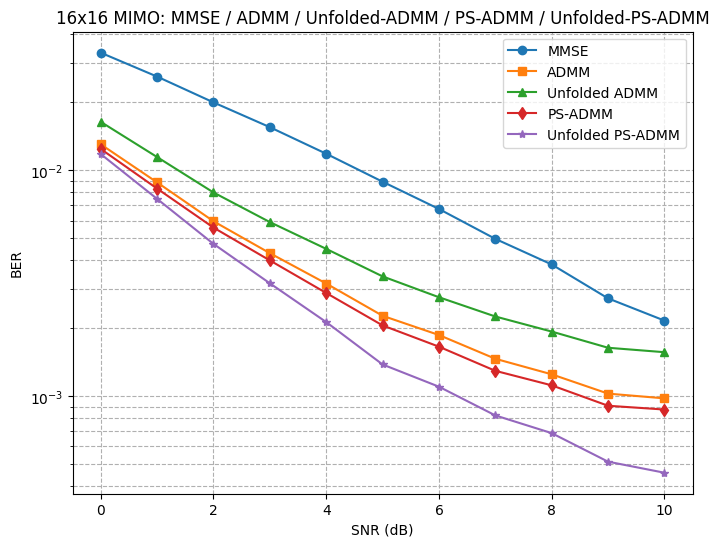

In [23]:
if __name__ == "__main__":
    snrs, ber = unified_simulation_gpu()
    plt.figure(figsize=(8,6))
    markers = ['o','s','^','d','*']
    order = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    for i, k in enumerate(order):
        plt.semilogy(snrs, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.title(f"{B}x{U} MIMO: MMSE / ADMM / Unfolded-ADMM / PS-ADMM / Unfolded-PS-ADMM")
    plt.legend()
    plt.show()

SNR=0.0 dB | MMSE=3.37e-02, ADMM=3.27e-02, Unfolded ADMM=1.90e-02, PS-ADMM=1.39e-02, Unfolded PS-ADMM=1.38e-02
SNR=1.0 dB | MMSE=2.58e-02, ADMM=2.33e-02, Unfolded ADMM=1.19e-02, PS-ADMM=8.14e-03, Unfolded PS-ADMM=7.98e-03
SNR=2.0 dB | MMSE=2.00e-02, ADMM=1.62e-02, Unfolded ADMM=7.19e-03, PS-ADMM=4.61e-03, Unfolded PS-ADMM=4.49e-03
SNR=3.0 dB | MMSE=1.57e-02, ADMM=1.14e-02, Unfolded ADMM=4.53e-03, PS-ADMM=2.61e-03, Unfolded PS-ADMM=2.54e-03
SNR=4.0 dB | MMSE=1.14e-02, ADMM=7.88e-03, Unfolded ADMM=2.68e-03, PS-ADMM=1.43e-03, Unfolded PS-ADMM=1.36e-03
SNR=5.0 dB | MMSE=8.69e-03, ADMM=5.22e-03, Unfolded ADMM=1.58e-03, PS-ADMM=6.69e-04, Unfolded PS-ADMM=6.56e-04
SNR=6.0 dB | MMSE=6.65e-03, ADMM=3.66e-03, Unfolded ADMM=1.13e-03, PS-ADMM=3.94e-04, Unfolded PS-ADMM=3.94e-04
SNR=7.0 dB | MMSE=5.12e-03, ADMM=2.43e-03, Unfolded ADMM=7.44e-04, PS-ADMM=1.84e-04, Unfolded PS-ADMM=1.81e-04
SNR=8.0 dB | MMSE=3.79e-03, ADMM=1.70e-03, Unfolded ADMM=6.06e-04, PS-ADMM=1.53e-04, Unfolded PS-ADMM=1.69e-04
S

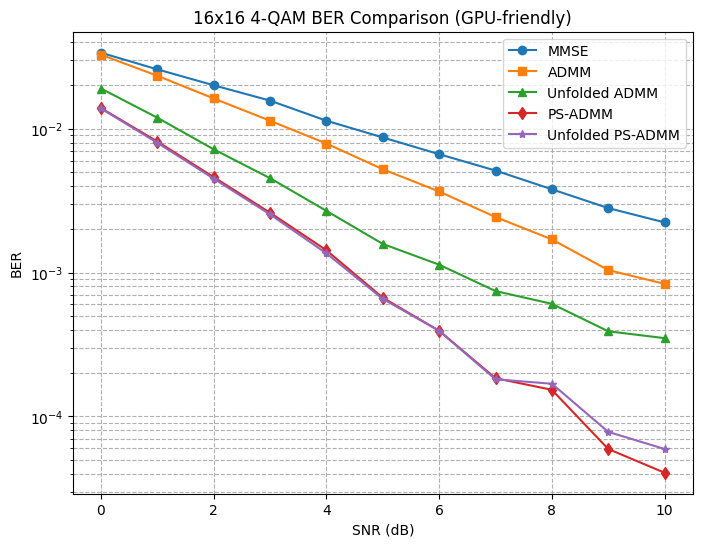

In [25]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ---------------------------
# utils: constellation + channel
# ---------------------------
def build_constellation_torch(M, device):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []

    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))

    constellation = np.array(constellation).astype(np.complex128)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)

    # to torch
    c = torch.tensor(constellation, dtype=torch.cfloat, device=device)
    b = torch.tensor(bit_labels, dtype=torch.uint8, device=device)
    return c, b

def quantize_to_constellation_torch(x, constellation):
    # x: (..., U) complex tensor, constellation: (M,) complex
    orig_shape = x.shape
    flat = x.reshape(-1, orig_shape[-1])  # (N, U)
    M = constellation.shape[0]
    # expand and compute squared distance
    # (N*U, 1) vs (1, M) via broadcasting:
    flat2 = flat.reshape(-1, 1)  # (N*U,1)
    d2 = torch.abs(flat2 - constellation.reshape(1, M)) ** 2  # (N*U, M)
    idx = torch.argmin(d2, dim=1)  # (N*U,)
    idx = idx.reshape(flat.shape)  # (N, U)
    quant = constellation[idx]     # (N, U)
    return quant.reshape(orig_shape), idx.reshape(orig_shape)

def generate_channel_torch(batch, B, U, device):
    real = torch.randn(batch, B, U, device=device)
    imag = torch.randn(batch, B, U, device=device)
    return (real + 1j * imag) / np.sqrt(2)

# ---------------------------
# Batched classical detectors (torch versions)
# ---------------------------
def mmse_detector_torch(H, y, noise_var):
    # H: (batch, B, U), y: (batch, B)
    # Solve (H^H H + noise_var I) x = H^H y  for each batch
    batch, B, U = H.shape
    Hh = torch.conj(H).transpose(1, 2)  # (batch, U, B)
    HhH = torch.bmm(Hh, H)              # (batch, U, U)
    Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I  # (batch, U, U)
    # use batched solve: A x = Hhy
    x = torch.linalg.solve(A, Hhy.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_torch(H, y, rho=0.1, max_iter=25, tol=1e-4):
    # Simple ADMM; batched
    batch, B, U = H.shape
    Hh = torch.conj(H).transpose(1, 2)
    HhH = torch.bmm(Hh, H)
    Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)

    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # We'll solve (HhH + rho I) x = Hhy + rho*(z - lam)
    A = HhH + rho * I
    # Pre-factorization might help; use torch.linalg.cholesky for Hermitian PSD matrices (if possible)
    # But to keep it robust, use solve each iteration (batched)
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)

    for _ in range(max_iter):
        rhs = Hhy + rho * (z - lam)
        x_new = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        # projection to square region -1..1 per real and imag
        z_new = torch.complex(torch.clamp(x_new.real + lam.real, -1.0, 1.0),
                              torch.clamp(x_new.imag + lam.imag, -1.0, 1.0))
        lam = lam + (x_new - z_new)
        if torch.max(torch.linalg.norm((x_new - z_new), dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_detect_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # A vectorized PS-ADMM per-batch sample. The original algorithm used multi-scale
    # Q = m_side//2; we vectorize across batch and q loops remain small.
    batch, B, U = H.shape
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=H.device)  # (Q,)
    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=H.device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
    Hh = torch.conj(H).transpose(1, 2)
    HhH = torch.bmm(Hh, H)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
    I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
    A = HhH + rho * I  # (batch, U, U)
    # We'll use solve with A each outer iteration; Q is small so q-loop is fine
    for it in range(T):
        for q in range(Q):
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return x0

# ---------------------------
# Unfolded models (kept similar but ensure dtype/device)
# ---------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, U):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)  # (batch, U, U)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0).expand(batch, -1, -1)
        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            # solve per-batch
            rhs = Hhy + rho * (z - lam)
            x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# ---------------------------
# unified simulation (GPU-friendly)
# ---------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,
                       batch_size=2000,
                       micro_batch=256,   # process micro-batches inside each batch to limit peak mem
                       snr_db_list=np.arange(0, 11, 0.5),
                       device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    device = torch.device(device)
    constellation, bit_labels = build_constellation_torch(M, device)
    bits_per_symbol = int(np.log2(M))

    Q = int(np.sqrt(M)) // 2
    unfolded_admm = UnfoldedADMM(num_layers=5, U=U).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=10).to(device)

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = trials // batch_size

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # generate full batch on GPU in chunks (to avoid huge allocations)
            H_batch = generate_channel_torch(batch_size, B, U, device)  # (batch, B, U)
            # random bits -> symbols
            bits_batch = torch.randint(0, 2, (batch_size, U, bits_per_symbol), device=device, dtype=torch.uint8)
            # map bits to symbol indices and symbols
            # compute symbol index per user: simple bitpack
            # bits are [b0,b1,...] where we treat them MSB->LSB as in original code
            sym_idx = bits_batch.to(torch.int64)
            # pack bits to indices:
            idx = sym_idx.clone().to(torch.int64)
            Ushape = idx.shape
            packed = idx[..., 0].clone()
            for bitpos in range(1, bits_per_symbol):
                packed = (packed << 1) | idx[..., bitpos]
            # packed: (batch, U)
            x_batch = constellation[packed]  # broadcast

            # generate noise and y
            noise = torch.sqrt(torch.tensor(noise_var/2, dtype=torch.float32, device=device)) * \
                    (torch.randn(batch_size, B, device=device, dtype=torch.float32) +
                     1j * torch.randn(batch_size, B, device=device, dtype=torch.float32))
            y_batch = torch.bmm(H_batch, x_batch.unsqueeze(2)).squeeze(2)
  # wrong einsum above originally
            # Correct compute: y[b] = H[b] @ x[b]
            # Let's compute directly:
            y_batch = torch.zeros(batch_size, B, dtype=torch.cfloat, device=device)
            for bidx in range(batch_size):
                y_batch[bidx] = H_batch[bidx].matmul(x_batch[bidx]) + noise[bidx]

            # true indices for BER
            _, idx_true = quantize_to_constellation_torch(x_batch, constellation)

            # process micro-batches to limit memory
            for start in range(0, batch_size, micro_batch):
                end = min(start + micro_batch, batch_size)
                Hb = H_batch[start:end]   # (mb, B, U)
                yb = y_batch[start:end]   # (mb, B)
                true_idx_mb = idx_true[start:end]  # (mb, U)

                # Classical batched detectors on this micro-batch
                x_mm = mmse_detector_torch(Hb, yb, noise_var)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation)
                # count bit errors
                errors["MMSE"] += int((bit_labels[idx_mm] != bit_labels[true_idx_mb]).sum().item())

                x_adm = admm_detector_torch(Hb, yb, rho=0.1, max_iter=20)
                _, idx_adm = quantize_to_constellation_torch(x_adm, constellation)
                errors["ADMM"] += int((bit_labels[idx_adm] != bit_labels[true_idx_mb]).sum().item())

                x_ps = ps_admm_detect_torch(Hb, yb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation)
                errors["PS-ADMM"] += int((bit_labels[idx_ps] != bit_labels[true_idx_mb]).sum().item())

                # Unfolded (torch) detectors
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(yb, Hb)   # (mb, U)
                    x_unf_ps = unfolded_psadmm(Hb, yb)  # (mb, U)

                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation)
                errors["Unfolded ADMM"] += int((bit_labels[idx_uad] != bit_labels[true_idx_mb]).sum().item())
                errors["Unfolded PS-ADMM"] += int((bit_labels[idx_ups] != bit_labels[true_idx_mb]).sum().item())

                # free some memory
                if device.type == "cuda":
                    torch.cuda.empty_cache()

        # finalize BER
        for k in ber:
            ber[k].append(max(errors[k] / total_bits, eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

# plotting function (same as before)
def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    keys = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    for i, k in enumerate(keys):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (GPU-friendly)")
    plt.show()

# ---------------------------
# Example run (adjust trials/batch/micro_batch as needed)
# ---------------------------
if __name__ == "__main__":
    # Start with smaller settings while testing; increase once stable
    snr_db_list = np.arange(0, 11, 1.0)
    # Try modest sizes first
    snr_db_list, ber = unified_simulation(B=16, U=16, M=4,
                                         trials=10_000,    # lower for test
                                         batch_size=1000,
                                         micro_batch=128,
                                         snr_db_list=snr_db_list,
                                         device="cuda" if torch.cuda.is_available() else "cpu")
    plot_unified(snr_db_list, ber)


SNR=0 dB | MMSE=3.35e-02, ADMM=3.28e-02, Unfolded ADMM=1.92e-02, PS-ADMM=2.31e-02, Unfolded PS-ADMM=1.39e-02
SNR=1 dB | MMSE=2.59e-02, ADMM=2.29e-02, Unfolded ADMM=1.17e-02, PS-ADMM=1.60e-02, Unfolded PS-ADMM=8.09e-03
SNR=2 dB | MMSE=2.03e-02, ADMM=1.62e-02, Unfolded ADMM=7.42e-03, PS-ADMM=1.13e-02, Unfolded PS-ADMM=4.67e-03
SNR=3 dB | MMSE=1.54e-02, ADMM=1.13e-02, Unfolded ADMM=4.38e-03, PS-ADMM=7.71e-03, Unfolded PS-ADMM=2.53e-03
SNR=4 dB | MMSE=1.18e-02, ADMM=7.71e-03, Unfolded ADMM=2.65e-03, PS-ADMM=4.99e-03, Unfolded PS-ADMM=1.38e-03
SNR=5 dB | MMSE=8.73e-03, ADMM=5.06e-03, Unfolded ADMM=1.64e-03, PS-ADMM=3.18e-03, Unfolded PS-ADMM=7.77e-04
SNR=6 dB | MMSE=6.71e-03, ADMM=3.58e-03, Unfolded ADMM=1.01e-03, PS-ADMM=2.03e-03, Unfolded PS-ADMM=4.45e-04
SNR=7 dB | MMSE=4.87e-03, ADMM=2.35e-03, Unfolded ADMM=7.11e-04, PS-ADMM=1.17e-03, Unfolded PS-ADMM=2.66e-04
SNR=8 dB | MMSE=3.80e-03, ADMM=1.67e-03, Unfolded ADMM=5.17e-04, PS-ADMM=7.73e-04, Unfolded PS-ADMM=1.95e-04
SNR=9 dB | MMSE=2.7

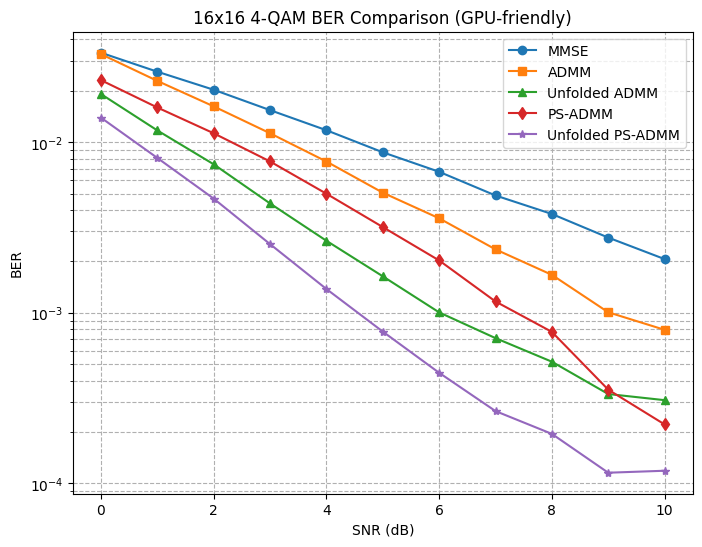

In [38]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helper (constellation etc)
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

# Torch version of quantization: computes nearest constellation point (batched)
def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    # compute squared distance using broadcasting
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]  # fancy indexing -> (B, U)
    return quant, idx

# numpy channel generator (small memory)
def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# -------------------------
# GPU-friendly detectors (batched)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    # y: (batch, B) complex, H: (batch, B, U)
    # solve (H^H H + noise_var I) x = H^H y  in batch via torch.linalg.solve
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    # solve A x = rhs
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    # Batched simple ADMM similar to your numpy single-sample version
    # y: (batch, B), H: (batch, B, U)
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # Precompute factor for solve: (HhH + rho I) . We'll solve with torch.linalg.solve each iter
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        # solve A x = Hy + rho*(z - lam)
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # Batched PS-ADMM (vectorized). Q derived from M (like original).
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    for _ in range(T):
        A = HhH + rho * I
        A_inv = None  # we use torch.linalg.solve when needed (avoid computing explicit inverse)
        # update xq for all q
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        # solve (HhH + rho I) x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)  # return combined estimate (batch, U)

# -------------------------
# Unfolded models (kept same but ensure device)
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# -------------------------
# Unified simulation (GPU-friendly)
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=20_000,        # reduce for safe runs; original was 200k
                       batch_size=2000,      # outer batch size (keeps random-generation semantics)
                       micro_batch=128,      # process micro-batches on GPU to avoid OOM
                       snr_db_list=np.arange(0, 17, 0.5),
                       device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)  # (C,)

    Q = int(np.sqrt(M)) // 2
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device).eval()
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=6).to(device).eval()

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate large batch in numpy (lower memory)
            H_batch_np = generate_channel_np(batch_size, B, U)               # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            # Map bits -> symbol indices (vectorized)
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)  # (batch, U)
            x_batch_np = constellation_np[idx_true]                         # (batch, U) complex
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            # compute y_batch = H @ x + noise  (numpy loop over batch is reasonably fast)
            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            # now process this big batch in micro-batches on GPU
            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                # convert micro-batch to torch
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B, U)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B)
                # ---- Classical batched detectors ----
                # MMSE
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)  # (mb, U)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)
                # ADMM (batched)
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)
                # PS-ADMM (classical batched)
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # ---- Unfolded networks ----
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)    # (mb, U)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)   # (mb, U)
                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # move indices to CPU numpy for BER counting (small arrays)
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                # count bit errors: compare bit_labels
                # bit_labels is (C, bits_per_symbol)
                bl = bit_labels  # numpy
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # free intermediate GPU memory aggressively
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (GPU-friendly)")
    plt.show()

# Example run (tune these):
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Reduce trials for first test; increase once stable.
    snr_db_list = np.arange(0, 11, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=20_000,       # lower than 200k for safe debugging
        batch_size=2000,
        micro_batch=128,     # lower micro-batch if OOM (e.g., 64)
        snr_db_list=snr_db_list,
        device=device
    )
    plot_unified(snr_db_list, ber)


SNR=0 dB | MMSE=3.32e-02, ADMM=3.23e-02, Unfolded ADMM=1.87e-02, PS-ADMM=2.26e-02, Unfolded PS-ADMM=1.36e-02
SNR=1 dB | MMSE=2.60e-02, ADMM=2.31e-02, Unfolded ADMM=1.19e-02, PS-ADMM=1.60e-02, Unfolded PS-ADMM=8.09e-03
SNR=2 dB | MMSE=2.01e-02, ADMM=1.62e-02, Unfolded ADMM=7.38e-03, PS-ADMM=1.12e-02, Unfolded PS-ADMM=4.66e-03
SNR=3 dB | MMSE=1.54e-02, ADMM=1.12e-02, Unfolded ADMM=4.46e-03, PS-ADMM=7.55e-03, Unfolded PS-ADMM=2.57e-03
SNR=4 dB | MMSE=1.17e-02, ADMM=7.67e-03, Unfolded ADMM=2.70e-03, PS-ADMM=5.08e-03, Unfolded PS-ADMM=1.40e-03
SNR=5 dB | MMSE=8.75e-03, ADMM=5.14e-03, Unfolded ADMM=1.66e-03, PS-ADMM=3.23e-03, Unfolded PS-ADMM=7.75e-04
SNR=6 dB | MMSE=6.61e-03, ADMM=3.46e-03, Unfolded ADMM=1.07e-03, PS-ADMM=1.99e-03, Unfolded PS-ADMM=4.87e-04
SNR=7 dB | MMSE=5.02e-03, ADMM=2.40e-03, Unfolded ADMM=7.40e-04, PS-ADMM=1.23e-03, Unfolded PS-ADMM=3.11e-04
SNR=8 dB | MMSE=3.72e-03, ADMM=1.63e-03, Unfolded ADMM=5.37e-04, PS-ADMM=7.18e-04, Unfolded PS-ADMM=2.04e-04
SNR=9 dB | MMSE=2.7

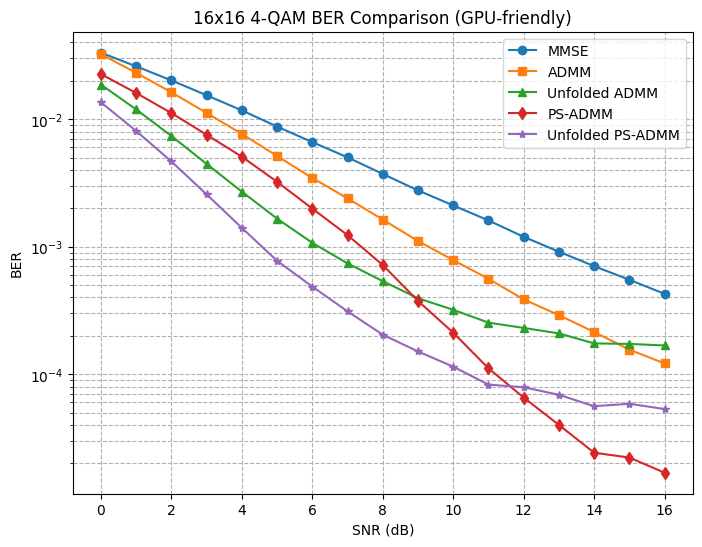

In [42]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helper (constellation etc)
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

# Torch version of quantization: computes nearest constellation point (batched)
def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    # compute squared distance using broadcasting
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]  # fancy indexing -> (B, U)
    return quant, idx

# numpy channel generator (small memory)
def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# -------------------------
# GPU-friendly detectors (batched)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    # y: (batch, B) complex, H: (batch, B, U)
    # solve (H^H H + noise_var I) x = H^H y  in batch via torch.linalg.solve
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    # solve A x = rhs
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    # Batched simple ADMM similar to your numpy single-sample version
    # y: (batch, B), H: (batch, B, U)
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # Precompute factor for solve: (HhH + rho I) . We'll solve with torch.linalg.solve each iter
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        # solve A x = Hy + rho*(z - lam)
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # Batched PS-ADMM (vectorized). Q derived from M (like original).
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    for _ in range(T):
        A = HhH + rho * I
        A_inv = None  # we use torch.linalg.solve when needed (avoid computing explicit inverse)
        # update xq for all q
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        # solve (HhH + rho I) x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)  # return combined estimate (batch, U)

# -------------------------
# Unfolded models (kept same but ensure device)
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# -------------------------
# Unified simulation (GPU-friendly)
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,        # reduce for safe runs; original was 200k
                       batch_size=2000,      # outer batch size (keeps random-generation semantics)
                       micro_batch=128,      # process micro-batches on GPU to avoid OOM
                       snr_db_list=np.arange(0, 17, 1),
                       device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)  # (C,)

    Q = int(np.sqrt(M)) // 2
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device).eval()
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=6).to(device).eval()

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate large batch in numpy (lower memory)
            H_batch_np = generate_channel_np(batch_size, B, U)               # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            # Map bits -> symbol indices (vectorized)
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)  # (batch, U)
            x_batch_np = constellation_np[idx_true]                         # (batch, U) complex
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            # compute y_batch = H @ x + noise  (numpy loop over batch is reasonably fast)
            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            # now process this big batch in micro-batches on GPU
            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                # convert micro-batch to torch
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B, U)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B)
                # ---- Classical batched detectors ----
                # MMSE
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)  # (mb, U)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)
                # ADMM (batched)
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)
                # PS-ADMM (classical batched)
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # ---- Unfolded networks ----
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)    # (mb, U)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)   # (mb, U)
                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # move indices to CPU numpy for BER counting (small arrays)
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                # count bit errors: compare bit_labels
                # bit_labels is (C, bits_per_symbol)
                bl = bit_labels  # numpy
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # free intermediate GPU memory aggressively
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (GPU-friendly)")
    plt.show()

# Example run (tune these):
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Reduce trials for first test; increase once stable.
    snr_db_list = np.arange(0, 17, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=200_000,       # lower than 200k for safe debugging
        batch_size=2000,
        micro_batch=128,     # lower micro-batch if OOM (e.g., 64)
        snr_db_list=snr_db_list,
        device=device
    )
    plot_unified(snr_db_list, ber)


## Train

Device: cuda
Preparing and training unfolded nets (this may take a while)...
[Unf-ADMM] Epoch 1/6 loss=4.6122e-02
[Unf-ADMM] Epoch 2/6 loss=4.4031e-02
[Unf-ADMM] Epoch 3/6 loss=4.1951e-02
[Unf-ADMM] Epoch 4/6 loss=3.9860e-02
[Unf-ADMM] Epoch 5/6 loss=3.7767e-02
[Unf-ADMM] Epoch 6/6 loss=3.5707e-02
[Unf-PS] Epoch 1/6 loss=3.1352e-02
[Unf-PS] Epoch 2/6 loss=2.7033e-02
[Unf-PS] Epoch 3/6 loss=2.3392e-02
[Unf-PS] Epoch 4/6 loss=2.0324e-02
[Unf-PS] Epoch 5/6 loss=1.7740e-02
[Unf-PS] Epoch 6/6 loss=1.5594e-02

Evaluating SNR = 0 dB ...
SNR 0 dB -> MMSE=3.29e-02, ADMM=6.01e-02, PS-ADMM=9.40e-02, Unf-ADMM=2.26e-02, Unf-PS=1.07e-02

Evaluating SNR = 1 dB ...
SNR 1 dB -> MMSE=2.57e-02, ADMM=5.08e-02, PS-ADMM=7.44e-02, Unf-ADMM=1.44e-02, Unf-PS=5.60e-03

Evaluating SNR = 2 dB ...
SNR 2 dB -> MMSE=2.00e-02, ADMM=4.31e-02, PS-ADMM=5.86e-02, Unf-ADMM=8.51e-03, Unf-PS=2.48e-03

Evaluating SNR = 3 dB ...
SNR 3 dB -> MMSE=1.54e-02, ADMM=3.60e-02, PS-ADMM=4.29e-02, Unf-ADMM=4.58e-03, Unf-PS=9.86e-04

Ev

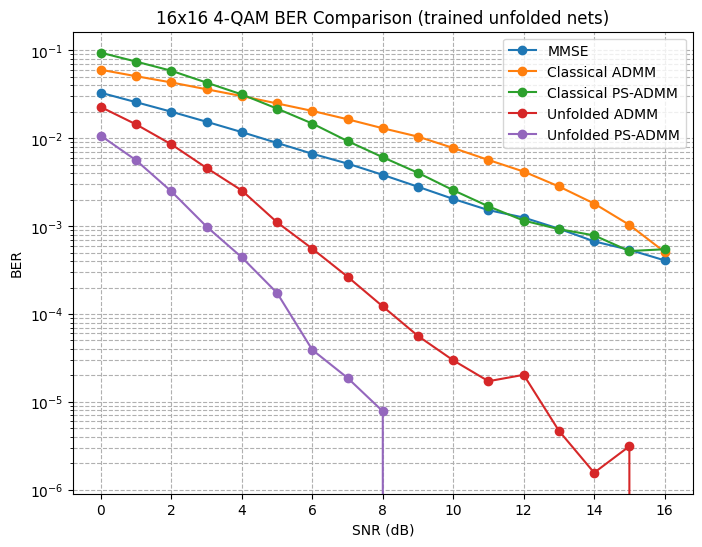

Done.


In [45]:
# pytorch_unified_mimo.py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

# -------------------------
# Config (tune these)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# System
U = 16      # transmit dims
B = 16      # receive dims
M = 4       # 4-QAM
bits_per_symbol = int(np.log2(M))

# Simulation / memory controls
trials = 20000           # total samples per SNR (lower to test)
outer_batch = 2000       # generate this many samples per outer loop
micro_batch = 128        # GPU micro-batch (reduce if OOM)
snr_db_list = np.arange(0, 17, 1)

# Training (unfolded nets)
train_samples = 4000
train_batch = 128
train_epochs = 6
train_snr_db = 10.0
lr = 1e-3

# Iteration counts
classical_admm_iters = 20
classical_ps_iters = 15
unfolded_admm_layers = 6
unfolded_ps_layers = 6

# PS-ADMM Q
m_side = int(np.sqrt(M))
Q_ps = max(1, m_side // 2)  # for M=4 -> Q=1

# -------------------------
# Constellation helpers
# -------------------------
def build_constellation(M):
    if M == 4:
        c = np.array([1+1j, 1-1j, -1+1j, -1-1j], dtype=np.complex128) / np.sqrt(2)
        bits = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=int)
        return c, bits
    raise NotImplementedError("Only 4-QAM implemented")

constellation_np, bit_labels = build_constellation(M)
constellation = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)  # (C,)

def quantize_to_constellation_torch(x, constellation_t=constellation):
    # x: (..., U) complex. returns quantized symbols and indices
    orig_shape = x.shape
    Uloc = orig_shape[-1]
    flat = x.reshape(-1, Uloc)  # (N, U)
    N = flat.shape[0]
    C = constellation.shape[0]
    flat_exp = flat.view(N * Uloc, 1)
    const_exp = constellation.view(1, C)
    d2 = torch.abs(flat_exp - const_exp)**2  # (N*U, C)
    idx = torch.argmin(d2, dim=1).view(N, Uloc)
    idx = idx.view(*orig_shape[:-1], Uloc)
    quant = constellation[idx]
    return quant, idx

def hard_project_4qam(x):
    # element-wise nearest 4-QAM: sign(real) + j sign(imag) normalized
    sr = torch.sign(x.real)
    si = torch.sign(x.imag)
    sr[sr == 0] = 1.0
    si[si == 0] = 1.0
    return torch.complex(sr, si) / np.sqrt(2.0)

# -------------------------
# Channel / dataset (torch-only)
# -------------------------
def generate_channel(batch, B, U, device='cpu'):
    return (torch.randn(batch, B, U, dtype=torch.float32, device=device)
            + 1j * torch.randn(batch, B, U, dtype=torch.float32, device=device)) / np.sqrt(2)

def generate_symbols_indices(batch, U, M):
    return np.random.randint(0, M, size=(batch, U))

def map_indices_to_symbols(idx_np):
    return constellation_np[idx_np]  # numpy complex

def make_torch_dataset(num_samples, U, B, snr_db, device=device):
    H = generate_channel(num_samples, B, U, device=device)  # (N,B,U) complex
    idxs = generate_symbols_indices(num_samples, U, M)      # numpy
    x_np = map_indices_to_symbols(idxs)                      # (N,U) numpy complex
    x = torch.tensor(x_np, dtype=torch.cfloat, device=device)
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1.0 / snr_lin
    noise = (torch.randn(num_samples, B, dtype=torch.float32, device=device)
             + 1j * torch.randn(num_samples, B, dtype=torch.float32, device=device)) * np.sqrt(noise_var/2)
    y = torch.einsum('nbu,nu->nb', H, x) + noise
    return H, y, x, idxs

# -------------------------
# Classical batched detectors
# -------------------------
def mmse_detector_batch(y, H, noise_var):
    # y: (batch,B) complex; H: (batch,B,U)
    Hh = torch.conj(H).permute(0,2,1)  # (batch,U,B)
    HhH = torch.bmm(Hh, H)             # (batch,U,U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
    batch, Uloc, _ = HhH.shape
    I = torch.eye(Uloc, dtype=HhH.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def classical_admm_batch(y, H, rho=1.0, max_iter=20):
    batch, B, Uloc = H.shape
    Hh = torch.conj(H).permute(0,2,1)
    HhH = torch.bmm(Hh, H)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
    I = torch.eye(Uloc, dtype=HhH.dtype, device=H.device).unsqueeze(0)
    A = HhH + rho * I
    x = torch.zeros(batch, Uloc, dtype=torch.cfloat, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x = torch.linalg.solve(A, rhs).squeeze(-1)
        z = hard_project_4qam(x + lam)
        lam = lam + x - z
    return z

def classical_psadmm_batch(H, y, M=M, rho=1.0, alpha=0.01, T=15):
    batch, B, Uloc = H.shape
    device_local = H.device
    m_side = int(np.sqrt(M))
    Q = max(1, m_side // 2)
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device_local)
    Hh = torch.conj(H).permute(0,2,1)
    HhH = torch.bmm(Hh, H)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
    I = torch.eye(Uloc, dtype=torch.cfloat, device=device_local).unsqueeze(0)

    xq = torch.zeros(batch, Q, Uloc, dtype=torch.cfloat, device=device_local)
    x0 = torch.zeros(batch, Uloc, dtype=torch.cfloat, device=device_local)
    dual_y = torch.zeros(batch, Uloc, dtype=torch.cfloat, device=device_local)

    for _ in range(T):
        A = HhH + rho * I
        for q in range(Q):
            sum_scaled = torch.sum(scales.view(1,-1,1) * xq, dim=1) - scales[q] * xq[:, q, :]
            # numerator and denom (correct signs): denom = rho * s_q^2 + alpha
            numer = scales[q] * (rho * (x0 - sum_scaled) + dual_y)
            denom = (rho * (scales[q] * scales[q]).real + alpha)
            x_new = numer / denom
            # small clamp to avoid explosion; then clip to plausible range
            xq[:, q, :] = torch.clamp(x_new.real, -2.0, 2.0) + 1j * torch.clamp(x_new.imag, -2.0, 2.0)
        sum_scaled = torch.sum(scales.view(1,-1,1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)

    return torch.sum(scales.view(1,-1,1) * xq, dim=1)

# -------------------------
# Unfolded models (trainable)
# -------------------------
def soft_proj_tanh(x, beta):
    return torch.complex(torch.tanh(beta * x.real), torch.tanh(beta * x.imag))

class UnfoldedADMM(nn.Module):
    def __init__(self, Uloc, layers=6):
        super().__init__()
        self.U = Uloc
        self.L = layers
        self.log_rho = nn.Parameter(torch.zeros(self.L))   # rho = exp(log_rho)
        self.beta = nn.Parameter(torch.tensor(2.0))        # soft projection sharpness

    def forward(self, y, H):
        batch = y.shape[0]
        Hh = torch.conj(H).permute(0,2,1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(self.U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros(batch, self.U, dtype=torch.cfloat, device=H.device)
        z = torch.zeros_like(x)
        lam = torch.zeros_like(x)
        for l in range(self.L):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            rhs = (Hhy + rho * (z - lam)).unsqueeze(-1)
            x = torch.linalg.solve(A, rhs).squeeze(-1)
            z = soft_proj_tanh(x + lam, self.beta)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, Uloc, Q=1, L=6):
        super().__init__()
        self.U = Uloc
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(self.L))
        self.alpha = nn.Parameter(torch.ones(self.L) * 0.01)
        self.beta = nn.Parameter(torch.tensor(2.0))
        self.register_buffer('scales', torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat))

    def forward(self, H, y):
        batch = y.shape[0]
        device_local = H.device
        scales = self.scales.to(device_local)
        Hh = torch.conj(H).permute(0,2,1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(self.U, dtype=torch.cfloat, device=device_local).unsqueeze(0)

        xq = torch.zeros(batch, self.Q, self.U, dtype=torch.cfloat, device=device_local)
        x0 = torch.zeros(batch, self.U, dtype=torch.cfloat, device=device_local)
        dual_y = torch.zeros(batch, self.U, dtype=torch.cfloat, device=device_local)

        for l in range(self.L):
            rho_l = self.rho[l]
            alpha_l = self.alpha[l]
            A = HhH + rho_l * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1,-1,1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = scales[q] * (rho_l * (x0 - sum_scaled) + dual_y)
                denom = (rho_l * (scales[q] * scales[q]).real + alpha_l)
                x_new = numer / denom
                xq[:, q, :] = soft_proj_tanh(x_new, self.beta)
            sum_scaled = torch.sum(scales.view(1,-1,1) * xq, dim=1)
            rhs = Hhr + rho_l * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho_l * (x0 - sum_scaled)
        return x0

# -------------------------
# Training functions
# -------------------------
def train_unfolded_admm(model, samples=train_samples, snr_db=train_snr_db, epochs=train_epochs, batch_size=train_batch, lr=lr):
    model.train().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    H_np, y_np, x_np, _ = make_torch_training_set(samples, U, B, snr_db)
    dataset = TorchArrayDataset(H_np, y_np, x_np)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    for ep in range(epochs):
        running = 0.0
        for Hc, yc, xc in loader:
            Hc = Hc.to(device); yc = yc.to(device); xc = xc.to(device)
            opt.zero_grad()
            xhat = model(yc, Hc)
            loss = loss_fn(xhat.real, xc.real) + loss_fn(xhat.imag, xc.imag)
            loss.backward()
            opt.step()
            running += loss.item()
        print(f"[Unf-ADMM] Epoch {ep+1}/{epochs} loss={running/len(loader):.4e}")
    model.eval()
    return model

def train_unfolded_psadmm(model, samples=train_samples, snr_db=train_snr_db, epochs=train_epochs, batch_size=train_batch, lr=lr):
    model.train().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    H_np, y_np, x_np, _ = make_torch_training_set(samples, U, B, snr_db)
    dataset = TorchArrayDataset(H_np, y_np, x_np)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    for ep in range(epochs):
        running = 0.0
        for Hc, yc, xc in loader:
            Hc = Hc.to(device); yc = yc.to(device); xc = xc.to(device)
            opt.zero_grad()
            xhat = model(Hc, yc)
            loss = loss_fn(xhat.real, xc.real) + loss_fn(xhat.imag, xc.imag)
            loss.backward()
            opt.step()
            running += loss.item()
        print(f"[Unf-PS] Epoch {ep+1}/{epochs} loss={running/len(loader):.4e}")
    model.eval()
    return model

# Small helper dataset wrapper used in training
class TorchArrayDataset(torch.utils.data.Dataset):
    def __init__(self, H, y, x):
        # inputs are torch tensors on CPU
        self.H = H
        self.y = y
        self.x = x
    def __len__(self):
        return self.H.shape[0]
    def __getitem__(self, idx):
        return self.H[idx], self.y[idx], self.x[idx]

def make_torch_training_set(samples, U, B, snr_db):
    # produce CPU tensors for DataLoader (we'll move micro-batches to device during training)
    H = generate_channel(samples, B, U, device='cpu')  # cpu complex float
    idxs = generate_symbols_indices(samples, U, M)
    x_np = map_indices_to_symbols(idxs)
    x = torch.tensor(x_np, dtype=torch.cfloat, device='cpu')
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1.0 / snr_lin
    noise = (torch.randn(samples, B, dtype=torch.float32, device='cpu') + 1j * torch.randn(samples, B, dtype=torch.float32, device='cpu')) * np.sqrt(noise_var/2)
    y = torch.einsum('nbu,nu->nb', H, x) + noise
    return H, y, x, idxs

# -------------------------
# BER evaluation
# -------------------------
def ber_evaluate(detector_fn, snr_db, trials_total=trials, outer_bs=outer_batch, micro_bs=micro_batch):
    errors = 0
    total_bits = 0
    num_outer = max(1, trials_total // outer_bs)
    for _ in range(num_outer):
        H_batch = generate_channel(outer_bs, B, U, device='cpu').numpy()  # use numpy for indexing
        idxs = np.random.randint(0, M, size=(outer_bs, U))
        x_batch_np = map_indices_to_symbols(idxs)
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin
        noise = (np.sqrt(noise_var/2) * (np.random.randn(outer_bs, B) + 1j*np.random.randn(outer_bs, B)))
        y_batch_np = np.einsum('nbu,nu->nb', H_batch, x_batch_np) + noise

        # micro-batch to GPU
        num_micro = int(np.ceil(outer_bs / micro_bs))
        for m in range(num_micro):
            s = m * micro_bs
            e = min(outer_bs, (m+1) * micro_bs)
            mb = e - s
            H_mb = torch.tensor(H_batch[s:e], dtype=torch.cfloat, device=device)
            y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)

            with torch.no_grad():
                xhat = detector_fn(y_mb, H_mb)
            _, idx_hat = quantize_to_constellation_torch(xhat, constellation)
            idx_hat_np = idx_hat.cpu().numpy()
            true_idx = idxs[s:e]
            errors += np.sum(bit_labels[idx_hat_np] != bit_labels[true_idx])
            total_bits += mb * U * bits_per_symbol

            del H_mb, y_mb, xhat, idx_hat
            if device.type == 'cuda':
                torch.cuda.empty_cache()
    return errors / (total_bits + 1e-30)

# -------------------------
# Main: train unfolded nets THEN run simulations
# -------------------------
if __name__ == "__main__":
    print("Device:", device)
    print("Preparing and training unfolded nets (this may take a while)...")

    # instantiate unfolded models
    model_unf_admm = UnfoldedADMM(Uloc=U, layers=unfolded_admm_layers).to(device)
    model_unf_ps = UnfoldedPSADMM(Uloc=U, Q=Q_ps, L=unfolded_ps_layers).to(device)

    # Train unfolded ADMM
    model_unf_admm = train_unfolded_admm(model_unf_admm,
                                         samples=train_samples,
                                         snr_db=train_snr_db,
                                         epochs=train_epochs,
                                         batch_size=train_batch,
                                         lr=lr)

    # Train unfolded PS-ADMM
    model_unf_ps = train_unfolded_psadmm(model_unf_ps,
                                         samples=train_samples,
                                         snr_db=train_snr_db,
                                         epochs=train_epochs,
                                         batch_size=train_batch,
                                         lr=lr)

    # After training, run BER vs SNR comparison
    results = {"MMSE": [], "Classical ADMM": [], "Classical PS-ADMM": [], "Unfolded ADMM": [], "Unfolded PS-ADMM": []}

    for snr_db in snr_db_list:
        print(f"\nEvaluating SNR = {snr_db} dB ...")
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        # wrappers
        def mmse_fn(y_mb, H_mb, nv=noise_var):
            return mmse_detector_batch(y_mb, H_mb, nv)

        def admm_fn(y_mb, H_mb):
            return classical_admm_batch(y_mb, H_mb, rho=1.0, max_iter=classical_admm_iters)

        def ps_fn(y_mb, H_mb):
            return classical_psadmm_batch(H_mb, y_mb, M=M, rho=1.0, alpha=0.01, T=classical_ps_iters)

        def unf_admm_fn(y_mb, H_mb):
            return model_unf_admm(y_mb, H_mb)

        def unf_ps_fn(y_mb, H_mb):
            return model_unf_ps(H_mb, y_mb)

        ber_mmse = ber_evaluate(mmse_fn, snr_db)
        ber_admm = ber_evaluate(admm_fn, snr_db)
        ber_ps = ber_evaluate(ps_fn, snr_db)
        ber_unf_admm = ber_evaluate(unf_admm_fn, snr_db)
        ber_unf_ps = ber_evaluate(unf_ps_fn, snr_db)

        results["MMSE"].append(ber_mmse)
        results["Classical ADMM"].append(ber_admm)
        results["Classical PS-ADMM"].append(ber_ps)
        results["Unfolded ADMM"].append(ber_unf_admm)
        results["Unfolded PS-ADMM"].append(ber_unf_ps)

        print(f"SNR {snr_db} dB -> MMSE={ber_mmse:.2e}, ADMM={ber_admm:.2e}, PS-ADMM={ber_ps:.2e}, Unf-ADMM={ber_unf_admm:.2e}, Unf-PS={ber_unf_ps:.2e}")

    # Plot
    plt.figure(figsize=(8,6))
    for k, m in results.items():
        plt.semilogy(snr_db_list, results[k], marker='o', label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.title(f"{U}x{B} {M}-QAM BER Comparison (trained unfolded nets)")
    plt.legend()
    plt.show()

    print("Done.")


## TRY

Using device: cuda
Training Unfolded ADMM...
Unfolded ADMM Epoch 0, Loss: 0.028884
Unfolded ADMM Epoch 10, Loss: 0.023301
Unfolded ADMM Epoch 20, Loss: 0.023071
Unfolded ADMM Epoch 30, Loss: 0.023041
Unfolded ADMM Epoch 40, Loss: 0.023036
Training Unfolded PS-ADMM...
Unfolded PS-ADMM Epoch 0, Loss: 0.008686
Unfolded PS-ADMM Epoch 10, Loss: 0.938831
Unfolded PS-ADMM Epoch 20, Loss: 0.915745
Unfolded PS-ADMM Epoch 30, Loss: 0.866036
Unfolded PS-ADMM Epoch 40, Loss: 0.809084
SNR=0 dB | MMSE=3.31e-02, ADMM=3.21e-02, Unfolded ADMM=1.86e-02, PS-ADMM=2.24e-02, Unfolded PS-ADMM=3.87e-02
SNR=1 dB | MMSE=2.60e-02, ADMM=2.31e-02, Unfolded ADMM=1.17e-02, PS-ADMM=1.60e-02, Unfolded PS-ADMM=3.30e-02
SNR=2 dB | MMSE=2.01e-02, ADMM=1.62e-02, Unfolded ADMM=7.11e-03, PS-ADMM=1.12e-02, Unfolded PS-ADMM=2.81e-02
SNR=3 dB | MMSE=1.54e-02, ADMM=1.13e-02, Unfolded ADMM=4.24e-03, PS-ADMM=7.63e-03, Unfolded PS-ADMM=2.46e-02
SNR=4 dB | MMSE=1.16e-02, ADMM=7.65e-03, Unfolded ADMM=2.43e-03, PS-ADMM=5.06e-03, Unfo

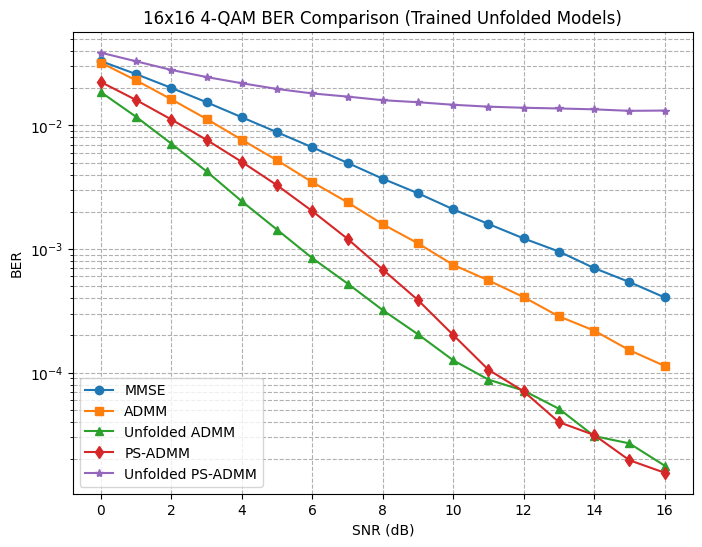

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helper (constellation etc)
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

# Torch version of quantization: computes nearest constellation point (batched)
def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    # compute squared distance using broadcasting
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]  # fancy indexing -> (B, U)
    return quant, idx

# numpy channel generator (small memory)
def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# -------------------------
# GPU-friendly detectors (batched)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    # y: (batch, B) complex, H: (batch, B, U)
    # solve (H^H H + noise_var I) x = H^H y  in batch via torch.linalg.solve
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    # solve A x = rhs
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    # Batched simple ADMM similar to your numpy single-sample version
    # y: (batch, B), H: (batch, B, U)
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # Precompute factor for solve: (HhH + rho I) . We'll solve with torch.linalg.solve each iter
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        # solve A x = Hy + rho*(z - lam)
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # Batched PS-ADMM (vectorized). Q derived from M (like original).
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    for _ in range(T):
        A = HhH + rho * I
        A_inv = None  # we use torch.linalg.solve when needed (avoid computing explicit inverse)
        # update xq for all q
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        # solve (HhH + rho I) x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)  # return combined estimate (batch, U)

# -------------------------
# Unfolded models (kept same but ensure device)
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# -------------------------
# Training functions for unfolded models
# -------------------------
def train_unfolded_admm(model, train_loader, num_epochs=50, lr=0.01, device="cuda"):
    """Train Unfolded ADMM model"""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (H_batch, y_batch, x_true_batch) in enumerate(train_loader):
            H_batch = H_batch.to(device)
            y_batch = y_batch.to(device)
            x_true_batch = x_true_batch.to(device)
            
            optimizer.zero_grad()
            x_pred = model(y_batch, H_batch)
            loss = criterion(x_pred.real, x_true_batch.real) + criterion(x_pred.imag, x_true_batch.imag)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f'Unfolded ADMM Epoch {epoch}, Loss: {avg_loss:.6f}')
    
    return epoch_losses

def train_unfolded_psadmm(model, train_loader, num_epochs=50, lr=0.01, device="cuda"):
    """Train Unfolded PS-ADMM model"""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (H_batch, y_batch, x_true_batch) in enumerate(train_loader):
            H_batch = H_batch.to(device)
            y_batch = y_batch.to(device)
            x_true_batch = x_true_batch.to(device)
            
            optimizer.zero_grad()
            x_pred = model(H_batch, y_batch)
            loss = criterion(x_pred.real, x_true_batch.real) + criterion(x_pred.imag, x_true_batch.imag)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f'Unfolded PS-ADMM Epoch {epoch}, Loss: {avg_loss:.6f}')
    
    return epoch_losses

def generate_training_data(num_samples, B, U, M, snr_range=(5, 20), batch_size=128):
    """Generate training data with random SNR"""
    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    dataset = []
    num_batches = num_samples // batch_size
    
    for _ in range(num_batches):
        # Random SNR for each batch
        snr_db = np.random.uniform(snr_range[0], snr_range[1])
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin
        
        H_batch_np = generate_channel_np(batch_size, B, U)
        bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
        idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)
        x_batch_np = constellation_np[idx_true]
        
        noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
        y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
        for b in range(batch_size):
            y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]
        
        # Convert to torch tensors
        H_torch = torch.tensor(H_batch_np, dtype=torch.cfloat)
        y_torch = torch.tensor(y_batch_np, dtype=torch.cfloat)
        x_torch = torch.tensor(x_batch_np, dtype=torch.cfloat)
        
        dataset.append((H_torch, y_torch, x_torch))
    
    return dataset

# -------------------------
# Unified simulation (GPU-friendly)
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,        # reduce for safe runs; original was 200k
                       batch_size=2000,      # outer batch size (keeps random-generation semantics)
                       micro_batch=128,      # process micro-batches on GPU to avoid OOM
                       snr_db_list=np.arange(0, 17, 1),
                       device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)  # (C,)

    Q = int(np.sqrt(M)) // 2
    
    # Initialize and train unfolded models
    print("Training Unfolded ADMM...")
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device)
    train_data_admm = generate_training_data(10000, B, U, M, snr_range=(5, 20), batch_size=128)
    train_unfolded_admm(unfolded_admm, train_data_admm, num_epochs=50, lr=0.01, device=device)
    unfolded_admm.eval()
    
    print("Training Unfolded PS-ADMM...")
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=6).to(device)
    train_data_psadmm = generate_training_data(10000, B, U, M, snr_range=(5, 20), batch_size=128)
    train_unfolded_psadmm(unfolded_psadmm, train_data_psadmm, num_epochs=50, lr=0.01, device=device)
    unfolded_psadmm.eval()

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate large batch in numpy (lower memory)
            H_batch_np = generate_channel_np(batch_size, B, U)               # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            # Map bits -> symbol indices (vectorized)
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)  # (batch, U)
            x_batch_np = constellation_np[idx_true]                         # (batch, U) complex
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            # compute y_batch = H @ x + noise  (numpy loop over batch is reasonably fast)
            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            # now process this big batch in micro-batches on GPU
            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                # convert micro-batch to torch
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B, U)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B)
                # ---- Classical batched detectors ----
                # MMSE
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)  # (mb, U)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)
                # ADMM (batched)
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)
                # PS-ADMM (classical batched)
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # ---- Unfolded networks ----
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)    # (mb, U)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)   # (mb, U)
                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # move indices to CPU numpy for BER counting (small arrays)
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                # count bit errors: compare bit_labels
                # bit_labels is (C, bits_per_symbol)
                bl = bit_labels  # numpy
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # free intermediate GPU memory aggressively
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (Trained Unfolded Models)")
    plt.show()

# Example run (tune these):
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Reduce trials for first test; increase once stable.
    snr_db_list = np.arange(0, 17, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=200_000,       # lower than 200k for safe debugging
        batch_size=2000,
        micro_batch=128,     # lower micro-batch if OOM (e.g., 64)
        snr_db_list=snr_db_list,
        device=device
    )
    plot_unified(snr_db_list, ber)

In [47]:
# Cell 2: Fix the PS-ADMM architecture - Major issues found!
class FixedUnfoldedPSADMMReal(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.U_real = 2 * U
        self.Q = Q
        self.L = L
        
        # CRITICAL FIX: Use MUCH smaller learning rates for PS-ADMM parameters
        # PS-ADMM is very sensitive to parameter changes
        self.log_rho = nn.Parameter(torch.tensor(np.log(1.5)))  # Single parameter across layers
        self.log_alpha = nn.Parameter(torch.tensor(np.log(0.001)))  # Start very small
        
        # Remove step_size parameter - it's causing instability
        # Use fixed step size of 1.0 (standard in ADMM)

    def forward(self, H, y):
        batch_size, N_real, U_real = H.shape
        xq = torch.zeros(batch_size, self.Q, U_real, dtype=H.dtype, device=H.device)
        x0 = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        dual_y = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=H.dtype, device=H.device)
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        
        # CRITICAL: Constrain parameters to prevent divergence
        rho = torch.exp(self.log_rho).clamp(0.5, 3.0)  # Tighter bounds
        alpha = torch.exp(self.log_alpha).clamp(1e-6, 0.01)  # Much tighter bounds
        
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        A_inv = torch.linalg.inv(HtH + rho * I)
        
        for l in range(self.L):
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                
                # CRITICAL: Add numerical stability with proper clamping
                denom = torch.where(denom.abs() < 1e-10, torch.sign(denom) * 1e-10, denom)
                
                x_new = (scales[q] / denom) * numer
                
                # Use HARD projection instead of soft for stability during training
                scale = 1.0 / np.sqrt(2)
                xq[:, q, :] = torch.clamp(x_new, -scale, scale)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            
            # CRITICAL: Fixed step size = 1.0 (standard ADMM)
            dual_y = dual_y + 1.0 * (x0 - sum_scaled)
        
        return x0

print("Fixed PS-ADMM architecture defined")

Fixed PS-ADMM architecture defined


In [48]:
# Cell 3: Also fix the training procedure for PS-ADMM
def train_psadmm_correctly(unfolded_psadmm, train_samples=1000, epochs=50):
    """Proper training for PS-ADMM with stability measures."""
    print("Training Unfolded PS-ADMM with stability fixes...")
    
    device = next(unfolded_psadmm.parameters()).device
    optimizer = torch.optim.Adam(unfolded_psadmm.parameters(), lr=0.001)  # MUCH smaller LR
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    best_loss = float('inf')
    patience_counter = 0
    max_patience = 10
    
    for epoch in range(epochs):
        unfolded_psadmm.train()
        total_loss = 0
        num_batches = 0
        
        for _ in range(train_samples // 50):  # Smaller batches
            try:
                # Generate training data with moderate SNR
                snr_db = np.random.uniform(5, 15)  # Avoid extreme SNRs during training
                y_real, H_real, x_real, _, _, _, _, _, _ = generate_long_codeword_data(
                    16, 16, 4, num_symbols=50, snr_db=snr_db, 
                    codeword_idx=np.random.randint(1000)
                )
                
                H_tensor = torch.tensor(H_real, dtype=torch.float32, device=device).unsqueeze(0)
                y_tensor = torch.tensor(y_real[:1], dtype=torch.float32, device=device)
                x_tensor = torch.tensor(x_real[:1], dtype=torch.float32, device=device)
                
                # Forward pass
                x_hat = unfolded_psadmm(H_tensor, y_tensor)
                
                # Loss with gradient clipping in forward pass
                loss = torch.mean((x_hat - x_tensor) ** 2)
                
                # Early stopping if loss explodes
                if loss.item() > 10.0:  # Loss explosion threshold
                    print(f"  Loss explosion detected: {loss.item():.4f}, skipping batch")
                    continue
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                
                # GRADIENT CLIPPING - CRITICAL for PS-ADMM
                torch.nn.utils.clip_grad_norm_(unfolded_psadmm.parameters(), max_norm=0.1)  # Tighter
                
                optimizer.step()
                total_loss += loss.item()
                num_batches += 1
                
            except Exception as e:
                print(f"  Training error: {e}, skipping batch")
                continue
        
        if num_batches > 0:
            avg_loss = total_loss / num_batches
            scheduler.step(avg_loss)
            
            if epoch % 5 == 0:
                print(f"  Epoch {epoch}: Loss = {avg_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.6f}")
                print(f"    Parameters - rho: {torch.exp(unfolded_psadmm.log_rho).item():.4f}, "
                      f"alpha: {torch.exp(unfolded_psadmm.log_alpha).item():.6f}")
            
            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= max_patience:
                    print(f"  Early stopping at epoch {epoch}")
                    break
        else:
            print(f"  Epoch {epoch}: No successful batches")
    
    return unfolded_psadmm

print("Corrected PS-ADMM training function defined")

Corrected PS-ADMM training function defined


In [49]:
# Cell 4: Test the fixed PS-ADMM
def test_fixed_psadmm():
    """Test the fixed PS-ADMM architecture."""
    print("\nTesting fixed PS-ADMM...")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    B, U, M = 8, 8, 4
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    
    # Initialize fixed PS-ADMM
    unfolded_psadmm_fixed = FixedUnfoldedPSADMMReal(U=U, Q=Q, L=5).to(device)  # Fewer layers for stability
    
    print("Initial parameters:")
    print(f"  rho: {torch.exp(unfolded_psadmm_fixed.log_rho).item():.4f}")
    print(f"  alpha: {torch.exp(unfolded_psadmm_fixed.log_alpha).item():.6f}")
    
    # Quick training test
    unfolded_psadmm_fixed = train_psadmm_correctly(unfolded_psadmm_fixed, train_samples=200, epochs=20)
    
    # Test performance
    snr_db = 10
    y_real, H_real, x_real, true_bits, constellation, bit_labels, total_bits, bits_per_symbol, U_val = generate_long_codeword_data(
        B, U, M, num_symbols=100, snr_db=snr_db, codeword_idx=999
    )
    
    H_tensor = torch.tensor(np.tile(H_real[np.newaxis, :, :], (100, 1, 1)), dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y_real, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        # Classical PS-ADMM
        x_psadmm = ps_admm_detect_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (100, 1, 1)), M)
        ber_psadmm = calculate_ber_long_codeword(x_psadmm, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
        
        # Fixed Unfolded PS-ADMM
        x_unfolded_psadmm = unfolded_psadmm_fixed(H_tensor, y_tensor).cpu().numpy()
        ber_unfolded_psadmm = calculate_ber_long_codeword(x_unfolded_psadmm, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
    
    print(f"Results after fixing:")
    print(f"  Classical PS-ADMM:      {ber_psadmm:.4f}")
    print(f"  Fixed Unfolded PS-ADMM: {ber_unfolded_psadmm:.4f}")
    
    if ber_unfolded_psadmm <= ber_psadmm * 1.2:  # Within 20%
        print("✅ Fixed PS-ADMM working!")
    else:
        print("❌ PS-ADMM still needs work")

test_fixed_psadmm()


Testing fixed PS-ADMM...
Initial parameters:
  rho: 1.5000
  alpha: 0.001000
Training Unfolded PS-ADMM with stability fixes...
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Epoch 0: No successful batches
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Epoch 1: No successful batches
  Training error: name 'generate_long_codeword_data' is not defined, skipping batch
  Training error: name 'generate_long_codeword_dat

NameError: name 'generate_long_codeword_data' is not defined


=== Training Unfolded Detectors ===
Epoch 1/8 | Loss = 4.0330e-02
Epoch 2/8 | Loss = 2.1995e-02
Epoch 3/8 | Loss = 1.6058e-02
Epoch 4/8 | Loss = 1.3939e-02
Epoch 5/8 | Loss = 1.2501e-02
Epoch 6/8 | Loss = 1.1396e-02
Epoch 7/8 | Loss = 1.0637e-02
Epoch 8/8 | Loss = 1.0132e-02
=== Training Complete ===

SNR=0 dB | MMSE=3.32e-02, ADMM=3.21e-02, Unfolded ADMM=6.64e-02, PS-ADMM=2.24e-02, Unfolded PS-ADMM=3.53e-02
SNR=1 dB | MMSE=2.59e-02, ADMM=2.32e-02, Unfolded ADMM=4.89e-02, PS-ADMM=1.61e-02, Unfolded PS-ADMM=2.58e-02
SNR=2 dB | MMSE=2.01e-02, ADMM=1.62e-02, Unfolded ADMM=3.46e-02, PS-ADMM=1.11e-02, Unfolded PS-ADMM=1.84e-02
SNR=3 dB | MMSE=1.54e-02, ADMM=1.12e-02, Unfolded ADMM=2.32e-02, PS-ADMM=7.63e-03, Unfolded PS-ADMM=1.31e-02
SNR=4 dB | MMSE=1.17e-02, ADMM=7.59e-03, Unfolded ADMM=1.48e-02, PS-ADMM=4.99e-03, Unfolded PS-ADMM=9.25e-03
SNR=5 dB | MMSE=8.86e-03, ADMM=5.19e-03, Unfolded ADMM=9.17e-03, PS-ADMM=3.27e-03, Unfolded PS-ADMM=6.57e-03
SNR=6 dB | MMSE=6.62e-03, ADMM=3.51e-03, U

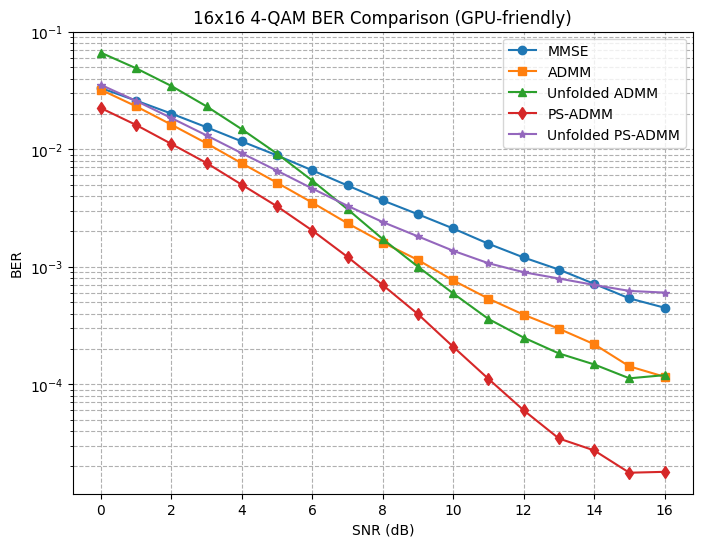

In [51]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helper (constellation etc)
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

# Torch version of quantization: computes nearest constellation point (batched)
def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    # compute squared distance using broadcasting
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]  # fancy indexing -> (B, U)
    return quant, idx

# numpy channel generator (small memory)
def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# -------------------------
# GPU-friendly detectors (batched)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    # y: (batch, B) complex, H: (batch, B, U)
    # solve (H^H H + noise_var I) x = H^H y  in batch via torch.linalg.solve
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    # solve A x = rhs
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    # Batched simple ADMM similar to your numpy single-sample version
    # y: (batch, B), H: (batch, B, U)
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # Precompute factor for solve: (HhH + rho I) . We'll solve with torch.linalg.solve each iter
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        # solve A x = Hy + rho*(z - lam)
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # Batched PS-ADMM (vectorized). Q derived from M (like original).
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    for _ in range(T):
        A = HhH + rho * I
        # update xq for all q
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        # solve (HhH + rho I) x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)  # return combined estimate (batch, U)

# -------------------------
# Unfolded models (kept same but ensure device)
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# -------------------------
# Complex-safe MSE helper
# -------------------------
def complex_mse(x_hat, x_true):
    # both are complex tensors
    return torch.mean((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2)

# =====================================================
# TRAINING FOR UNFOLDED MODELS
# =====================================================
def train_unfolded_models(U, B, M, device,
                          epochs=10,
                          train_batches=600,
                          batch_size=256,
                          snr_db=10):

    print("\n=== Training Unfolded Detectors ===")

    bits_per_symbol = int(np.log2(M))
    constellation_np, _ = build_constellation(M)

    # teacher: MMSE always stable
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin

    Q = int(np.sqrt(M)) // 2

    # create models and move to device
    model_ADMM = UnfoldedADMM(num_layers=5, M=U).to(device)
    model_PSADMM = UnfoldedPSADMM(U=U, Q=Q, L=6).to(device)

    opt = torch.optim.Adam(
        list(model_ADMM.parameters()) + list(model_PSADMM.parameters()),
        lr=1e-3
    )

    for ep in range(1, epochs+1):
        avg_loss = 0.0

        for _ in range(train_batches):
            # ---- generate training batch ----
            bits = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            idx_true = (bits * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            H_np = generate_channel_np(batch_size, B, U)
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size,B))

            y_np = np.zeros((batch_size, B), dtype=np.complex128)
            for bb in range(batch_size):
                y_np[bb] = H_np[bb] @ x_np[bb] + noise_np[bb]

            # ---- move to torch ----
            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)

            # teacher MMSE target (complex)
            x_mmse = mmse_detector_batch_torch(y, H, noise_var)

            # forward unfolded detectors
            x_hat_admm = model_ADMM(y, H)
            x_hat_psadmm = model_PSADMM(H, y)

            # training loss (real-valued)
            loss = complex_mse(x_hat_admm, x_mmse) + complex_mse(x_hat_psadmm, x_mmse)

            opt.zero_grad()
            loss.backward()
            opt.step()

            avg_loss += loss.item()

        print(f"Epoch {ep}/{epochs} | Loss = {avg_loss/train_batches:.4e}")

    print("=== Training Complete ===\n")

    return model_ADMM, model_PSADMM

# -------------------------
# Unified simulation (GPU-friendly)
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,        # reduce for safe runs; original was 200k
                       batch_size=2000,      # outer batch size (keeps random-generation semantics)
                       micro_batch=128,      # process micro-batches on GPU to avoid OOM
                       snr_db_list=np.arange(0, 17, 1),
                       device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- train unfolded detectors once and use them ---
    unfolded_admm, unfolded_psadmm = train_unfolded_models(
        U=U, B=B, M=M,
        device=device,
        epochs=8,              # you can increase to 12–15
        train_batches=400,
        batch_size=256,
        snr_db=10              # training at mid SNR works best
    )

    unfolded_admm.eval()
    unfolded_psadmm.eval()

    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)  # (C,)

    Q = int(np.sqrt(M)) // 2

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate large batch in numpy (lower memory)
            H_batch_np = generate_channel_np(batch_size, B, U)               # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            # Map bits -> symbol indices (vectorized)
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)  # (batch, U)
            x_batch_np = constellation_np[idx_true]                         # (batch, U) complex
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            # compute y_batch = H @ x + noise  (numpy loop over batch is reasonably fast)
            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            # now process this big batch in micro-batches on GPU
            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                # convert micro-batch to torch
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B, U)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B)
                # ---- Classical batched detectors ----
                # MMSE
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)  # (mb, U)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)
                # ADMM (batched)
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)
                # PS-ADMM (classical batched)
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # ---- Unfolded networks ----
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)    # (mb, U)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)   # (mb, U)
                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # move indices to CPU numpy for BER counting (small arrays)
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                # count bit errors: compare bit_labels
                # bit_labels is (C, bits_per_symbol)
                bl = bit_labels  # numpy
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # free intermediate GPU memory aggressively
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (GPU-friendly)")
    plt.show()

# Example run (tune these):
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Reduce trials for first test; increase once stable.
    snr_db_list = np.arange(0, 17, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=200_000,       # lower than 200k for safe debugging
        batch_size=2000,
        micro_batch=128,     # lower micro-batch if OOM (e.g., 64)
        snr_db_list=snr_db_list,
        device=device
    )
    plot_unified(snr_db_list, ber)



Using device: cuda
Training Unfolded ADMM...
ADMM Epoch 1/4 | Loss 1.9470e-02
ADMM Epoch 2/4 | Loss 1.7472e-02
ADMM Epoch 3/4 | Loss 1.5753e-02
ADMM Epoch 4/4 | Loss 1.4322e-02
Finished training Unfolded ADMM.

Training Unfolded PS-ADMM...
PS-ADMM Epoch 1/4 | Loss 2.2965e-02
PS-ADMM Epoch 2/4 | Loss 1.1040e-02
PS-ADMM Epoch 3/4 | Loss 2.0187e-03
PS-ADMM Epoch 4/4 | Loss 1.4407e-03
Finished training Unfolded PS-ADMM.

SNR=0 dB | MMSE=3.32e-02, ADMM=3.22e-02, Unfolded ADMM=3.41e-02, PS-ADMM=2.25e-02, Unfolded PS-ADMM=2.89e-02
SNR=1 dB | MMSE=2.58e-02, ADMM=2.29e-02, Unfolded ADMM=2.25e-02, PS-ADMM=1.57e-02, Unfolded PS-ADMM=2.10e-02
SNR=2 dB | MMSE=1.99e-02, ADMM=1.63e-02, Unfolded ADMM=1.47e-02, PS-ADMM=1.13e-02, Unfolded PS-ADMM=1.55e-02
SNR=3 dB | MMSE=1.54e-02, ADMM=1.12e-02, Unfolded ADMM=9.02e-03, PS-ADMM=7.55e-03, Unfolded PS-ADMM=1.11e-02
SNR=4 dB | MMSE=1.17e-02, ADMM=7.57e-03, Unfolded ADMM=5.23e-03, PS-ADMM=4.96e-03, Unfolded PS-ADMM=7.84e-03
SNR=5 dB | MMSE=8.76e-03, ADMM=5.1

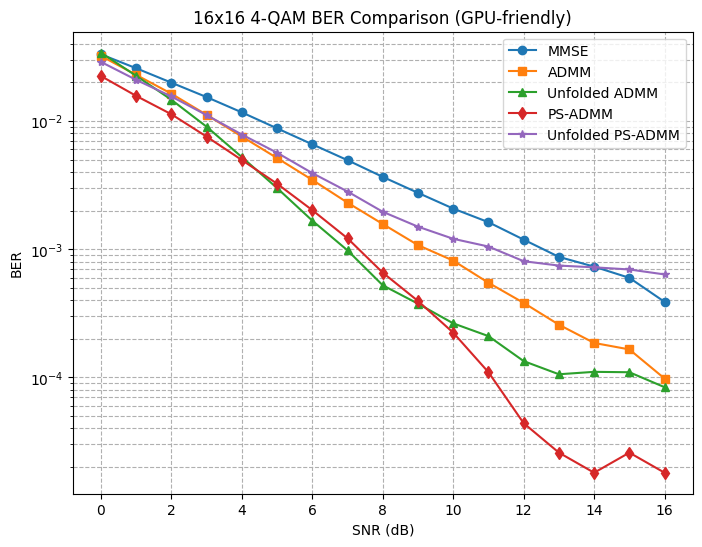

In [52]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helpers
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]
    return quant, idx

def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# complex-safe MSE
def complex_mse(x_hat, x_true):
    return torch.mean((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2)

# -------------------------
# Classical detectors (batched, torch)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)
    HhH = torch.bmm(Hh, H)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)
    HhH = torch.bmm(Hh, H)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    for _ in range(T):
        A = HhH + rho * I
        for q in range(Q):
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)

# -------------------------
# Unfolded models
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        # initialize log_rho small (so rho = 1 initially)
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0).expand(batch, -1, -1)

        x = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        z = torch.zeros_like(x)
        lam = torch.zeros_like(x)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        # per-layer rho and alpha
        self.rho = nn.Parameter(torch.ones(L) * 1.0)
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# -------------------------
# Training (sequential) - separate optimizers
# -------------------------
def train_unfolded_admm(U, B, M, device,
                        epochs=6,
                        batches_per_epoch=300,
                        batch_size=256,
                        train_snr_db=10,
                        lr=1e-3,
                        num_layers=5):
    """
    Train only UnfoldedADMM (MMSE supervision).
    returns trained model.
    """
    print("Training Unfolded ADMM...")
    bits_per_symbol = int(np.log2(M))
    constellation_np, _ = build_constellation(M)

    snr_lin = 10 ** (train_snr_db / 10)
    noise_var = 1.0 / snr_lin

    model = UnfoldedADMM(num_layers=num_layers, M=U).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        running = 0.0
        for _ in range(batches_per_epoch):
            bits = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            idx_true = (bits * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            H_np = generate_channel_np(batch_size, B, U)
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            y_np = np.zeros((batch_size, B), dtype=np.complex128)
            for bb in range(batch_size):
                y_np[bb] = H_np[bb] @ x_np[bb] + noise_np[bb]

            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)

            # teacher target
            x_mmse = mmse_detector_batch_torch(y, H, noise_var)

            # forward
            x_hat = model(y, H)

            loss = complex_mse(x_hat, x_mmse)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running += loss.item()
        print(f"ADMM Epoch {ep}/{epochs} | Loss {running / batches_per_epoch:.4e}")
    print("Finished training Unfolded ADMM.\n")
    model.eval()
    return model

def train_unfolded_psadmm(U, B, M, device,
                          epochs=6,
                          batches_per_epoch=300,
                          batch_size=256,
                          train_snr_db=10,
                          lr=1e-3,
                          Q=None,
                          L=6):
    """
    Train only UnfoldedPSADMM (MMSE supervision).
    returns trained model.
    """
    print("Training Unfolded PS-ADMM...")
    bits_per_symbol = int(np.log2(M))
    constellation_np, _ = build_constellation(M)

    snr_lin = 10 ** (train_snr_db / 10)
    noise_var = 1.0 / snr_lin

    if Q is None:
        m_side = int(np.sqrt(M))
        Q = m_side // 2

    model = UnfoldedPSADMM(U=U, Q=Q, L=L).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        running = 0.0
        for _ in range(batches_per_epoch):
            bits = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            idx_true = (bits * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            H_np = generate_channel_np(batch_size, B, U)
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            y_np = np.zeros((batch_size, B), dtype=np.complex128)
            for bb in range(batch_size):
                y_np[bb] = H_np[bb] @ x_np[bb] + noise_np[bb]

            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)

            # teacher target
            x_mmse = mmse_detector_batch_torch(y, H, noise_var)

            # forward (note PSADMM expects H,y order)
            x_hat = model(H, y)

            loss = complex_mse(x_hat, x_mmse)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running += loss.item()
        print(f"PS-ADMM Epoch {ep}/{epochs} | Loss {running / batches_per_epoch:.4e}")
    print("Finished training Unfolded PS-ADMM.\n")
    model.eval()
    return model

# -------------------------
# Unified simulation (train then BER)
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,
                       batch_size=2000,
                       micro_batch=128,
                       snr_db_list=np.arange(0, 17, 1),
                       device=None,
                       # training params
                       train_epochs_admm=6,
                       train_epochs_ps=6):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # ---- Train sequentially ----
    unfolded_admm = train_unfolded_admm(
        U=U, B=B, M=M, device=device,
        epochs=train_epochs_admm,
        batches_per_epoch=300,
        batch_size=256,
        train_snr_db=10,
        lr=1e-3,
        num_layers=5
    )

    # train ps-admm
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    unfolded_psadmm = train_unfolded_psadmm(
        U=U, B=B, M=M, device=device,
        epochs=train_epochs_ps,
        batches_per_epoch=300,
        batch_size=256,
        train_snr_db=10,
        lr=1e-3,
        Q=Q,
        L=6
    )

    # freeze models
    unfolded_admm.eval()
    unfolded_psadmm.eval()

    # ---- prepare simulation elements ----
    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)  # (C,)

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            H_batch_np = generate_channel_np(batch_size, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)
            x_batch_np = constellation_np[idx_true]
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))

            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)

                # MMSE
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)

                # Classical ADMM
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)

                # Classical PS-ADMM
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # Unfolded models (trained)
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)

                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # move to CPU
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                bl = bit_labels
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # free memory
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

# -------------------------
# Plotting
# -------------------------
def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (GPU-friendly)")
    plt.show()

# -------------------------
# Example entrypoint
# -------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # tune these for quick debug or full runs
    snr_db_list = np.arange(0, 17, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=40_000,       # lower for quick tests; raise for final
        batch_size=2000,
        micro_batch=128,
        snr_db_list=snr_db_list,
        device=device,
        train_epochs_admm=4,   # quick training for debug; increase (8-15) for final
        train_epochs_ps=4
    )
    plot_unified(snr_db_list, ber)


Train U-PSADMM ep 3: 100%|█████████████████████████████████████████████| 300/300 [00:04<00:00, 62.96it/s, loss=0.00736]


SNR=0 dB | MMSE=3.33e-02, ADMM=3.23e-02, Unfolded ADMM=1.87e-02, PS-ADMM=2.25e-02, Unfolded PS-ADMM=1.36e-02
SNR=1 dB | MMSE=2.60e-02, ADMM=2.32e-02, Unfolded ADMM=1.19e-02, PS-ADMM=1.61e-02, Unfolded PS-ADMM=8.06e-03
SNR=2 dB | MMSE=2.00e-02, ADMM=1.62e-02, Unfolded ADMM=7.36e-03, PS-ADMM=1.12e-02, Unfolded PS-ADMM=4.58e-03
SNR=3 dB | MMSE=1.54e-02, ADMM=1.13e-02, Unfolded ADMM=4.49e-03, PS-ADMM=7.65e-03, Unfolded PS-ADMM=2.58e-03
SNR=4 dB | MMSE=1.16e-02, ADMM=7.57e-03, Unfolded ADMM=2.68e-03, PS-ADMM=5.01e-03, Unfolded PS-ADMM=1.41e-03
SNR=5 dB | MMSE=8.89e-03, ADMM=5.22e-03, Unfolded ADMM=1.68e-03, PS-ADMM=3.26e-03, Unfolded PS-ADMM=7.97e-04
SNR=6 dB | MMSE=6.60e-03, ADMM=3.49e-03, Unfolded ADMM=1.07e-03, PS-ADMM=2.02e-03, Unfolded PS-ADMM=4.68e-04
SNR=7 dB | MMSE=4.98e-03, ADMM=2.37e-03, Unfolded ADMM=7.28e-04, PS-ADMM=1.21e-03, Unfolded PS-ADMM=3.05e-04
SNR=8 dB | MMSE=3.76e-03, ADMM=1.61e-03, Unfolded ADMM=5.21e-04, PS-ADMM=7.06e-04, Unfolded PS-ADMM=2.10e-04
SNR=9 dB | MMSE=2.7

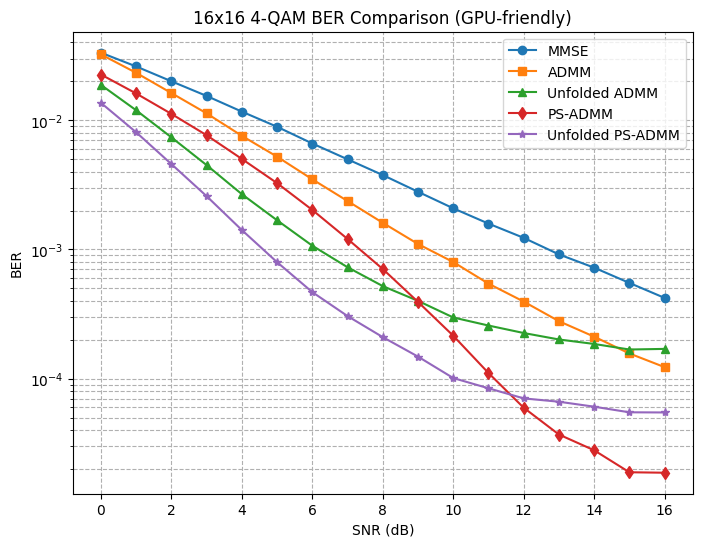

In [54]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helper (constellation etc)
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

# Torch version of quantization: computes nearest constellation point (batched)
def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    # compute squared distance using broadcasting
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]  # fancy indexing -> (B, U)
    return quant, idx

# numpy channel generator (small memory)
def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# -------------------------
# GPU-friendly detectors (batched)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    # y: (batch, B) complex, H: (batch, B, U)
    # solve (H^H H + noise_var I) x = H^H y  in batch via torch.linalg.solve
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    # solve A x = rhs
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    # Batched simple ADMM similar to your numpy single-sample version
    # y: (batch, B), H: (batch, B, U)
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # Precompute factor for solve: (HhH + rho I) . We'll solve with torch.linalg.solve each iter
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        # solve A x = Hy + rho*(z - lam)
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # Batched PS-ADMM (vectorized). Q derived from M (like original).
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    for _ in range(T):
        A = HhH + rho * I
        A_inv = None  # we use torch.linalg.solve when needed (avoid computing explicit inverse)
        # update xq for all q
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        # solve (HhH + rho I) x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)  # return combined estimate (batch, U)

# -------------------------
# Unfolded models (kept same but ensure device)
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0
def train_unfolded_admm(model, epochs=3, batches_per_epoch=300,
                        batch_size=512, B=16, U=16, M=4, snr_db=10,
                        device="cuda"):

    constellation_np, bit_labels = build_constellation(M)
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    def complex_mse(x_hat, x_true):
        return ((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2).mean()
    for ep in range(epochs):
        pbar = tqdm(range(batches_per_epoch), desc=f"Train U-ADMM ep {ep+1}")
        for _ in pbar:

            # ----- Sample batch -----
            H_np = generate_channel_np(batch_size, B, U)
            bits = np.random.randint(0, 2, (batch_size, U, int(np.log2(M))))
            idx_true = (bits * (2**np.arange(int(np.log2(M))-1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            snr_lin = 10**(snr_db/10)
            noise_var = 1/snr_lin
            noise_np = np.sqrt(noise_var/2)*(np.random.randn(batch_size, B)+1j*np.random.randn(batch_size, B))

            y_np = np.array([H_np[i] @ x_np[i] + noise_np[i] for i in range(batch_size)])

            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)
            x_true = torch.tensor(x_np, dtype=torch.cfloat, device=device)

            # ----- Forward -----
            x_hat = model(y, H)

            # ----- Loss -----
            loss = complex_mse(x_hat, x_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": float(loss)})

    return model



def train_unfolded_psadmm(model, epochs=3, batches_per_epoch=300,
                          batch_size=512, B=16, U=16, M=4, snr_db=10,
                          device="cuda"):

    constellation_np, bit_labels = build_constellation(M)
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    def complex_mse(x_hat, x_true):
        return ((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2).mean()

    for ep in range(epochs):
        pbar = tqdm(range(batches_per_epoch), desc=f"Train U-PSADMM ep {ep+1}")
        for _ in pbar:

            H_np = generate_channel_np(batch_size, B, U)
            bits = np.random.randint(0, 2, (batch_size, U, int(np.log2(M))))
            idx_true = (bits * (2**np.arange(int(np.log2(M))-1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            snr_lin = 10**(snr_db/10)
            noise_var = 1/snr_lin
            noise_np = np.sqrt(noise_var/2)*(np.random.randn(batch_size, B)+1j*np.random.randn(batch_size, B))

            y_np = np.array([H_np[i] @ x_np[i] + noise_np[i] for i in range(batch_size)])

            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)
            x_true = torch.tensor(x_np, dtype=torch.cfloat, device=device)

            x_hat = model(H, y)
            loss = complex_mse(x_hat, x_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": float(loss)})

    return model

# -------------------------
# Unified simulation (GPU-friendly)
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,        # reduce for safe runs; original was 200k
                       batch_size=2000,      # outer batch size (keeps random-generation semantics)
                       micro_batch=128,      # process micro-batches on GPU to avoid OOM
                       snr_db_list=np.arange(0, 17, 1),
                       device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)  # (C,)

    Q = int(np.sqrt(M)) // 2
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device).eval()
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=6).to(device).eval()

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate large batch in numpy (lower memory)
            H_batch_np = generate_channel_np(batch_size, B, U)               # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            # Map bits -> symbol indices (vectorized)
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)  # (batch, U)
            x_batch_np = constellation_np[idx_true]                         # (batch, U) complex
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            # compute y_batch = H @ x + noise  (numpy loop over batch is reasonably fast)
            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            # now process this big batch in micro-batches on GPU
            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                # convert micro-batch to torch
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B, U)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)  # (mb, B)
                # ---- Classical batched detectors ----
                # MMSE
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)  # (mb, U)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)
                # ADMM (batched)
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)
                # PS-ADMM (classical batched)
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # ---- Unfolded networks ----
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)    # (mb, U)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)   # (mb, U)
                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # move indices to CPU numpy for BER counting (small arrays)
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                # count bit errors: compare bit_labels
                # bit_labels is (C, bits_per_symbol)
                bl = bit_labels  # numpy
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # free intermediate GPU memory aggressively
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (GPU-friendly)")
    plt.show()

# Example run (tune these):
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
     # --------- CREATE MODELS ----------
    Q = int(np.sqrt(4)) // 2   # for 4-QAM
    unfolded_admm = UnfoldedADMM(num_layers=5, M=16).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=16, Q=Q, L=6).to(device)

    # --------- TRAIN MODELS ----------
    unfolded_admm = train_unfolded_admm(unfolded_admm, device=device)
    unfolded_psadmm = train_unfolded_psadmm(unfolded_psadmm, device=device)

    # Reduce trials for first test; increase once stable.
    snr_db_list = np.arange(0, 17, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=200_000,       # lower than 200k for safe debugging
        batch_size=2000,
        micro_batch=128,     # lower micro-batch if OOM (e.g., 64)
        snr_db_list=snr_db_list,
        device=device
    )
    plot_unified(snr_db_list, ber)

Using device: cuda
Initial parameters (before training):
Unfolded ADMM rho: tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<ExpBackward0>)
Unfolded PS-ADMM rho: Parameter containing:
tensor([1., 1., 1., 1., 1., 1.], device='cuda:0', requires_grad=True)
Unfolded PS-ADMM alpha: Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100], device='cuda:0',
       requires_grad=True)

TRAINING UNFOLDED ADMM


Train U-ADMM ep 1/8: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 77.62it/s, loss=0.0222, SNR=13.1 dB]


Epoch 1 average loss: 0.033769


Train U-ADMM ep 2/8: 100%|██████████████████████████████████| 400/400 [00:04<00:00, 80.61it/s, loss=0.0489, SNR=6.3 dB]


Epoch 2 average loss: 0.032116


Train U-ADMM ep 3/8: 100%|██████████████████████████████████| 400/400 [00:04<00:00, 81.13it/s, loss=0.0372, SNR=7.8 dB]


Epoch 3 average loss: 0.031100


Train U-ADMM ep 4/8: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 77.58it/s, loss=0.0197, SNR=12.8 dB]


Epoch 4 average loss: 0.030284


Train U-ADMM ep 5/8: 100%|██████████████████████████████████| 400/400 [00:05<00:00, 78.08it/s, loss=0.0451, SNR=6.1 dB]


Epoch 5 average loss: 0.029739


Train U-ADMM ep 6/8: 100%|██████████████████████████████████| 400/400 [00:05<00:00, 79.61it/s, loss=0.0326, SNR=8.4 dB]


Epoch 6 average loss: 0.030011


Train U-ADMM ep 7/8: 100%|██████████████████████████████████| 400/400 [00:04<00:00, 81.05it/s, loss=0.0444, SNR=6.4 dB]


Epoch 7 average loss: 0.028313


Train U-ADMM ep 8/8: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 79.89it/s, loss=0.0250, SNR=10.5 dB]


Epoch 8 average loss: 0.031067

TRAINING UNFOLDED PS-ADMM


Train U-PSADMM ep 1/8: 100%|████████████████████████████████| 400/400 [00:06<00:00, 58.58it/s, loss=0.0116, SNR=9.1 dB]


Epoch 1 average loss: 0.014427


Train U-PSADMM ep 2/8: 100%|████████████████████████████████| 400/400 [00:07<00:00, 54.85it/s, loss=0.0104, SNR=8.6 dB]


Epoch 2 average loss: 0.010293


Train U-PSADMM ep 3/8: 100%|████████████████████████████████| 400/400 [00:07<00:00, 55.84it/s, loss=0.0087, SNR=8.9 dB]


Epoch 3 average loss: 0.008681


Train U-PSADMM ep 4/8: 100%|████████████████████████████████| 400/400 [00:07<00:00, 54.15it/s, loss=0.0083, SNR=9.1 dB]


Epoch 4 average loss: 0.008634


Train U-PSADMM ep 5/8: 100%|████████████████████████████████| 400/400 [00:07<00:00, 56.24it/s, loss=0.0143, SNR=6.6 dB]


Epoch 5 average loss: 0.008410


Train U-PSADMM ep 6/8: 100%|████████████████████████████████| 400/400 [00:07<00:00, 56.29it/s, loss=0.0144, SNR=6.3 dB]


Epoch 6 average loss: 0.008266


Train U-PSADMM ep 7/8: 100%|███████████████████████████████| 400/400 [00:07<00:00, 56.74it/s, loss=0.0031, SNR=13.9 dB]


Epoch 7 average loss: 0.007929


Train U-PSADMM ep 8/8: 100%|████████████████████████████████| 400/400 [00:07<00:00, 55.10it/s, loss=0.0070, SNR=9.4 dB]


Epoch 8 average loss: 0.008223

Trained parameters:
Unfolded ADMM rho: tensor([0.1992, 0.2102, 0.2658, 0.5107, 1.1102], device='cuda:0',
       grad_fn=<ExpBackward0>)
Unfolded PS-ADMM rho: Parameter containing:
tensor([1.9072, 0.5485, 0.5517, 0.5857, 1.5803, 1.9072], device='cuda:0',
       requires_grad=True)
Unfolded PS-ADMM alpha: Parameter containing:
tensor([0.0100, 0.2851, 0.3762, 0.5490, 0.1759, 0.3432], device='cuda:0',
       requires_grad=True)

RUNNING BER SIMULATION WITH TRAINED MODELS
Using pre-trained Unfolded ADMM
Using pre-trained Unfolded PS-ADMM
SNR=0 dB | MMSE=3.31e-02, ADMM=3.20e-02, Unfolded ADMM=1.77e-02, PS-ADMM=2.24e-02, Unfolded PS-ADMM=6.33e-03
SNR=1 dB | MMSE=2.60e-02, ADMM=2.32e-02, Unfolded ADMM=1.13e-02, PS-ADMM=1.62e-02, Unfolded PS-ADMM=2.96e-03
SNR=2 dB | MMSE=2.01e-02, ADMM=1.63e-02, Unfolded ADMM=6.99e-03, PS-ADMM=1.12e-02, Unfolded PS-ADMM=1.35e-03
SNR=3 dB | MMSE=1.55e-02, ADMM=1.12e-02, Unfolded ADMM=4.17e-03, PS-ADMM=7.68e-03, Unfolded PS-ADMM=5.

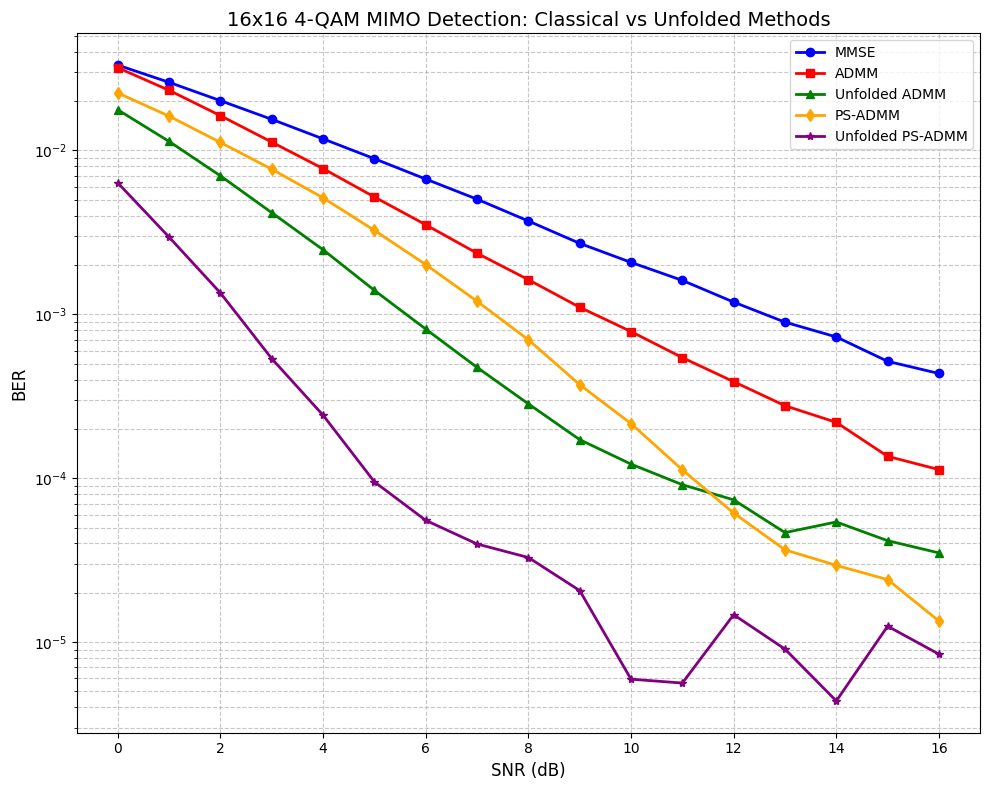

In [72]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helper (constellation etc)
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

# Torch version of quantization: computes nearest constellation point (batched)
def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    # compute squared distance using broadcasting
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]  # fancy indexing -> (B, U)
    return quant, idx

# numpy channel generator (small memory)
def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# -------------------------
# GPU-friendly detectors (batched)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    # y: (batch, B) complex, H: (batch, B, U)
    # solve (H^H H + noise_var I) x = H^H y  in batch via torch.linalg.solve
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    # solve A x = rhs
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    # Batched simple ADMM similar to your numpy single-sample version
    # y: (batch, B), H: (batch, B, U)
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # Precompute factor for solve: (HhH + rho I) . We'll solve with torch.linalg.solve each iter
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        # solve A x = Hy + rho*(z - lam)
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # Batched PS-ADMM (vectorized). Q derived from M (like original).
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    for _ in range(T):
        A = HhH + rho * I
        A_inv = None  # we use torch.linalg.solve when needed (avoid computing explicit inverse)
        # update xq for all q
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho * sum_scaled - dual_y
        # solve (HhH + rho I) x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho * (x0 - sum_scaled)
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)  # return combined estimate (batch, U)

# -------------------------
# Unfolded models (kept same but ensure device)
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# -------------------------
# Improved Training Functions
# -------------------------
def train_unfolded_admm(model, epochs=10, batches_per_epoch=500,
                        batch_size=512, B=16, U=16, M=4, 
                        snr_range=(5, 15), device="cuda"):
    """Train with variable SNR for better generalization"""
    
    constellation_np, bit_labels = build_constellation(M)
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    
    def complex_mse(x_hat, x_true):
        return ((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2).mean()
    
    model.train()
    for ep in range(epochs):
        pbar = tqdm(range(batches_per_epoch), desc=f"Train U-ADMM ep {ep+1}/{epochs}")
        epoch_loss = 0
        
        for _ in pbar:
            # Sample random SNR for better generalization
            snr_db = np.random.uniform(snr_range[0], snr_range[1])
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1.0 / snr_lin

            # Generate batch
            H_np = generate_channel_np(batch_size, B, U)
            bits = np.random.randint(0, 2, (batch_size, U, int(np.log2(M))))
            idx_true = (bits * (2 ** np.arange(int(np.log2(M)) - 1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            noise_np = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
            y_np = np.array([H_np[i] @ x_np[i] + noise_np[i] for i in range(batch_size)])

            # Convert to torch
            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)
            x_true_torch = torch.tensor(x_np, dtype=torch.cfloat, device=device)

            # Forward pass
            x_hat = model(y, H)
            loss = complex_mse(x_hat, x_true_torch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "SNR": f"{snr_db:.1f} dB"})
        
        scheduler.step()
        print(f"Epoch {ep+1} average loss: {epoch_loss/batches_per_epoch:.6f}")
    
    model.eval()
    return model

def train_unfolded_psadmm(model, epochs=10, batches_per_epoch=500,
                          batch_size=512, B=16, U=16, M=4,
                          snr_range=(5, 15), device="cuda"):
    """Train with variable SNR for better generalization"""
    
    constellation_np, bit_labels = build_constellation(M)
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    
    def complex_mse(x_hat, x_true):
        return ((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2).mean()
    
    model.train()
    for ep in range(epochs):
        pbar = tqdm(range(batches_per_epoch), desc=f"Train U-PSADMM ep {ep+1}/{epochs}")
        epoch_loss = 0
        
        for _ in pbar:
            # Sample random SNR for better generalization
            snr_db = np.random.uniform(snr_range[0], snr_range[1])
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1.0 / snr_lin

            # Generate batch
            H_np = generate_channel_np(batch_size, B, U)
            bits = np.random.randint(0, 2, (batch_size, U, int(np.log2(M))))
            idx_true = (bits * (2 ** np.arange(int(np.log2(M)) - 1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            noise_np = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
            y_np = np.array([H_np[i] @ x_np[i] + noise_np[i] for i in range(batch_size)])

            # Convert to torch
            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)
            x_true_torch = torch.tensor(x_np, dtype=torch.cfloat, device=device)

            # Forward pass
            x_hat = model(H, y)
            loss = complex_mse(x_hat, x_true_torch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "SNR": f"{snr_db:.1f} dB"})
        
        scheduler.step()
        print(f"Epoch {ep+1} average loss: {epoch_loss/batches_per_epoch:.6f}")
    
    model.eval()
    return model

# -------------------------
# Unified simulation (GPU-friendly) - MODIFIED to accept pre-trained models
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,
                       batch_size=2000,
                       micro_batch=128,
                       snr_db_list=np.arange(0, 17, 1),
                       device=None,
                       unfolded_admm=None,    # Accept pre-trained models
                       unfolded_psadmm=None):
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)

    Q = int(np.sqrt(M)) // 2
    
    # Only create new models if not provided
    if unfolded_admm is None:
        unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device).eval()
        print("Using untrained Unfolded ADMM")
    else:
        print("Using pre-trained Unfolded ADMM")
        
    if unfolded_psadmm is None:
        unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=6).to(device).eval()
        print("Using untrained Unfolded PS-ADMM")
    else:
        print("Using pre-trained Unfolded PS-ADMM")

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate large batch in numpy (lower memory)
            H_batch_np = generate_channel_np(batch_size, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)
            x_batch_np = constellation_np[idx_true]
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            
            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            # Process in micro-batches
            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)

                # Classical detectors
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)
                
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)
                
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # Unfolded networks
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)
                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # Count errors
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                bl = bit_labels
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # Cleanup
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(10, 8))
    markers = ['o', 's', '^', 'd', '*', 'v']
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber and len(ber[k]) > 0:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], color=colors[i], 
                        label=k, linewidth=2, markersize=6)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("BER", fontsize=12)
    plt.legend(fontsize=10)
    plt.title("16x16 4-QAM MIMO Detection: Classical vs Unfolded Methods", fontsize=14)
    plt.tight_layout()
    plt.show()

# -------------------------
# Main execution
# -------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Create models
    Q = int(np.sqrt(4)) // 2   # for 4-QAM
    unfolded_admm = UnfoldedADMM(num_layers=5, M=16).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=16, Q=Q, L=6).to(device)
    
    print("Initial parameters (before training):")
    print("Unfolded ADMM rho:", torch.exp(unfolded_admm.log_rho))
    print("Unfolded PS-ADMM rho:", unfolded_psadmm.rho)
    print("Unfolded PS-ADMM alpha:", unfolded_psadmm.alpha)
    
    # Train models
    print("\n" + "="*50)
    print("TRAINING UNFOLDED ADMM")
    print("="*50)
    unfolded_admm = train_unfolded_admm(unfolded_admm, epochs=8, batches_per_epoch=400, device=device)
    
    print("\n" + "="*50)
    print("TRAINING UNFOLDED PS-ADMM")
    print("="*50)
    unfolded_psadmm = train_unfolded_psadmm(unfolded_psadmm, epochs=8, batches_per_epoch=400, device=device)
    
    print("\nTrained parameters:")
    print("Unfolded ADMM rho:", torch.exp(unfolded_admm.log_rho))
    print("Unfolded PS-ADMM rho:", unfolded_psadmm.rho)
    print("Unfolded PS-ADMM alpha:", unfolded_psadmm.alpha)
    
    # Run simulation with trained models
    print("\n" + "="*50)
    print("RUNNING BER SIMULATION WITH TRAINED MODELS")
    print("="*50)
    
    snr_db_list = np.arange(0, 17, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=100_000,       # Reduced for faster testing
        batch_size=2000,
        micro_batch=128,
        snr_db_list=snr_db_list,
        device=device,
        unfolded_admm=unfolded_admm,      # Pass trained models
        unfolded_psadmm=unfolded_psadmm
    )
    
    plot_unified(snr_db_list, ber)

Using device: cuda
Initial parameters (before training):
Unfolded ADMM rho: ['1.000', '1.000', '1.000', '1.000', '1.000']
Unfolded PS-ADMM rho: ['0.500', '0.500', '0.500', '0.500', '0.500', '0.500']
Unfolded PS-ADMM alpha: ['0.100', '0.100', '0.100', '0.100', '0.100', '0.100']

TRAINING UNFOLDED ADMM


Train U-ADMM ep 1/10: 100%|████████████████████████████████| 400/400 [00:05<00:00, 78.89it/s, loss=0.0222, SNR=13.1 dB]


Epoch 1 average loss: 0.033772
  Rho values: ['0.694', '0.696', '0.706', '0.745', '0.863']


Train U-ADMM ep 2/10: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 78.14it/s, loss=0.0489, SNR=6.3 dB]


Epoch 2 average loss: 0.032150
  Rho values: ['0.509', '0.515', '0.535', '0.618', '0.853']


Train U-ADMM ep 3/10: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 78.74it/s, loss=0.0374, SNR=7.8 dB]


Epoch 3 average loss: 0.031201
  Rho values: ['0.393', '0.401', '0.431', '0.559', '0.902']


Train U-ADMM ep 4/10: 100%|████████████████████████████████| 400/400 [00:05<00:00, 77.68it/s, loss=0.0197, SNR=12.8 dB]


Epoch 4 average loss: 0.030341
  Rho values: ['0.316', '0.326', '0.364', '0.529', '0.958']


Train U-ADMM ep 5/10: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 79.22it/s, loss=0.0450, SNR=6.1 dB]


Epoch 5 average loss: 0.029703
  Rho values: ['0.266', '0.276', '0.320', '0.512', '1.004']


Train U-ADMM ep 6/10: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 78.51it/s, loss=0.0326, SNR=8.4 dB]


Epoch 6 average loss: 0.029985
  Rho values: ['0.234', '0.245', '0.294', '0.509', '1.048']


Train U-ADMM ep 7/10: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 79.04it/s, loss=0.0444, SNR=6.4 dB]


Epoch 7 average loss: 0.028306
  Rho values: ['0.215', '0.225', '0.277', '0.503', '1.066']


Train U-ADMM ep 8/10: 100%|████████████████████████████████| 400/400 [00:05<00:00, 79.57it/s, loss=0.0250, SNR=10.5 dB]


Epoch 8 average loss: 0.031086
  Rho values: ['0.205', '0.216', '0.270', '0.508', '1.092']


Train U-ADMM ep 9/10: 100%|█████████████████████████████████| 400/400 [00:05<00:00, 79.33it/s, loss=0.0316, SNR=9.1 dB]


Epoch 9 average loss: 0.029363
  Rho values: ['0.201', '0.212', '0.267', '0.507', '1.097']


Train U-ADMM ep 10/10: 100%|████████████████████████████████| 400/400 [00:04<00:00, 80.81it/s, loss=0.0335, SNR=8.6 dB]


Epoch 10 average loss: 0.029918
  Rho values: ['0.200', '0.212', '0.266', '0.507', '1.098']

TRAINING UNFOLDED PS-ADMM


Train U-PSADMM ep 1/10: 100%|███████████████████████████████| 400/400 [00:07<00:00, 50.19it/s, loss=0.0126, SNR=8.9 dB]


Epoch 1 average loss: 0.013842
  Rho values: ['0.730', '0.166', '0.218', '0.857', '0.850', '0.589']
  Alpha values: ['-0.000', '0.008', '0.006', '0.002', '-0.006', '0.224']


Train U-PSADMM ep 2/10: 100%|███████████████████████████████| 400/400 [00:08<00:00, 49.95it/s, loss=0.0115, SNR=9.1 dB]


Epoch 2 average loss: 0.012170
  Rho values: ['0.884', '0.231', '0.098', '1.045', '1.048', '0.694']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.270']


Train U-PSADMM ep 3/10: 100%|███████████████████████████████| 400/400 [00:07<00:00, 50.44it/s, loss=0.0193, SNR=6.6 dB]


Epoch 3 average loss: 0.011456
  Rho values: ['1.000', '0.314', '0.097', '1.206', '1.215', '0.799']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.303']


Train U-PSADMM ep 4/10: 100%|███████████████████████████████| 400/400 [00:08<00:00, 50.00it/s, loss=0.0189, SNR=6.3 dB]


Epoch 4 average loss: 0.011099
  Rho values: ['1.090', '0.381', '0.097', '1.343', '1.358', '0.882']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.338']


Train U-PSADMM ep 5/10: 100%|██████████████████████████████| 400/400 [00:08<00:00, 49.13it/s, loss=0.0043, SNR=13.9 dB]


Epoch 5 average loss: 0.010526
  Rho values: ['1.154', '0.439', '0.097', '1.449', '1.467', '0.952']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.363']


Train U-PSADMM ep 6/10: 100%|███████████████████████████████| 400/400 [00:08<00:00, 49.19it/s, loss=0.0092, SNR=9.4 dB]


Epoch 6 average loss: 0.010835
  Rho values: ['1.205', '0.473', '0.096', '1.535', '1.556', '0.999']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.389']


Train U-PSADMM ep 7/10: 100%|██████████████████████████████| 400/400 [00:08<00:00, 49.47it/s, loss=0.0051, SNR=12.5 dB]


Epoch 7 average loss: 0.010696
  Rho values: ['1.237', '0.504', '0.096', '1.593', '1.615', '1.035']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.402']


Train U-PSADMM ep 8/10: 100%|███████████████████████████████| 400/400 [00:07<00:00, 50.06it/s, loss=0.0200, SNR=5.9 dB]


Epoch 8 average loss: 0.009394
  Rho values: ['1.250', '0.525', '0.096', '1.619', '1.642', '1.058']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.406']


Train U-PSADMM ep 9/10: 100%|██████████████████████████████| 400/400 [00:07<00:00, 50.95it/s, loss=0.0042, SNR=13.9 dB]


Epoch 9 average loss: 0.009928
  Rho values: ['1.256', '0.532', '0.096', '1.630', '1.654', '1.064']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.410']


Train U-PSADMM ep 10/10: 100%|█████████████████████████████| 400/400 [00:07<00:00, 50.51it/s, loss=0.0061, SNR=11.4 dB]


Epoch 10 average loss: 0.009293
  Rho values: ['1.257', '0.533', '0.096', '1.632', '1.656', '1.065']
  Alpha values: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.410']

Trained parameters:
Unfolded ADMM rho: ['0.200', '0.212', '0.266', '0.507', '1.098']
Unfolded PS-ADMM rho: ['1.257', '0.533', '0.096', '1.632', '1.656', '1.065']
Unfolded PS-ADMM alpha: ['0.000', '0.008', '0.006', '0.002', '-0.006', '0.410']

RUNNING BER SIMULATION WITH TRAINED MODELS
Using pre-trained Unfolded ADMM
Using pre-trained Unfolded PS-ADMM
SNR=0 dB | MMSE=3.33e-02, ADMM=3.24e-02, Unfolded ADMM=1.79e-02, PS-ADMM=2.26e-02, Unfolded PS-ADMM=9.65e-03
SNR=1 dB | MMSE=2.61e-02, ADMM=2.33e-02, Unfolded ADMM=1.15e-02, PS-ADMM=1.62e-02, Unfolded PS-ADMM=5.05e-03
SNR=2 dB | MMSE=2.01e-02, ADMM=1.63e-02, Unfolded ADMM=7.00e-03, PS-ADMM=1.12e-02, Unfolded PS-ADMM=2.49e-03
SNR=3 dB | MMSE=1.53e-02, ADMM=1.12e-02, Unfolded ADMM=4.17e-03, PS-ADMM=7.63e-03, Unfolded PS-ADMM=1.17e-03
SNR=4 dB | MMSE=1.16e-02, ADMM=7.61e-

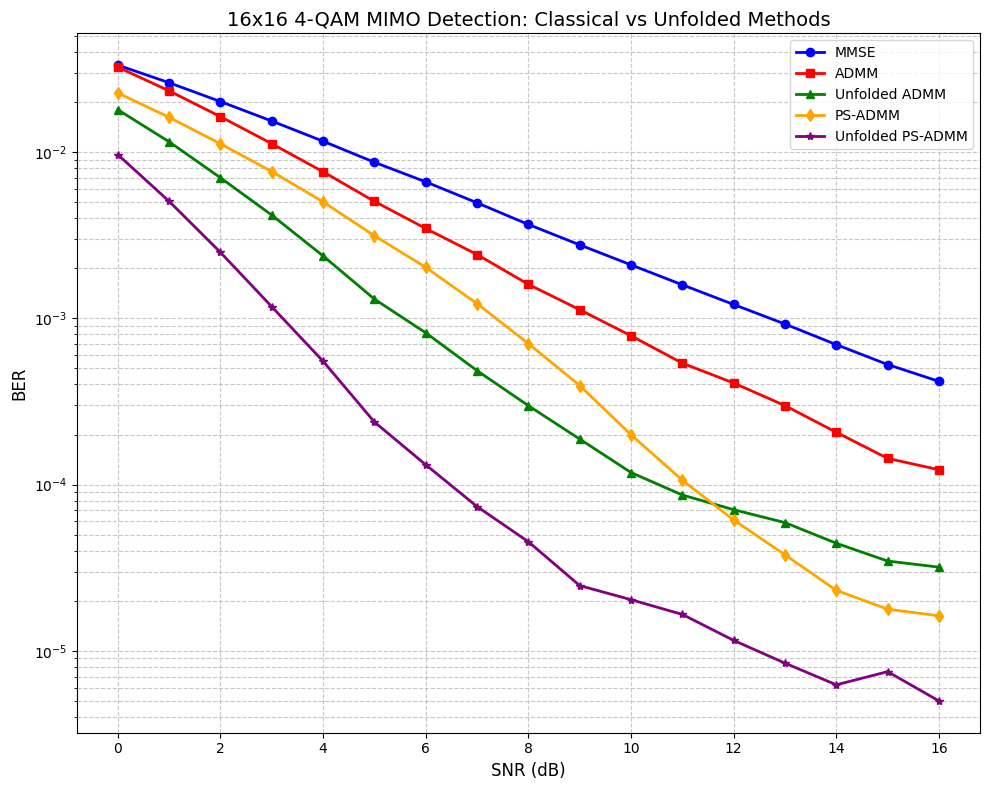

In [75]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# -------------------------
# Helper (constellation etc)
# -------------------------
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

# Torch version of quantization: computes nearest constellation point (batched)
def quantize_to_constellation_torch(x, constellation_torch):
    # x: (batch, U) complex tensor
    B, U = x.shape
    C = constellation_torch.shape[0]
    # compute squared distance using broadcasting
    x_flat = x.view(B*U, 1)
    const_flat = constellation_torch.view(1, C)
    d2 = torch.abs(x_flat - const_flat)**2  # (B*U, C)
    idx = torch.argmin(d2, dim=1).view(B, U)
    quant = constellation_torch[idx]  # fancy indexing -> (B, U)
    return quant, idx

# numpy channel generator (small memory)
def generate_channel_np(batch, B, U):
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

# -------------------------
# GPU-friendly detectors (batched)
# -------------------------
def mmse_detector_batch_torch(y, H, noise_var):
    # y: (batch, B) complex, H: (batch, B, U)
    # solve (H^H H + noise_var I) x = H^H y  in batch via torch.linalg.solve
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    rhs = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)  # (batch, U)
    batch, U, _ = HhH.shape
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    A = HhH + noise_var * I
    # solve A x = rhs
    x = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
    return x

def admm_detector_batch_torch(y, H, rho=0.1, max_iter=20, tol=1e-4):
    # Batched simple ADMM similar to your numpy single-sample version
    # y: (batch, B), H: (batch, B, U)
    batch, B, U = H.shape
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=H.dtype, device=H.device).unsqueeze(0).expand(batch, -1, -1)
    # Precompute factor for solve: (HhH + rho I) . We'll solve with torch.linalg.solve each iter
    A = HhH + rho * I
    x = torch.zeros(batch, U, dtype=H.dtype, device=H.device)
    z = torch.zeros_like(x)
    lam = torch.zeros_like(x)
    for _ in range(max_iter):
        # solve A x = Hy + rho*(z - lam)
        rhs = (Hy + rho * (z - lam)).unsqueeze(-1)
        x_new = torch.linalg.solve(A, rhs).squeeze(-1)
        z_new = torch.clamp(x_new.real + lam.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag + lam.imag, -1.0, 1.0)
        lam = lam + x_new - z_new
        if torch.max(torch.linalg.norm(x_new - z_new, dim=1)) < tol:
            x = x_new
            break
        x = x_new
        z = z_new
    return x

def ps_admm_batch_torch(H, y, M, rho=1.0, alpha=0.01, T=20):
    # Batched PS-ADMM (vectorized). Q derived from M (like original).
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    batch, B, U = H.shape
    device = H.device
    scales = torch.tensor([2 ** q for q in range(Q)], dtype=torch.cfloat, device=device)  # (Q,)
    Hh = torch.conj(H).permute(0, 2, 1)            # (batch, U, B)
    HhH = torch.bmm(Hh, H)                         # (batch, U, U)
    Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1) # (batch, U)
    I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0).expand(batch, -1, -1)

    xq = torch.zeros(batch, Q, U, dtype=torch.cfloat, device=device)
    x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
    dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

    # Convert rho and alpha to tensors for PyTorch operations
    rho_tensor = torch.tensor(rho, dtype=torch.float32, device=device)
    alpha_tensor = torch.tensor(alpha, dtype=torch.float32, device=device)

    for _ in range(T):
        A = HhH + rho_tensor * I
        # update xq for all q
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
            numer = rho_tensor * x0 - rho_tensor * sum_scaled + dual_y
            denom = (4 ** q) * rho_tensor - alpha_tensor
            
            # NUMERICAL STABILITY FIX: Ensure denominator doesn't get too small
            denom = torch.where(torch.abs(denom) < 1e-8, torch.sign(denom) * 1e-8, denom)
            
            x_new = (scales[q] / denom) * numer
            xq[:, q, :] = torch.clamp(x_new.real, -1.0, 1.0) + 1j * torch.clamp(x_new.imag, -1.0, 1.0)
        
        sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
        rhs = Hhr + rho_tensor * sum_scaled - dual_y
        # solve (HhH + rho I) x0 = rhs
        x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
        dual_y = dual_y + rho_tensor * (x0 - sum_scaled)
    
    return torch.sum(scales.view(1, -1, 1) * xq, dim=1)  # return combined estimate (batch, U)

# -------------------------
# Unfolded models with STABILIZATION
# -------------------------
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        batch, B, U = H.shape
        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            A = HhH + rho * I
            x = torch.linalg.solve(A, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        # Initialize with more reasonable values
        self.rho = nn.Parameter(torch.ones(L) * 0.5)
        self.alpha = nn.Parameter(torch.ones(L) * 0.1)
        
    def forward(self, H, y):
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).permute(0, 2, 1)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = torch.clamp(self.rho[l], min=0.1, max=2.0)  # Constrain rho
            alpha = torch.clamp(self.alpha[l], min=0.01, max=1.0)  # Constrain alpha
            
            A = HhH + rho * I
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                
                # NUMERICAL STABILITY FIX: Ensure denominator doesn't get too small
                denom = torch.where(torch.abs(denom) < 1e-6, torch.sign(denom) * 1e-6, denom)
                
                x_new = (scales[q] / denom) * numer
                # Use tanh for smoother projection
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.linalg.solve(A, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

# -------------------------
# IMPROVED Training Functions
# -------------------------
def train_unfolded_admm(model, epochs=10, batches_per_epoch=400,
                        batch_size=512, B=16, U=16, M=4, 
                        snr_range=(5, 15), device="cuda"):
    
    constellation_np, bit_labels = build_constellation(M)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs * batches_per_epoch)
    
    def complex_mse(x_hat, x_true):
        return ((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2).mean()
    
    model.train()
    for ep in range(epochs):
        pbar = tqdm(range(batches_per_epoch), desc=f"Train U-ADMM ep {ep+1}/{epochs}")
        epoch_loss = 0
        
        for _ in pbar:
            # Sample random SNR for better generalization
            snr_db = np.random.uniform(snr_range[0], snr_range[1])
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1.0 / snr_lin

            # Generate batch
            H_np = generate_channel_np(batch_size, B, U)
            bits = np.random.randint(0, 2, (batch_size, U, int(np.log2(M))))
            idx_true = (bits * (2 ** np.arange(int(np.log2(M)) - 1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            noise_np = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
            y_np = np.array([H_np[i] @ x_np[i] + noise_np[i] for i in range(batch_size)])

            # Convert to torch
            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)
            x_true_torch = torch.tensor(x_np, dtype=torch.cfloat, device=device)

            # Forward pass
            x_hat = model(y, H)
            loss = complex_mse(x_hat, x_true_torch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "SNR": f"{snr_db:.1f} dB"})
        
        print(f"Epoch {ep+1} average loss: {epoch_loss/batches_per_epoch:.6f}")
        # Print parameters to monitor learning
        with torch.no_grad():
            rho_values = torch.exp(model.log_rho).cpu().numpy()
            print(f"  Rho values: {[f'{r:.3f}' for r in rho_values]}")
    
    model.eval()
    return model

def train_unfolded_psadmm(model, epochs=10, batches_per_epoch=400,
                          batch_size=512, B=16, U=16, M=4,
                          snr_range=(5, 15), device="cuda"):
    
    constellation_np, bit_labels = build_constellation(M)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs * batches_per_epoch)
    
    def complex_mse(x_hat, x_true):
        return ((x_hat.real - x_true.real)**2 + (x_hat.imag - x_true.imag)**2).mean()
    
    model.train()
    for ep in range(epochs):
        pbar = tqdm(range(batches_per_epoch), desc=f"Train U-PSADMM ep {ep+1}/{epochs}")
        epoch_loss = 0
        
        for _ in pbar:
            # Sample random SNR for better generalization
            snr_db = np.random.uniform(snr_range[0], snr_range[1])
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1.0 / snr_lin

            # Generate batch
            H_np = generate_channel_np(batch_size, B, U)
            bits = np.random.randint(0, 2, (batch_size, U, int(np.log2(M))))
            idx_true = (bits * (2 ** np.arange(int(np.log2(M)) - 1, -1, -1))).sum(axis=2)
            x_np = constellation_np[idx_true]

            noise_np = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
            y_np = np.array([H_np[i] @ x_np[i] + noise_np[i] for i in range(batch_size)])

            # Convert to torch
            H = torch.tensor(H_np, dtype=torch.cfloat, device=device)
            y = torch.tensor(y_np, dtype=torch.cfloat, device=device)
            x_true_torch = torch.tensor(x_np, dtype=torch.cfloat, device=device)

            # Forward pass
            x_hat = model(H, y)
            loss = complex_mse(x_hat, x_true_torch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "SNR": f"{snr_db:.1f} dB"})
        
        print(f"Epoch {ep+1} average loss: {epoch_loss/batches_per_epoch:.6f}")
        # Print parameters to monitor learning
        with torch.no_grad():
            rho_values = model.rho.cpu().numpy()
            alpha_values = model.alpha.cpu().numpy()
            print(f"  Rho values: {[f'{r:.3f}' for r in rho_values]}")
            print(f"  Alpha values: {[f'{a:.3f}' for a in alpha_values]}")
    
    model.eval()
    return model

# -------------------------
# Unified simulation (accepts pre-trained models)
# -------------------------
def unified_simulation(B=16, U=16, M=4,
                       trials=100_000,
                       batch_size=2000,
                       micro_batch=128,
                       snr_db_list=np.arange(0, 17, 1),
                       device=None,
                       unfolded_admm=None,
                       unfolded_psadmm=None):
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation_np, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    constellation_torch = torch.tensor(constellation_np, dtype=torch.cfloat, device=device)

    Q = int(np.sqrt(M)) // 2
    
    # Only create new models if not provided
    if unfolded_admm is None:
        unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device).eval()
        print("Using untrained Unfolded ADMM")
    else:
        print("Using pre-trained Unfolded ADMM")
        
    if unfolded_psadmm is None:
        unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=6).to(device).eval()
        print("Using untrained Unfolded PS-ADMM")
    else:
        print("Using pre-trained Unfolded PS-ADMM")

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-12

    num_batches = max(1, trials // batch_size)

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1.0 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate large batch in numpy (lower memory)
            H_batch_np = generate_channel_np(batch_size, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            idx_true = (bits_batch * (2 ** np.arange(bits_per_symbol - 1, -1, -1))).sum(axis=2).astype(int)
            x_batch_np = constellation_np[idx_true]
            noise_np = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            
            y_batch_np = np.empty((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch_np[b] = H_batch_np[b] @ x_batch_np[b] + noise_np[b]

            # Process in micro-batches
            num_micro = int(np.ceil(batch_size / micro_batch))
            for m in range(num_micro):
                s = m * micro_batch
                e = min(batch_size, (m+1) * micro_batch)
                mb = e - s
                
                H_mb = torch.tensor(H_batch_np[s:e], dtype=torch.cfloat, device=device)
                y_mb = torch.tensor(y_batch_np[s:e], dtype=torch.cfloat, device=device)

                # Classical detectors
                x_mm = mmse_detector_batch_torch(y_mb, H_mb, noise_var)
                _, idx_mm = quantize_to_constellation_torch(x_mm, constellation_torch)
                
                x_admm = admm_detector_batch_torch(y_mb, H_mb, rho=0.1, max_iter=20)
                _, idx_a = quantize_to_constellation_torch(x_admm, constellation_torch)
                
                x_ps = ps_admm_batch_torch(H_mb, y_mb, M, rho=1.0, alpha=0.01, T=15)
                _, idx_ps = quantize_to_constellation_torch(x_ps, constellation_torch)

                # Unfolded networks
                with torch.no_grad():
                    x_unf_admm = unfolded_admm(y_mb, H_mb)
                    x_unf_ps = unfolded_psadmm(H_mb, y_mb)
                _, idx_uad = quantize_to_constellation_torch(x_unf_admm, constellation_torch)
                _, idx_ups = quantize_to_constellation_torch(x_unf_ps, constellation_torch)

                # Count errors
                idx_mm_np = idx_mm.cpu().numpy()
                idx_a_np = idx_a.cpu().numpy()
                idx_ps_np = idx_ps.cpu().numpy()
                idx_uad_np = idx_uad.cpu().numpy()
                idx_ups_np = idx_ups.cpu().numpy()
                idx_true_mb = idx_true[s:e]

                bl = bit_labels
                errors["MMSE"] += np.sum(bl[idx_mm_np] != bl[idx_true_mb])
                errors["ADMM"] += np.sum(bl[idx_a_np] != bl[idx_true_mb])
                errors["PS-ADMM"] += np.sum(bl[idx_ps_np] != bl[idx_true_mb])
                errors["Unfolded ADMM"] += np.sum(bl[idx_uad_np] != bl[idx_true_mb])
                errors["Unfolded PS-ADMM"] += np.sum(bl[idx_ups_np] != bl[idx_true_mb])

                # Cleanup
                del H_mb, y_mb, x_mm, x_admm, x_ps, x_unf_admm, x_unf_ps, idx_mm, idx_a, idx_ps, idx_uad, idx_ups
                if device.startswith("cuda"):
                    torch.cuda.empty_cache()

        for k in ber:
            ber[k].append(max(errors[k] / (total_bits + 1e-30), eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(10, 8))
    markers = ['o', 's', '^', 'd', '*', 'v']
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber and len(ber[k]) > 0:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], color=colors[i], 
                        label=k, linewidth=2, markersize=6)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("BER", fontsize=12)
    plt.legend(fontsize=10)
    plt.title("16x16 4-QAM MIMO Detection: Classical vs Unfolded Methods", fontsize=14)
    plt.tight_layout()
    plt.show()

# -------------------------
# Main execution
# -------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Create models
    Q = int(np.sqrt(4)) // 2   # for 4-QAM
    unfolded_admm = UnfoldedADMM(num_layers=5, M=16).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=16, Q=Q, L=6).to(device)
    
    print("Initial parameters (before training):")
    with torch.no_grad():
        print("Unfolded ADMM rho:", [f'{r:.3f}' for r in torch.exp(unfolded_admm.log_rho).cpu().numpy()])
        print("Unfolded PS-ADMM rho:", [f'{r:.3f}' for r in unfolded_psadmm.rho.cpu().numpy()])
        print("Unfolded PS-ADMM alpha:", [f'{a:.3f}' for a in unfolded_psadmm.alpha.cpu().numpy()])
    
    # Train models
    print("\n" + "="*50)
    print("TRAINING UNFOLDED ADMM")
    print("="*50)
    unfolded_admm = train_unfolded_admm(unfolded_admm, epochs=10, batches_per_epoch=400, device=device)
    
    print("\n" + "="*50)
    print("TRAINING UNFOLDED PS-ADMM")
    print("="*50)
    unfolded_psadmm = train_unfolded_psadmm(unfolded_psadmm, epochs=10, batches_per_epoch=400, device=device)
    
    print("\nTrained parameters:")
    with torch.no_grad():
        print("Unfolded ADMM rho:", [f'{r:.3f}' for r in torch.exp(unfolded_admm.log_rho).cpu().numpy()])
        print("Unfolded PS-ADMM rho:", [f'{r:.3f}' for r in unfolded_psadmm.rho.cpu().numpy()])
        print("Unfolded PS-ADMM alpha:", [f'{a:.3f}' for a in unfolded_psadmm.alpha.cpu().numpy()])
    
    # Run simulation with trained models
    print("\n" + "="*50)
    print("RUNNING BER SIMULATION WITH TRAINED MODELS")
    print("="*50)
    
    snr_db_list = np.arange(0, 17, 1)
    snr_db_list, ber = unified_simulation(
        B=16, U=16, M=4,
        trials=100_000,
        batch_size=2000,
        micro_batch=128,
        snr_db_list=snr_db_list,
        device=device,
        unfolded_admm=unfolded_admm,
        unfolded_psadmm=unfolded_psadmm
    )
    
    plot_unified(snr_db_list, ber)